### === **Genetic Algorithm (GA) for Feature Selection to optimize feature subsets for various ML classifiers** ===

-----------------------------------------------------------------------------------------------

**1. Stable Feature Pre-selection:**

* Performed initial feature selection using **bootstrapped LASSO logistic regression** (`penalty='l1'`, `solver='liblinear'`, `cv=5`, `max_iter=5000`), repeated for **100 bootstrap samples** (`n_bootstrap=100`). Features were retained if selected in **≥70%** of bootstraps (`freq_threshold=0.7`), ensuring stability against sampling variance.


**2. Metaheuristic Feature Selection:**

* Applies **Particle Swarm Optimization (PSO)** for further feature selection from the stable set, using a population of **20 particles** (`n_particles=20`) and **50 iterations** (`max_iter=50`). Each particle represented a binary feature mask, and the swarm was optimized to maximize mean ROC AUC over 5-fold stratified cross-validation (`StratifiedKFold(n_splits=5, shuffle=True, random_state=42)`).


**3. Comprehensive Classifier Comparison:**

* Evaluated a broad suite of classifiers:

  * **Logistic Regression** (`max_iter=1000`), with grid search over `C=[0.001, 0.01, 0.1, 1, 10]` and `penalty=['l1', 'l2']`

  * **Gaussian Naive Bayes** (default parameters)

  * **Support Vector Machines** (linear and RBF kernels, `C=[0.01, 0.1, 1, 10]`, `gamma=['scale', 'auto']`)

  * **Decision Tree** (`max_depth=[3, 5, 7]`, `min_samples_split=[5, 10]`, `min_samples_leaf=[2, 4]`)

  * **Random Forest** (`n_estimators=[100, 200]`, `max_depth=[5, 10]`, `min_samples_split=[5, 10]`, `min_samples_leaf=[2, 4]`)

  * **VotingClassifier** ensemble combining top-tuned base models with soft voting.

* Hyperparameters were tuned for each classifier using **GridSearchCV** and 5-fold stratified cross-validation, optimizing for ROC AUC.


**4. Class Imbalance and Data Integrity Handling:**

* Maintained **class distribution balance** in all data splits using stratified sampling, both in train/test partitioning (`test_size=0.2`) and during cross-validation.

* For bootstrapping and CI estimation, ensured that each resample included both classes—skipping samples otherwise to avoid invalid AUC calculations.


**5. Feature Scaling and Pipeline Safety:**

* Applied **feature standardization** (`StandardScaler()`) within all pipelines, fitting scalers only on training data to prevent information leakage.

* Model pipelines (`make_pipeline(StandardScaler(), classifier)`) ensured consistent preprocessing during evaluation and prediction.


**6. Model Evaluation & Uncertainty Quantification:**

* Reported **ROC AUC and accuracy** for both training and testing sets at each PSO iteration.

* Computed **bootstrapped confidence intervals** for test AUC (`n_bootstrap=1000`, `ci=0.95`), resampling test predictions to quantify model uncertainty and generalization performance.


**7. Visualization and Monitoring:**

* Plotted **train/test AUC trends** across PSO iterations for convergence analysis.

* Displayed final **ROC curves** for both training and testing sets, including mean AUC and 95% confidence intervals.


---

##### === IMPORTS ===

In [17]:
import random
import numpy as np                                                                            # Core numerical computation library for arrays and matrix operations
import pandas as pd                                                                           # Library for data manipulation and analysis (tabular data, DataFrames)
from sklearn.base import clone                                                                # For cloning estimators (useful when building pipelines or doing cross-validation)
import matplotlib.pyplot as plt                                                               # For plotting graphs (e.g., ROC curves, feature importances, etc.)
from scipy.stats import bootstrap                                                             # For statistical bootstrap resampling (scipy's bootstrap is for CI, sklearn's resample for random sampling)
from sklearn.utils import resample                                                            # Utility to randomly resample datasets (e.g., for bootstrapping in ML)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold        # For splitting data, cross-validation, and stratified folds (for imbalanced classes)
from sklearn.preprocessing import StandardScaler                                              # For scaling features to zero mean/unit variance (important for many ML algorithms)
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score                          # For evaluating model performance: ROC AUC, ROC curve points, accuracy

# === CLASSIFIERS ===

from sklearn.naive_bayes import GaussianNB                                                    # Naive Bayes classifier for classification tasks
from sklearn.svm import SVC                                                                   # Support Vector Classifier (linear & nonlinear SVMs)
from sklearn.tree import DecisionTreeClassifier                                               # Decision Tree classifier (nonlinear, interpretable ML model)
from sklearn.ensemble import RandomForestClassifier, VotingClassifier                         # Random Forest classifier (ensemble of Decision Trees)
from sklearn.pipeline import make_pipeline                                                    # For creating machine learning pipelines (combining preprocessing + models)
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV                     # Logistic Regression (standard and cross-validated, for classification)

# === GRID SEARCH HYPERPARAMETER TUNING ===

from sklearn.model_selection import GridSearchCV                                              # For exhaustive grid search over hyperparameters with cross-validation

---

##### === LOAD AND PREPROCESS DATA ===

In [18]:
def load_data():
    # Load radiomics and clinical CSV files into DataFrames
    radiomics = pd.read_csv("./HNC-Prospective-Radiomics-305.csv")
    clinical = pd.read_csv("./proceed_radiomics_166.csv")

    print(f"Initial clinical data: {len(clinical)} patients")
    # print(f"Unique locations in clinical data: {clinical['Location'].value_counts()}")

    # Filter clinical data to only include specific tumor locations
    # clinical = clinical[clinical["Location"].isin(['Larynx', 'Tonsil', 'Hypopharynx', 'Oropharynx', 'BOT', 'Other'])]
    # print(f"After location filtering: {len(clinical)} patients")

    # Standardize 'research_subject_uid' in radiomics by keeping only the part before "_"
    radiomics["research_subject_uid"] = radiomics["research_subject_uid"].apply(lambda x: x.split("_")[0])

    # Remove any leading/trailing spaces from 'Project ID' in clinical data
    clinical["Project ID"] = clinical["Project ID"].str.strip()

    # Filter radiomics to only keep rows with research_subject_uid present in clinical Project IDs
    radiomics_filtered = radiomics[radiomics["research_subject_uid"].isin(clinical["Project ID"])]
    
    # Filter clinical to only keep rows with Project ID present in radiomics research_subject_uid
    clinical_filtered = clinical[clinical["Project ID"].isin(radiomics["research_subject_uid"])]

    print(f"Final matched data: {len(clinical_filtered)} patients")

    # Sort both DataFrames by their ID columns and reset their indices
    radiomics_filtered = radiomics_filtered.sort_values(by="research_subject_uid").reset_index(drop=True)
    clinical_filtered = clinical_filtered.sort_values(by="Project ID").reset_index(drop=True)

    # Return the filtered and aligned DataFrames for further processing
    return radiomics_filtered, clinical_filtered



def get_radiomics_columns(data):
    """
    Returns the columns from 'original_shape_Elongation' to 'original_ngtdm_Strength'.
    These typically represent the set of radiomics features you want to extract.
    """
    start_column = "original_shape_Elongation"
    end_column = "original_ngtdm_Strength"
    start_idx = data.columns.get_loc(start_column)
    end_idx = data.columns.get_loc(end_column) + 1  # +1 to include the end column itself
    return data.columns[start_idx:end_idx]

---

##### === Define hyperparameter grids for each classifier ===

In [20]:
# These grids help tune the model to avoid overfitting by optimizing regularization and other key parameters.
all_grid_params = {
    'LogisticRegression': {
        'C': [1e-3, 3e-3, 1e-2, 3e-2, 0.1, 0.3, 1, 3, 10],          # Regularization strength (lower = stronger regularization)
        'penalty': ['l1', 'l2'],                                                # Type of regularization: L1 (Lasso), L2 (Ridge)
        'solver': ['liblinear'],                                                # Solver that supports both l1 and l2
        'class_weight': [None, "balanced"],
        'max_iter': [1000],
    },
    'GaussianNB': {},                                                           # No tunable hyperparameters for basic Naive Bayes
    'SVC': [
        # Linear SVC
        {
            'C': [1e-3, 1e-2, 0.1, 1, 10],                                      # Regularization strength
            'kernel': ['linear'],                                               # Linear kernel
            'probability': [True],                                              # Needed for probability predictions (e.g., ROC AUC)
            'class_weight': [None, "balanced"],
        },
        # RBF SVC
        {
            'C': [1e-3, 1e-2, 0.1, 1, 10],                                      # Regularization strength
            'gamma': ['scale', 'auto', 1e-3, 1e-2, 1e-1],                       # Kernel coefficient for RBF
            'kernel': ['rbf'],                                                  # RBF (nonlinear) kernel
            'probability': [True],                                              # Probability estimates
            'class_weight': [None, "balanced"],
        }
    ],
    'DecisionTreeClassifier': {
        'criterion': ['gini', 'entropy'],                                       # Split quality metric
        'max_depth': [2, 3, 4, 5, 7],                                           # Controls tree depth (regularization)
        'min_samples_split': [5, 10, 15],                                       # Minimum samples required to split a node
        'min_samples_leaf': [2, 4, 6],                                          # Minimum samples per leaf node
        'max_features': ['sqrt', 'log2', None],                                 # Number of features considered at each split
        'class_weight': [None, "balanced"],
        'random_state': [42],
    },
    'RandomForestClassifier': {
        'n_estimators': [100, 200, 400],                                        # Number of trees
        'max_depth': [3, 5, 7, 10],                                             # Maximum depth of trees
        'min_samples_split': [5, 10],                                           # Minimum samples to split an internal node
        'min_samples_leaf': [2, 4],                                             # Minimum samples at a leaf node
        'max_features': ['sqrt', 'log2'],                                       # Number of features considered at each split
        'bootstrap': [True],                                                    # Use bootstrap samples
        'n_jobs': [-1],                                                         # Use all available CPU cores for parallel processing
        'class_weight': [None, "balanced", "balanced_subsample"],
        'random_state': [42],
    },
}


# === Utility function to tune a classifier's hyperparameters using grid search and cross-validation ===

def get_tuned_model(classifier, X_train, y_train):
    name = classifier.__class__.__name__                                 # Get class name as a string (e.g., 'LogisticRegression')
    cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)      # 5-fold stratified cross-validation
    
    # Special handling for SVC as its grid is a list (to support both linear & RBF kernels)
    if name == 'SVC':
        grid = GridSearchCV(
            clone(classifier),            # Clone base estimator to avoid data leakage between folds
            all_grid_params['SVC'],
            scoring='roc_auc',            # Use ROC AUC for model selection (works for imbalanced data)
            cv=cv,                        # Use stratified k-fold
            n_jobs=-1,                    # Use all CPU cores
            refit=True,
        )
        grid.fit(X_train, y_train)       # Fit grid search
        return grid.best_estimator_      # Return the model with best hyperparameters

    # For all other classifiers with defined grid parameters
    elif name in all_grid_params and all_grid_params[name]:
        grid = GridSearchCV(
            clone(classifier),
            all_grid_params[name],
            scoring='roc_auc',
            cv=cv,
            n_jobs=-1,
            refit=True,
        )
        grid.fit(X_train, y_train)
        return grid.best_estimator_

    # If no hyperparameters to tune (e.g., GaussianNB), return the original classifier
    return classifier

---

##### === BOOTSTRAP LASSO FEATURE SELECTION ===

In [21]:
def bootstrap_lasso_fs(X, y, n_bootstrap=1000, freq_threshold=0.5, random_state=42):
    """
    Selects stable features using bootstrapped Lasso logistic regression.
    - X: feature matrix (numpy array)
    - y: target labels
    - n_bootstrap: number of bootstrap samples to draw
    - freq_threshold: minimum frequency for a feature to be considered stable
    - random_state: for reproducibility

    Returns the indices of stable features.
    """
    np.random.seed(random_state)
    selected_counts = np.zeros(X.shape[1])  # To count selection frequency for each feature

    for i in range(n_bootstrap):
        # Resample data with replacement (bootstrapping), stratified by class
        X_resampled, y_resampled = resample(X, y, stratify=y, random_state=random_state+i)

        # L1-penalized logistic regression with cross-validation for feature selection
        model = LogisticRegressionCV(
            penalty='l1',
            solver='saga', # 'saga' supports L1 penalty and is efficient for large datasets
            cv=5,
            scoring='roc_auc',
            max_iter=10000,
            tol=1e-3,       # Slightly relaxed tolerance
            random_state=random_state+i
        ).fit(X_resampled, y_resampled)
        # Count features selected (non-zero coefficient means selected)
        selected_counts += (model.coef_[0] != 0).astype(int)

    # Calculate frequency of each feature being selected across bootstraps
    selected_frequency = selected_counts / n_bootstrap
    
    # Select features whose selection frequency >= threshold
    stable_features_idx = np.where(selected_frequency >= freq_threshold)[0]

    print(f"Stable features (freq >= {freq_threshold}): {stable_features_idx}")
    return stable_features_idx

---

##### === GA FITNESS FUNCTION  ===

In [ ]:
# ==========================================
# CORRECTED EVALUATE_FITNESS FOR GA 
# ==========================================

def evaluate_fitness_ga(X, y, individual, model, random_state=42):
    """
    CORRECTED: Evaluates fitness using FRESH CV splits each time.
    Same corrected approach as PSO/WOA/GWO/SA - uses cross-validation on training data only.
    
    CRITICAL FIXES:
    1. Uses CV on training data only (not train/test split)
    2. Creates fresh StratifiedKFold for each evaluation
    3. Handles edge cases properly
    4. Consistent with all other corrected algorithms
    
    Parameters:
    - X: training feature matrix (numpy array)
    - y: training target labels (numpy array) 
    - individual: binary vector (1: feature selected, 0: not selected)
    - model: classifier to use
    - random_state: for reproducible CV splits

    Returns: Mean ROC AUC from cross-validation on selected features.
    """
    selected_features = np.count_nonzero(individual)
    
    # Handle edge cases (same as all other algorithms)
    if selected_features == 0:
        return 0.0
    elif selected_features == 1:
        return 0.5  # Single feature rarely gives good AUC
    elif selected_features == len(individual):
        return 0.6  # Penalize selecting all features
    
    # Select features
    X_selected = X[:, individual == 1]
    
    try:
        # CRITICAL FIX: Create FRESH CV splits each time (same as others)
        cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
        
        scores = cross_val_score(
            clone(model), X_selected, y, 
            cv=cv, scoring='roc_auc', n_jobs=1
        )
        
        # Check for invalid scores
        if np.any(np.isnan(scores)) or len(scores) == 0:
            return 0.0
            
        return np.mean(scores)
        
    except Exception as e:
        print(f"Warning: CV failed for {selected_features} features: {e}")
        return 0.0

In [ ]:
# ==========================================
# CORRECTED CALCULATE_FITNESS_POPULATION
# ==========================================

def calculate_fitness_population(population, X_train, y_train, classifier, generation=0):
    """
    CORRECTED: Calculate fitness using corrected evaluate_fitness_ga with unique random states.
    
    CRITICAL FIXES:
    1. Uses corrected evaluate_fitness_ga function
    2. Unique random states for each individual to ensure fresh CV splits
    3. Better error handling and progress tracking
    
    Parameters:
    - population: Binary population matrix
    - X_train, y_train: Training data (NO test data - uses CV)
    - classifier: ML classifier to evaluate
    - generation: Current generation number for random state management
    
    Returns: Fitness scores for each individual
    """
    fitness = []
    
    for i, individual in enumerate(population):
        # CRITICAL: Each individual gets unique random state for fresh CV splits
        fitness_score = evaluate_fitness_ga(
            X_train, y_train, individual, classifier, 
            random_state=42 + generation * len(population) + i
        )
        fitness.append(fitness_score)
    
    return np.array(fitness)

---

##### === GA HELPER FUNCTIONS ===

In [7]:
def initialize_population(pop_size, num_features):
    """
    Initialize a random binary population for GA.
    
    Args:
        pop_size (int): Size of the population
        num_features (int): Number of features (chromosome length)
    
    Returns:
        np.array: Binary population matrix (pop_size x num_features)
    """
    return np.random.randint(0, 2, (pop_size, num_features))



def tournament_selection(population, fitness, tournament_size=3):
    """
    Tournament selection: Better than just selecting top 2 individuals.
    
    Args:
        population: Current population
        fitness: Fitness scores
        tournament_size: Size of tournament
    
    Returns:
        Selected individual
    """
    tournament_indices = np.random.choice(len(population), tournament_size, replace=False)
    tournament_fitness = fitness[tournament_indices]
    winner_idx = tournament_indices[np.argmax(tournament_fitness)]
    return population[winner_idx]



def selection(population, fitness):
    """
    Simple selection: Choose top 2 individuals as parents.
    
    Args:
        population: Current population
        fitness: Fitness scores
    
    Returns:
        Two parent individuals
    
    Note: This is a basic selection strategy. Tournament selection might be better.
    """
    idx = np.argsort(fitness)[-2:]  # Get indices of top 2 individuals
    return population[idx[0]], population[idx[1]]



def crossover(parent1, parent2, crossover_rate=0.8):
    """
    Single-point crossover operation.
    
    Args:
        parent1, parent2: Parent chromosomes
        crossover_rate: Probability of crossover
    
    Returns:
        Two offspring chromosomes
    
    Note: This implements single-point crossover. You could also try:
    - Two-point crossover
    - Uniform crossover
    """
    if np.random.rand() > crossover_rate:
        return parent1.copy(), parent2.copy()
    
    # Ensure we don't split at the very beginning or end
    if len(parent1) <= 2:
        point = 1
    else:
        point = np.random.randint(1, len(parent1) - 1)
    
    child1 = np.concatenate([parent1[:point], parent2[point:]])
    child2 = np.concatenate([parent2[:point], parent1[point:]])
    
    return child1, child2



def mutation(individual, mutation_rate=0.01):
    """
    Bit-flip mutation operation.
    
    Args:
        individual: Chromosome to mutate
        mutation_rate: Probability of mutation per bit
    
    Returns:
        Mutated chromosome
    
    Note: This flips bits randomly. Consider adaptive mutation rates.
    """
    mutated = individual.copy()
    for i in range(len(mutated)):
        if np.random.rand() < mutation_rate:
            mutated[i] = 1 - mutated[i]  # Flip bit
    return mutated


---

##### === GA Model for Feature Selection ===

In [ ]:
# ==========================================
# CORRECTED RUN_GENETIC_ALGORITHM FUNCTION
# ==========================================

def run_genetic_algorithm(X_train, y_train, X_val, y_val, model, 
                          pop_size=40, generations=60, mutation_rate=0.02, 
                          crossover_rate=0.8, elitism_rate=0.1, verbose=True):
    """
    CORRECTED Genetic Algorithm for feature selection.
    
    CRITICAL FIXES:
    1. Uses corrected fitness evaluation with CV on training data only
    2. Proper random state management
    3. Enhanced progress tracking and convergence monitoring
    4. Consistent methodology with PSO/WOA/GWO/SA
    
    Parameters:
    - X_train, X_val: Feature matrices (training and validation)
    - y_train, y_val: Target labels (training and validation)
    - model: ML classifier to optimize features for
    - pop_size: Population size
    - generations: Number of generations
    - mutation_rate: Mutation probability
    - crossover_rate: Crossover probability
    - elitism_rate: Fraction of best individuals to preserve
    - verbose: Print progress updates
    
    Returns: global_best, train_scores, val_scores
    """
    
    def compute_auc_scores(X_train_sel, X_val_sel):
        """Compute AUC scores for selected features on train and validation sets."""
        temp_model = clone(model)
        temp_model.fit(X_train_sel, y_train)
        
        # Get probabilities or decision scores
        if hasattr(temp_model, 'predict_proba'):
            y_train_proba = temp_model.predict_proba(X_train_sel)[:, 1]
            y_val_proba = temp_model.predict_proba(X_val_sel)[:, 1]
        else:
            y_train_proba = temp_model.decision_function(X_train_sel)
            y_val_proba = temp_model.decision_function(X_val_sel)
        
        train_auc = roc_auc_score(y_train, y_train_proba)
        val_auc = roc_auc_score(y_val, y_val_proba)
        return train_auc, val_auc
    
    num_features = X_train.shape[1]
    
    # Initialize population with better feature selection probability
    population = []
    for _ in range(pop_size):
        # Use reasonable selection probability (not completely random)
        individual = (np.random.rand(num_features) < 0.3).astype(int)
        if np.sum(individual) == 0:
            individual[np.random.randint(num_features)] = 1
        population.append(individual)
    population = np.array(population)
    
    # Calculate number of elite individuals to preserve
    num_elites = max(1, int(elitism_rate * pop_size))
    
    # Initialize tracking variables
    global_best = None
    global_best_score = 0
    train_scores, val_scores = []
    fitness_history = []
    
    if verbose:
        print(f"Starting GA with {pop_size} individuals for {generations} generations...")
    
    # Main GA Evolution Loop
    for gen in range(generations):
        # CORRECTED: Calculate fitness using corrected function with unique random states
        fitness = calculate_fitness_population(population, X_train, y_train, model, generation=gen)
        
        # Track best individual in this generation
        current_best_idx = np.argmax(fitness)
        current_best_score = fitness[current_best_idx]
        current_best_individual = population[current_best_idx]
        
        # Update global best if this generation found something better
        if current_best_score > global_best_score:
            global_best = current_best_individual.copy()
            global_best_score = current_best_score
        
        # Track best fitness
        fitness_history.append(global_best_score)
        
        # Compute train/val AUC for monitoring (separate from fitness)
        if global_best is not None and np.sum(global_best) > 0:
            X_train_sel = X_train[:, global_best == 1]
            X_val_sel = X_val[:, global_best == 1]
            
            try:
                # Apply scaling for monitoring AUC calculation
                scaler = StandardScaler()
                X_train_sel_scaled = scaler.fit_transform(X_train_sel)
                X_val_sel_scaled = scaler.transform(X_val_sel)
                
                train_auc, val_auc = compute_auc_scores(X_train_sel_scaled, X_val_sel_scaled)
                train_scores.append(train_auc)
                val_scores.append(val_auc)
                
            except Exception as e:
                if verbose:
                    print(f"Warning: Could not compute monitoring AUC at generation {gen+1}: {e}")
                train_scores.append(None)
                val_scores.append(None)
        else:
            train_scores.append(None)
            val_scores.append(None)
        
        # Progress reporting
        if verbose and (gen + 1) % 15 == 0:
            current_train_auc = train_scores[-1] if train_scores[-1] is not None else 0
            current_val_auc = val_scores[-1] if val_scores[-1] is not None else 0
            n_features_selected = int(np.sum(global_best)) if global_best is not None else 0
            
            print(f"Generation {gen+1:3d}/{generations} - Best Fitness: {global_best_score:.4f}, "
                  f"Train AUC: {current_train_auc:.4f}, Val AUC: {current_val_auc:.4f}, "
                  f"Features: {n_features_selected:3d}")
        
        # Create new population
        new_population = []
        
        # Elitism: Keep best individuals
        elite_indices = np.argsort(fitness)[-num_elites:]
        for idx in elite_indices:
            new_population.append(population[idx].copy())
        
        # Generate offspring to fill remaining population
        while len(new_population) < pop_size:
            # Selection (tournament selection is better than simple selection)
            if hasattr(tournament_selection, '__call__'):
                parent1 = tournament_selection(population, fitness, tournament_size=3)
                parent2 = tournament_selection(population, fitness, tournament_size=3)
            else:
                parent1, parent2 = selection(population, fitness)
            
            # Crossover
            child1, child2 = crossover(parent1, parent2, crossover_rate)
            
            # Mutation
            child1 = mutation(child1, mutation_rate)
            child2 = mutation(child2, mutation_rate)
            
            # Ensure each child has at least one feature selected
            if np.sum(child1) == 0:
                child1[np.random.randint(num_features)] = 1
            if np.sum(child2) == 0:
                child2[np.random.randint(num_features)] = 1
            
            new_population.extend([child1, child2])
        
        # Ensure population size is maintained
        population = np.array(new_population[:pop_size])
        
        # Early stopping if no improvement for too long
        if len(fitness_history) > 20:
            recent_best = max(fitness_history[-20:])
            if recent_best == global_best_score and gen > generations // 2:
                consecutive_no_improvement = sum(1 for k in range(len(fitness_history)-10, len(fitness_history))
                                                if fitness_history[k] == global_best_score)
                if consecutive_no_improvement >= 8:
                    if verbose:
                        print(f"Early stopping at generation {gen+1} due to no improvement")
                    break

    if verbose:
        n_selected = int(np.sum(global_best)) if global_best is not None else 0
        print(f"GA completed! Best fitness (CV AUC): {global_best_score:.4f} with {n_selected} features")

    return global_best, train_scores, val_scores

---

##### === Evaluate model with classifier function ===

In [9]:
def evaluate_model_with_classifier(X_train, X_test, y_train, y_test, selected_features, feature_names, classifier):
    """
    Trains and evaluates a given classifier using only the features selected by a feature selection algorithm.
    Prints Train/Test AUC and Accuracy.
    
    Parameters:
        X_train, X_test: Feature matrices (numpy arrays)
        y_train, y_test: Labels
        selected_features: Binary vector indicating which features to use
        feature_names: List of feature names (not used here, but useful for further reporting)
        classifier: Classifier instance (e.g., LogisticRegression)
    """
    
    # Select only the features chosen by the feature selection mask
    X_train_sel = X_train[:, selected_features == 1]
    X_test_sel = X_test[:, selected_features == 1]

    # If no features were selected, print a warning and stop
    if X_train_sel.shape[1] == 0:
        print("\n⚠️ No features selected. Cannot train classifier.")
        return

    # Build pipeline: scale features then fit classifier
    model = make_pipeline(StandardScaler(), classifier)
    model.fit(X_train_sel, y_train)  # Train the model on selected features

    # Get predicted probabilities or decision function for AUC
    y_train_proba = model.predict_proba(X_train_sel)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_train_sel)
    y_test_proba = model.predict_proba(X_test_sel)[:, 1] if hasattr(model, 'predict_proba') else model.decision_function(X_test_sel)

    # Get predicted labels for accuracy
    y_train_pred = model.predict(X_train_sel)
    y_test_pred = model.predict(X_test_sel)

    # Print evaluation metrics for train and test sets
    print(f"\n✅ Results for {classifier.__class__.__name__}:")
    print(f"Train AUC: {roc_auc_score(y_train, y_train_proba):.4f}")
    print(f"Train Accuracy: {accuracy_score(y_train, y_train_pred):.4f}")
    print(f"Test AUC: {roc_auc_score(y_test, y_test_proba):.4f}")
    print(f"Test Accuracy: {accuracy_score(y_test, y_test_pred):.4f}")


---

##### === Computes a bootstrapped confidence interval for ROC AUC of the final model ===

In [10]:
def bootstrap_final_model_auc_ci(
    y_true,
    y_pred_proba,
    n_bootstrap: int = 1000,
    ci: float = 0.95,
    random_state: int = 42,
    min_valid: int = 200,
):
    """
    Stratified bootstrap CI for ROC AUC on small/imbalanced test sets.
    - Preserves class counts in each bootstrap sample (positives/negatives drawn separately).
    - Avoids invalid replicates with a single class.
    - Returns mean AUC and (lower, upper) percentile CI.
    
    Parameters
    ----------
    y_true : array-like
        True binary labels. If not exactly {0,1}, they will be remapped to {0,1} by ordering.
    y_pred_proba : array-like
        Predicted probabilities or decision scores (higher = more likely positive).
    n_bootstrap : int, default=2000
        Number of bootstrap replicates.
    ci : float, default=0.95
        Confidence level (e.g., 0.95 for 95% CI).
    random_state : int, default=42
        Seed for reproducibility.
    min_valid : int, default=200
        Minimum recommended number of valid bootstrap replicates for a stable CI.
    
    Returns
    -------
    mean_auc : float
    lower : float
    upper : float
    valid : int
        Number of valid bootstrap replicates used.
    """

    rng = np.random.default_rng(random_state)

    # Convert to numpy arrays
    y_true = y_true.values if hasattr(y_true, "values") else np.asarray(y_true)
    y_pred_proba = y_pred_proba.values if hasattr(y_pred_proba, "values") else np.asarray(y_pred_proba)

    # Basic checks
    if y_true.shape[0] != y_pred_proba.shape[0]:
        raise ValueError("y_true and y_pred_proba must have the same number of samples.")

    uniq = np.unique(y_true)
    if uniq.size < 2:
        raise ValueError("AUC undefined: test set has a single class.")
    if uniq.size > 2:
        # Remap to binary by ordering (largest label -> positive class)
        # This allows labels like {-1, +1} or {0, 2}
        pos_label = uniq.max()
        y_true = (y_true == pos_label).astype(int)
        uniq = np.array([0, 1])

    # Class counts
    n_pos = int((y_true == 1).sum())
    n_neg = int((y_true == 0).sum())
    if min(n_pos, n_neg) < 3:
        print(f"Warning: very few positives/negatives (pos={n_pos}, neg={n_neg}); CI will be unstable.")

    # Index pools by class
    pos_idx = np.where(y_true == 1)[0]
    neg_idx = np.where(y_true == 0)[0]

    aucs = []
    for _ in range(n_bootstrap):
        # Stratified resample: draw with replacement within each class
        b_pos = rng.choice(pos_idx, size=n_pos, replace=True)
        b_neg = rng.choice(neg_idx, size=n_neg, replace=True)
        b_idx = np.concatenate([b_pos, b_neg])
        rng.shuffle(b_idx)  # order doesn't matter for AUC, but good practice

        try:
            aucs.append(roc_auc_score(y_true[b_idx], y_pred_proba[b_idx]))
        except ValueError:
            # Extremely unlikely with stratified sampling; keep guard anyway
            continue

    valid = len(aucs)
    if valid == 0:
        print("Error: No valid bootstrap samples generated.")
        return None, None, None, 0
    if valid < min_valid:
        print(f"Warning: Only {valid} valid bootstrap samples (min recommended {min_valid}). CI may be unreliable.")

    # Percentile CI
    lower = float(np.percentile(aucs, (1 - ci) / 2 * 100))
    upper = float(np.percentile(aucs, (1 + ci) / 2 * 100))
    mean_auc = float(np.mean(aucs))

    print(f"Bootstrapped {int(ci*100)}% CI for Final Model Test AUC: {mean_auc:.4f} [{lower:.4f}, {upper:.4f}] "
          f"(valid reps = {valid})")
    return mean_auc, lower, upper, valid


---

##### === `__main__` integration block with GA with Bootstrap LASSO (Hybrid Approach) ===

Initial clinical data: 128 patients
Final matched data: 128 patients
DATASET INFORMATION:
Total samples: 128
Total features: 103
Class distribution: LRR=47, Non-LRR=81
Train/val samples: 102
Test samples: 26
Train/val class dist: LRR=37, Non-LRR=65
Test class dist: LRR=10, Non-LRR=16

FOLD 1/5
Step 1: Bootstrap LASSO feature selection...
Stable features (freq >= 0.5): [ 0  1  4  5  6  9 10 18 22 27 33 36 42 45 48 49 64 69 73 77 78 97 99]
LASSO selected 23 features from 103

Step 2: Tuning + GA for LogisticRegression
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.6806, Features = 10
Generation 20: Best CV AUC = 0.6806, Features = 10
Generation 30: Best CV AUC = 0.6806, Features = 10
Generation 40: Best CV AUC = 0.6806, Features = 10
Generation 50: Best CV AUC = 0.6806, Features = 10
Generation 60: Best CV AUC = 0.6806, Features = 10
Generation 70: Best CV AUC = 0.6806, Features = 10
Generation 80: Best CV AUC = 0.6806, Features = 10
Generation 90: 

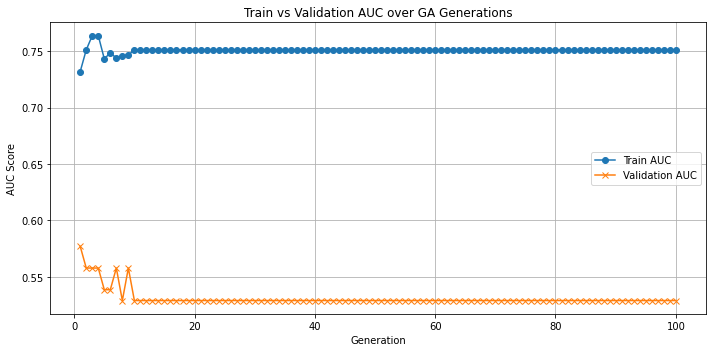

Train AUC Mean: 0.7511
95% CI for Train AUC: [0.7505, 0.7516]
Validation AUC Mean: 0.5310
95% CI for Validation AUC: [0.5297, 0.5329]


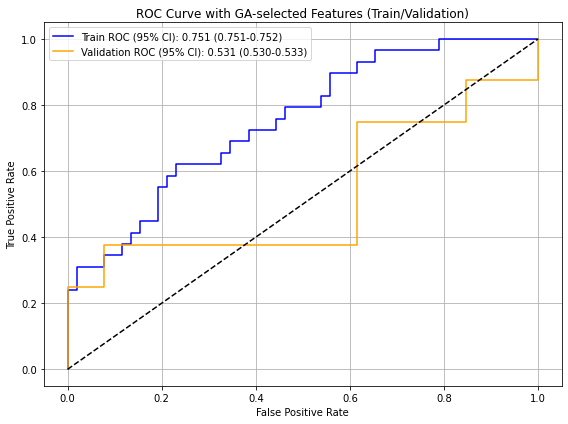

Fold 1 - LogisticRegression: Train AUC=0.7513, Val AUC=0.5288, Features=10

Step 2: Tuning + GA for GaussianNB
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.7685, Features = 4
Generation 20: Best CV AUC = 0.7685, Features = 4
Generation 30: Best CV AUC = 0.7685, Features = 4
Generation 40: Best CV AUC = 0.7685, Features = 4
Generation 50: Best CV AUC = 0.7782, Features = 6
Generation 60: Best CV AUC = 0.7782, Features = 6
Generation 70: Best CV AUC = 0.7782, Features = 6
Generation 80: Best CV AUC = 0.7782, Features = 6
Generation 90: Best CV AUC = 0.7782, Features = 6
Generation 100: Best CV AUC = 0.7782, Features = 6
GA completed! Best CV AUC: 0.7782
Best solution uses 6 features
Selected features count: 6
Selected indices: [0, 4, 9, 12, 16, 19]


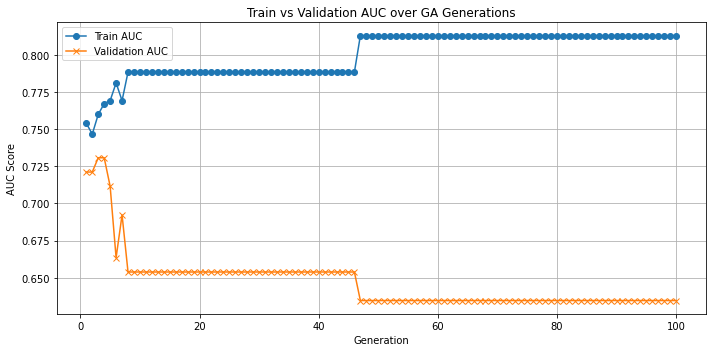

Train AUC Mean: 0.8000
95% CI for Train AUC: [0.7969, 0.8030]
Validation AUC Mean: 0.6474
95% CI for Validation AUC: [0.6440, 0.6521]


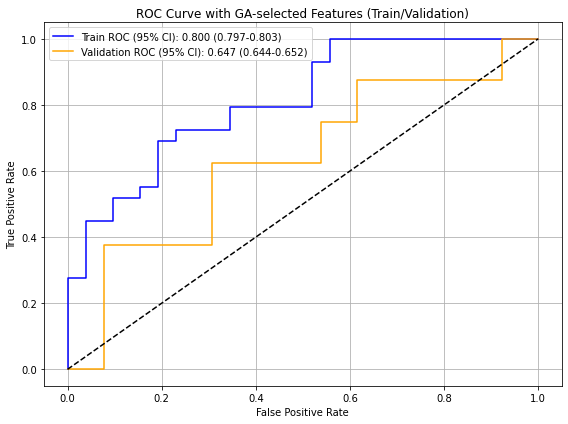

Fold 1 - GaussianNB: Train AUC=0.8130, Val AUC=0.6346, Features=6

Step 2: Tuning + GA for SVC
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.7861, Features = 9
Generation 20: Best CV AUC = 0.7861, Features = 9
Generation 30: Best CV AUC = 0.7861, Features = 9
Generation 40: Best CV AUC = 0.7939, Features = 9
Generation 50: Best CV AUC = 0.7939, Features = 9
Generation 60: Best CV AUC = 0.7939, Features = 9
Generation 70: Best CV AUC = 0.7939, Features = 9
Generation 80: Best CV AUC = 0.7939, Features = 9
Generation 90: Best CV AUC = 0.7939, Features = 9
Generation 100: Best CV AUC = 0.7939, Features = 9
GA completed! Best CV AUC: 0.7939
Best solution uses 9 features
Selected features count: 9
Selected indices: [3, 4, 6, 12, 15, 16, 20, 21, 22]


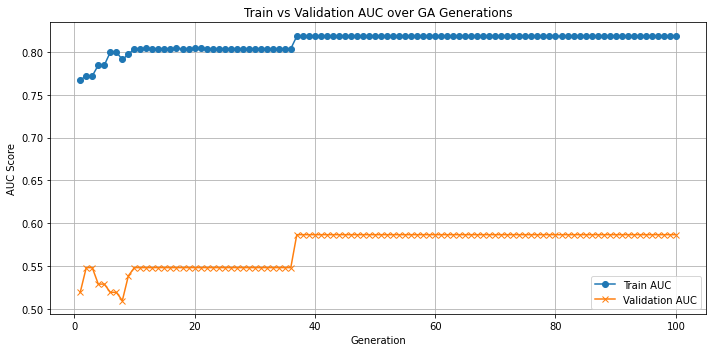

Train AUC Mean: 0.8114
95% CI for Train AUC: [0.8090, 0.8134]
Validation AUC Mean: 0.5710
95% CI for Validation AUC: [0.5665, 0.5751]


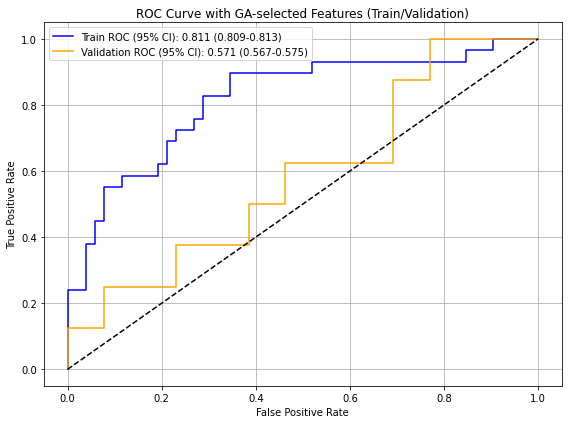

Fold 1 - SVC: Train AUC=0.8183, Val AUC=0.5865, Features=9

Step 2: Tuning + GA for SVC
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.7933, Features = 9
Generation 20: Best CV AUC = 0.7933, Features = 9
Generation 30: Best CV AUC = 0.7933, Features = 9
Generation 40: Best CV AUC = 0.7933, Features = 9
Generation 50: Best CV AUC = 0.7933, Features = 9
Generation 60: Best CV AUC = 0.7933, Features = 9
Generation 70: Best CV AUC = 0.7939, Features = 9
Generation 80: Best CV AUC = 0.7939, Features = 9
Generation 90: Best CV AUC = 0.7939, Features = 9
Generation 100: Best CV AUC = 0.7939, Features = 9
GA completed! Best CV AUC: 0.7939
Best solution uses 9 features
Selected features count: 9
Selected indices: [3, 4, 6, 12, 15, 16, 20, 21, 22]


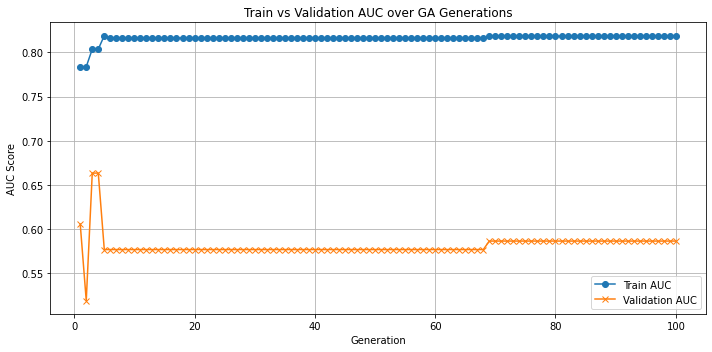

Train AUC Mean: 0.8161
95% CI for Train AUC: [0.8146, 0.8168]
Validation AUC Mean: 0.5814
95% CI for Validation AUC: [0.5792, 0.5848]


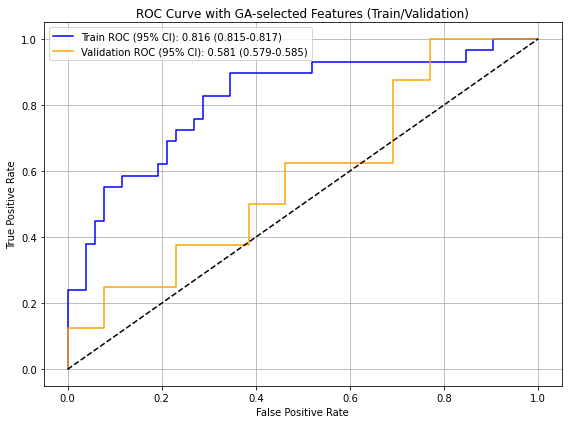

Fold 1 - SVC: Train AUC=0.8183, Val AUC=0.5865, Features=9

Step 2: Tuning + GA for DecisionTreeClassifier
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.7114, Features = 10
Generation 20: Best CV AUC = 0.7114, Features = 10
Generation 30: Best CV AUC = 0.7114, Features = 10
Generation 40: Best CV AUC = 0.7114, Features = 10
Generation 50: Best CV AUC = 0.7114, Features = 10
Generation 60: Best CV AUC = 0.7114, Features = 10
Generation 70: Best CV AUC = 0.7114, Features = 10
Generation 80: Best CV AUC = 0.7114, Features = 10
Generation 90: Best CV AUC = 0.7114, Features = 10
Generation 100: Best CV AUC = 0.7114, Features = 10
GA completed! Best CV AUC: 0.7114
Best solution uses 10 features
Selected features count: 10
Selected indices: [0, 1, 4, 8, 9, 12, 13, 20, 21, 22]


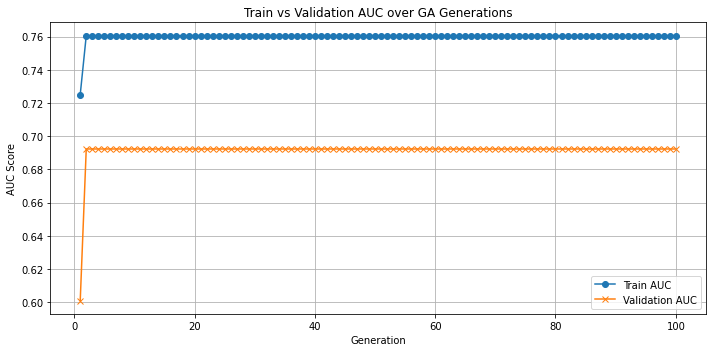

Train AUC Mean: 0.7603
95% CI for Train AUC: [0.7588, 0.7606]
Validation AUC Mean: 0.6914
95% CI for Validation AUC: [0.6877, 0.6923]


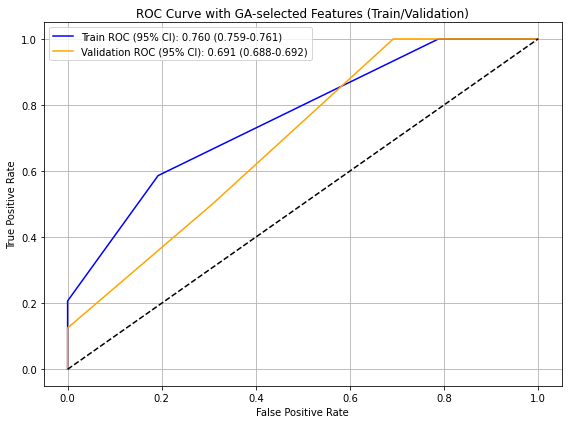

Fold 1 - DecisionTreeClassifier: Train AUC=0.7606, Val AUC=0.6923, Features=10

Step 2: Tuning + GA for RandomForestClassifier
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.7579, Features = 6
Generation 20: Best CV AUC = 0.7861, Features = 5
Generation 30: Best CV AUC = 0.7861, Features = 5
Generation 40: Best CV AUC = 0.8006, Features = 3
Generation 50: Best CV AUC = 0.8006, Features = 3
Generation 60: Best CV AUC = 0.8006, Features = 3
Generation 70: Best CV AUC = 0.8006, Features = 3
Generation 80: Best CV AUC = 0.8006, Features = 3
Generation 90: Best CV AUC = 0.8006, Features = 3
Generation 100: Best CV AUC = 0.8006, Features = 3
GA completed! Best CV AUC: 0.8006
Best solution uses 3 features
Selected features count: 3
Selected indices: [4, 10, 12]


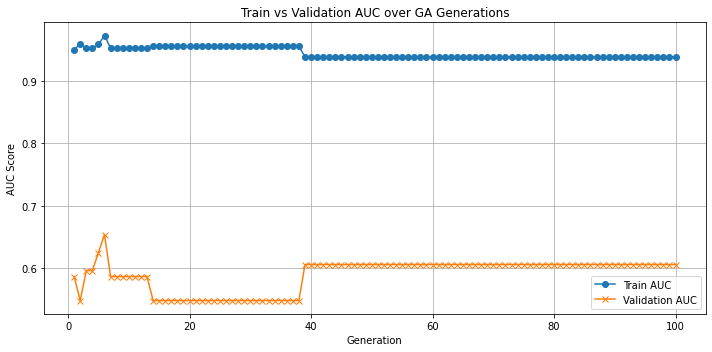

Train AUC Mean: 0.9452
95% CI for Train AUC: [0.9436, 0.9468]
Validation AUC Mean: 0.5897
95% CI for Validation AUC: [0.5843, 0.5946]


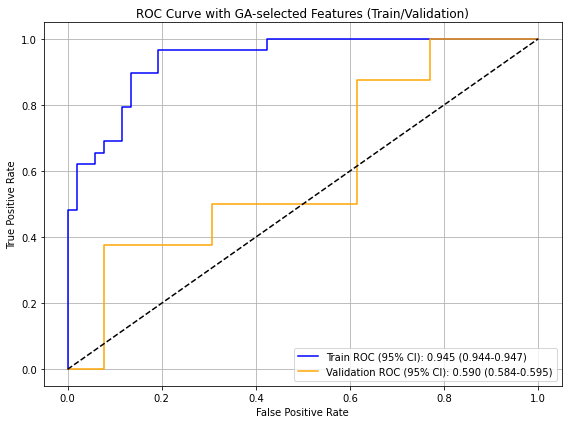

Fold 1 - RandomForestClassifier: Train AUC=0.9390, Val AUC=0.6058, Features=3
Fold 1 total selected features: 19

FOLD 2/5
Step 1: Bootstrap LASSO feature selection...
Stable features (freq >= 0.5): [  0   1   2   3   4   5   6   9  10  13  18  19  22  23  27  36  39  42
  44  45  48  49  62  64  68  69  73  74  77  78  82  84  87  97  98  99
 102]
LASSO selected 37 features from 103

Step 2: Tuning + GA for LogisticRegression
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.8782, Features = 17
Generation 20: Best CV AUC = 0.8852, Features = 16
Generation 30: Best CV AUC = 0.8852, Features = 16
Generation 40: Best CV AUC = 0.8852, Features = 16
Generation 50: Best CV AUC = 0.8852, Features = 16
Generation 60: Best CV AUC = 0.8852, Features = 16
Generation 70: Best CV AUC = 0.8852, Features = 16
Generation 80: Best CV AUC = 0.8852, Features = 16
Generation 90: Best CV AUC = 0.8852, Features = 16
Generation 100: Best CV AUC = 0.8852, Features = 16
GA 

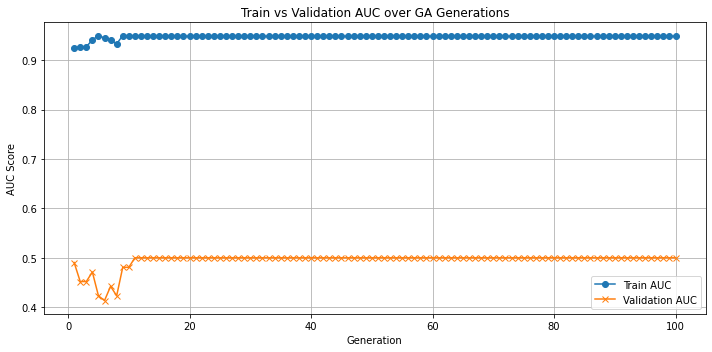

Train AUC Mean: 0.9473
95% CI for Train AUC: [0.9461, 0.9479]
Validation AUC Mean: 0.4953
95% CI for Validation AUC: [0.4913, 0.4979]


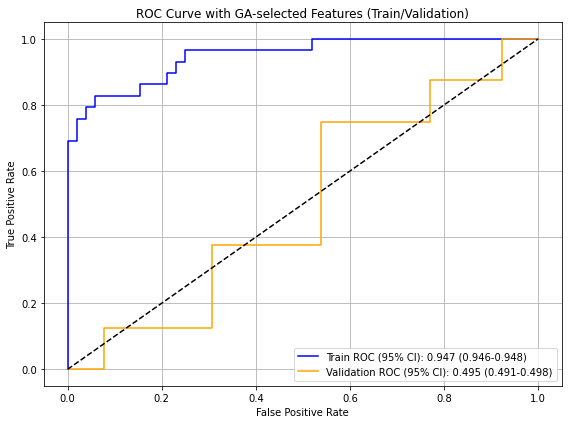

Fold 2 - LogisticRegression: Train AUC=0.9483, Val AUC=0.5000, Features=16

Step 2: Tuning + GA for GaussianNB
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.7291, Features = 15
Generation 20: Best CV AUC = 0.7415, Features = 14
Generation 30: Best CV AUC = 0.7415, Features = 14
Generation 40: Best CV AUC = 0.7445, Features = 14
Generation 50: Best CV AUC = 0.7448, Features = 14
Generation 60: Best CV AUC = 0.7448, Features = 14
Generation 70: Best CV AUC = 0.7448, Features = 14
Generation 80: Best CV AUC = 0.7448, Features = 14
Generation 90: Best CV AUC = 0.7448, Features = 14
Generation 100: Best CV AUC = 0.7448, Features = 14
GA completed! Best CV AUC: 0.7448
Best solution uses 14 features
Selected features count: 14
Selected indices: [2, 5, 6, 10, 16, 17, 18, 24, 26, 28, 29, 30, 32, 36]


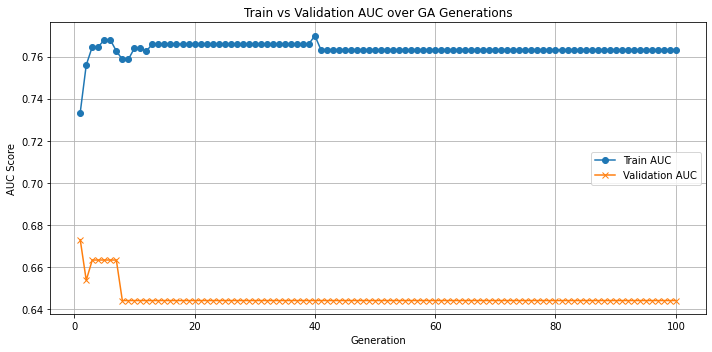

Train AUC Mean: 0.7637
95% CI for Train AUC: [0.7626, 0.7642]
Validation AUC Mean: 0.6456
95% CI for Validation AUC: [0.6448, 0.6466]


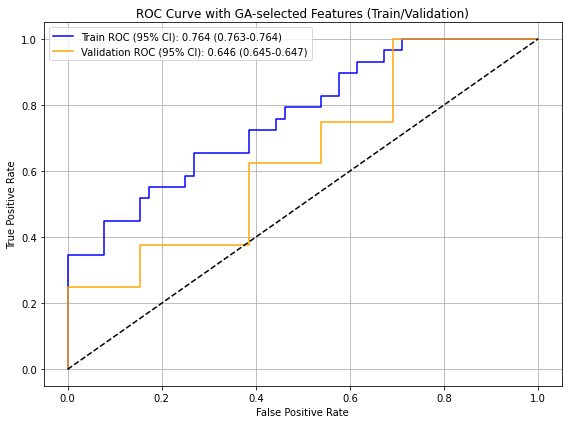

Fold 2 - GaussianNB: Train AUC=0.7633, Val AUC=0.6442, Features=14

Step 2: Tuning + GA for SVC
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.8024, Features = 16
Generation 20: Best CV AUC = 0.8167, Features = 14
Generation 30: Best CV AUC = 0.8455, Features = 17
Generation 40: Best CV AUC = 0.8455, Features = 17
Generation 50: Best CV AUC = 0.8455, Features = 17
Generation 60: Best CV AUC = 0.8455, Features = 17
Generation 70: Best CV AUC = 0.8455, Features = 17
Generation 80: Best CV AUC = 0.8455, Features = 17
Generation 90: Best CV AUC = 0.8455, Features = 17
Generation 100: Best CV AUC = 0.8455, Features = 17
GA completed! Best CV AUC: 0.8455
Best solution uses 17 features
Selected features count: 17
Selected indices: [1, 2, 5, 10, 11, 12, 15, 16, 19, 23, 25, 30, 31, 33, 34, 35, 36]


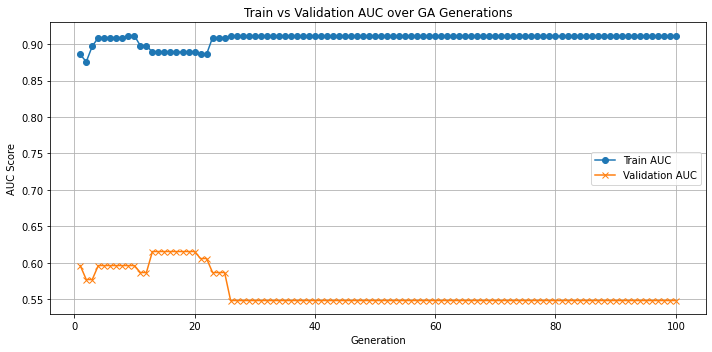

Train AUC Mean: 0.9078
95% CI for Train AUC: [0.9060, 0.9092]
Validation AUC Mean: 0.5610
95% CI for Validation AUC: [0.5564, 0.5659]


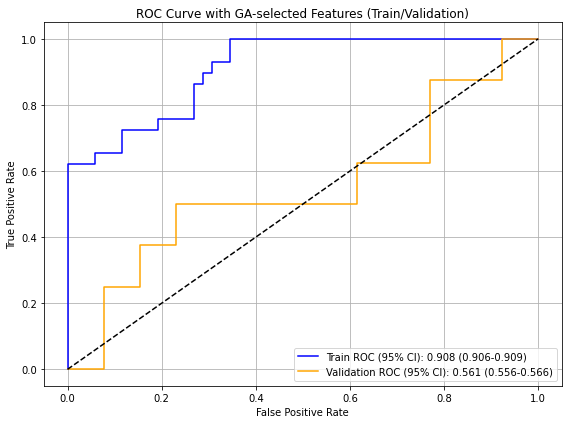

Fold 2 - SVC: Train AUC=0.9111, Val AUC=0.5481, Features=17

Step 2: Tuning + GA for SVC
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.8045, Features = 16
Generation 20: Best CV AUC = 0.8261, Features = 17
Generation 30: Best CV AUC = 0.8318, Features = 16
Generation 40: Best CV AUC = 0.8318, Features = 16
Generation 50: Best CV AUC = 0.8318, Features = 16
Generation 60: Best CV AUC = 0.8318, Features = 16
Generation 70: Best CV AUC = 0.8318, Features = 16
Generation 80: Best CV AUC = 0.8330, Features = 14
Generation 90: Best CV AUC = 0.8330, Features = 14
Generation 100: Best CV AUC = 0.8330, Features = 14
GA completed! Best CV AUC: 0.8330
Best solution uses 14 features
Selected features count: 14
Selected indices: [10, 11, 14, 15, 16, 19, 20, 22, 25, 29, 30, 33, 35, 36]


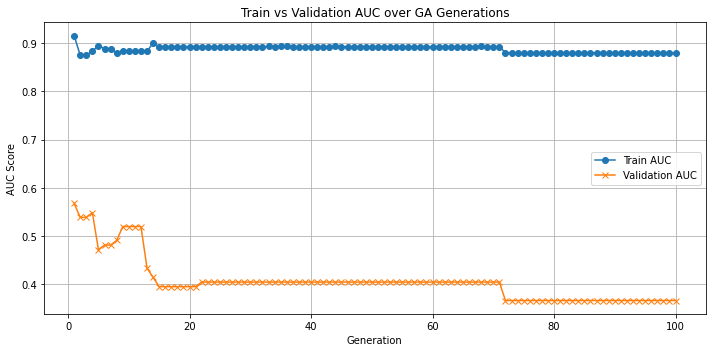

Train AUC Mean: 0.8887
95% CI for Train AUC: [0.8874, 0.8900]
Validation AUC Mean: 0.4059
95% CI for Validation AUC: [0.3979, 0.4163]


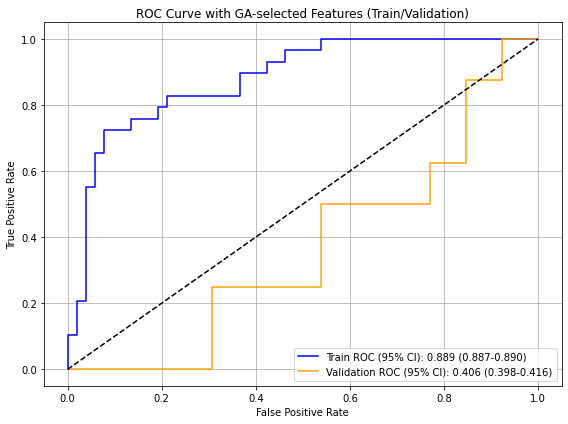

Fold 2 - SVC: Train AUC=0.8806, Val AUC=0.3654, Features=14

Step 2: Tuning + GA for DecisionTreeClassifier
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.7215, Features = 17
Generation 20: Best CV AUC = 0.7715, Features = 17
Generation 30: Best CV AUC = 0.7715, Features = 17
Generation 40: Best CV AUC = 0.7715, Features = 17
Generation 50: Best CV AUC = 0.7715, Features = 17
Generation 60: Best CV AUC = 0.7715, Features = 17
Generation 70: Best CV AUC = 0.7715, Features = 17
Generation 80: Best CV AUC = 0.7715, Features = 17
Generation 90: Best CV AUC = 0.7715, Features = 17
Generation 100: Best CV AUC = 0.7715, Features = 17
GA completed! Best CV AUC: 0.7715
Best solution uses 17 features
Selected features count: 17
Selected indices: [0, 2, 3, 5, 7, 10, 14, 18, 20, 21, 23, 27, 30, 32, 34, 35, 36]


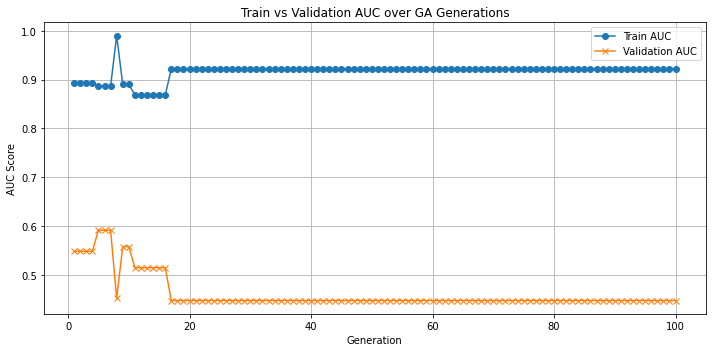

Train AUC Mean: 0.9170
95% CI for Train AUC: [0.9135, 0.9202]
Validation AUC Mean: 0.4618
95% CI for Validation AUC: [0.4559, 0.4707]


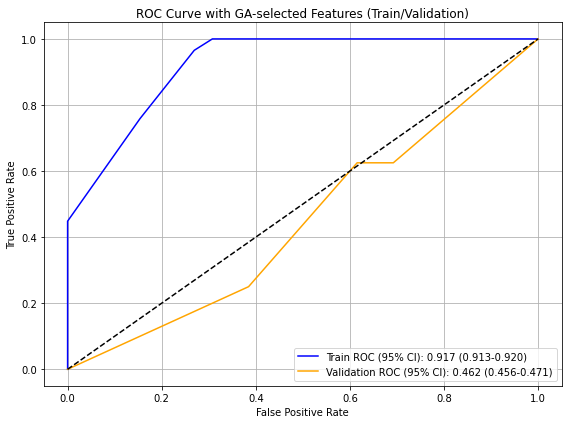

Fold 2 - DecisionTreeClassifier: Train AUC=0.9224, Val AUC=0.4471, Features=17

Step 2: Tuning + GA for RandomForestClassifier
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.6824, Features = 19
Generation 20: Best CV AUC = 0.6824, Features = 19
Generation 30: Best CV AUC = 0.6824, Features = 19
Generation 40: Best CV AUC = 0.6824, Features = 19
Generation 50: Best CV AUC = 0.6824, Features = 19
Generation 60: Best CV AUC = 0.6861, Features = 19
Generation 70: Best CV AUC = 0.6861, Features = 19
Generation 80: Best CV AUC = 0.6861, Features = 19
Generation 90: Best CV AUC = 0.6861, Features = 19
Generation 100: Best CV AUC = 0.6861, Features = 19
GA completed! Best CV AUC: 0.6861
Best solution uses 19 features
Selected features count: 19
Selected indices: [0, 3, 4, 5, 8, 12, 14, 16, 18, 19, 20, 24, 25, 26, 28, 29, 32, 35, 36]


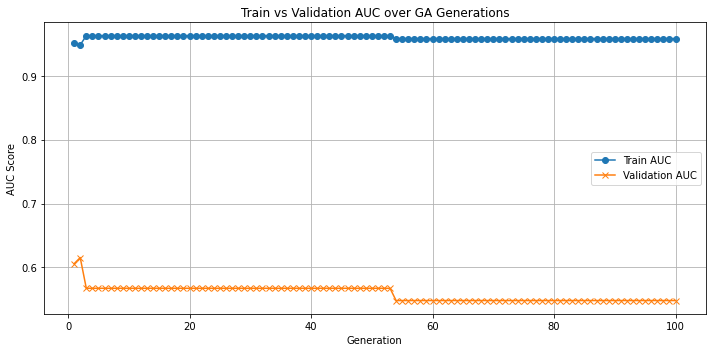

Train AUC Mean: 0.9604
95% CI for Train AUC: [0.9598, 0.9609]
Validation AUC Mean: 0.5591
95% CI for Validation AUC: [0.5567, 0.5614]


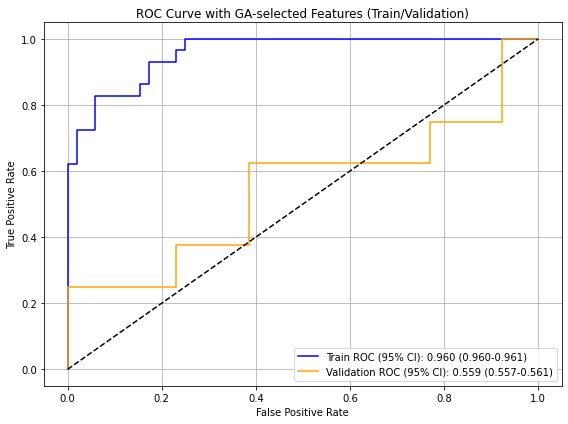

Fold 2 - RandomForestClassifier: Train AUC=0.9582, Val AUC=0.5481, Features=19
Fold 2 total selected features: 35

FOLD 3/5
Step 1: Bootstrap LASSO feature selection...


/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,


Stable features (freq >= 0.5): [ 0  1  4  5  6 10 18 22 27 36 42 45 49 64 73 77 87 93 97 99]
LASSO selected 20 features from 103

Step 2: Tuning + GA for LogisticRegression
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.7061, Features = 4
Generation 20: Best CV AUC = 0.7061, Features = 4
Generation 30: Best CV AUC = 0.7061, Features = 4
Generation 40: Best CV AUC = 0.7061, Features = 4
Generation 50: Best CV AUC = 0.7061, Features = 4
Generation 60: Best CV AUC = 0.7061, Features = 4
Generation 70: Best CV AUC = 0.7103, Features = 3
Generation 80: Best CV AUC = 0.7103, Features = 3
Generation 90: Best CV AUC = 0.7103, Features = 3
Generation 100: Best CV AUC = 0.7103, Features = 3
GA completed! Best CV AUC: 0.7103
Best solution uses 3 features
Selected features count: 3
Selected indices: [4, 17, 19]


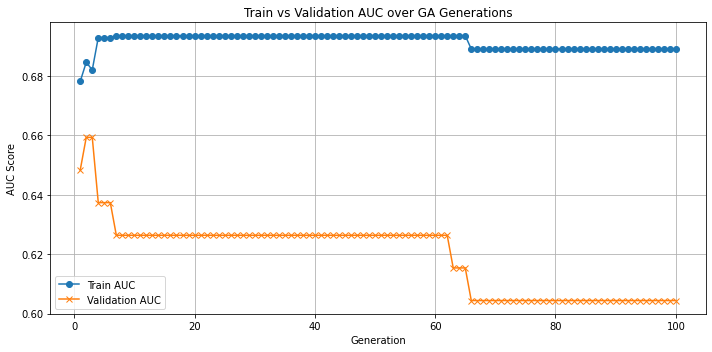

Train AUC Mean: 0.6916
95% CI for Train AUC: [0.6910, 0.6921]
Validation AUC Mean: 0.6196
95% CI for Validation AUC: [0.6170, 0.6219]


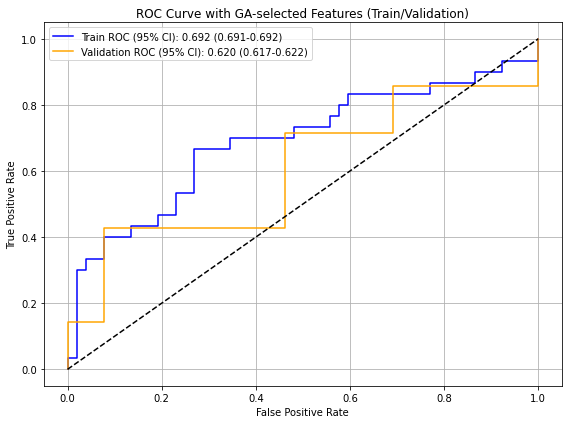

Fold 3 - LogisticRegression: Train AUC=0.6891, Val AUC=0.6044, Features=3

Step 2: Tuning + GA for GaussianNB
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.7545, Features = 3
Generation 20: Best CV AUC = 0.7618, Features = 2
Generation 30: Best CV AUC = 0.7618, Features = 2
Generation 40: Best CV AUC = 0.7618, Features = 2
Generation 50: Best CV AUC = 0.7618, Features = 2
Generation 60: Best CV AUC = 0.7618, Features = 2
Generation 70: Best CV AUC = 0.7618, Features = 2
Generation 80: Best CV AUC = 0.7618, Features = 2
Generation 90: Best CV AUC = 0.7618, Features = 2
Generation 100: Best CV AUC = 0.7618, Features = 2
GA completed! Best CV AUC: 0.7618
Best solution uses 2 features
Selected features count: 2
Selected indices: [4, 10]


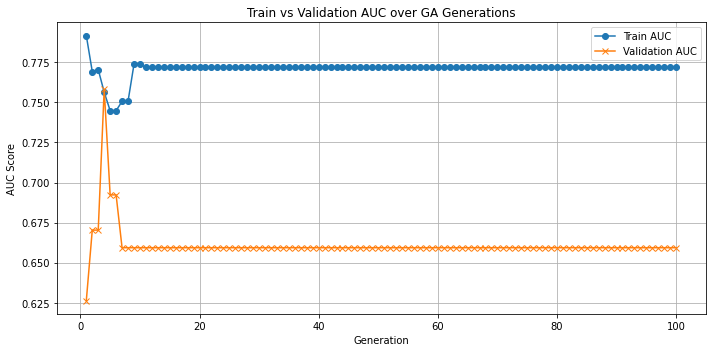

Train AUC Mean: 0.7709
95% CI for Train AUC: [0.7695, 0.7717]
Validation AUC Mean: 0.6609
95% CI for Validation AUC: [0.6593, 0.6642]


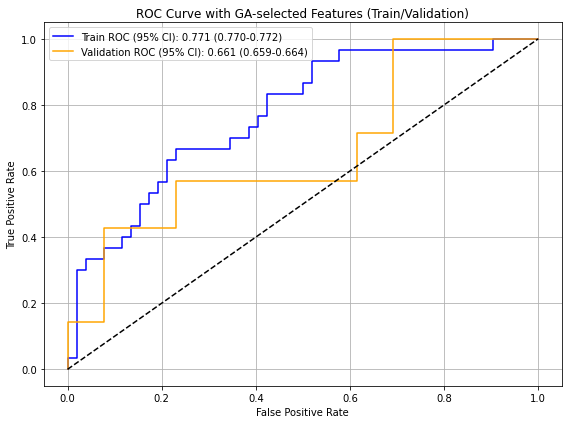

Fold 3 - GaussianNB: Train AUC=0.7718, Val AUC=0.6593, Features=2

Step 2: Tuning + GA for SVC
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.6821, Features = 12
Generation 20: Best CV AUC = 0.6958, Features = 8
Generation 30: Best CV AUC = 0.6991, Features = 9
Generation 40: Best CV AUC = 0.6991, Features = 9
Generation 50: Best CV AUC = 0.6991, Features = 9
Generation 60: Best CV AUC = 0.6991, Features = 9
Generation 70: Best CV AUC = 0.6991, Features = 9
Generation 80: Best CV AUC = 0.6991, Features = 9
Generation 90: Best CV AUC = 0.6991, Features = 9
Generation 100: Best CV AUC = 0.6991, Features = 9
GA completed! Best CV AUC: 0.6991
Best solution uses 9 features
Selected features count: 9
Selected indices: [1, 3, 4, 5, 6, 9, 10, 14, 17]


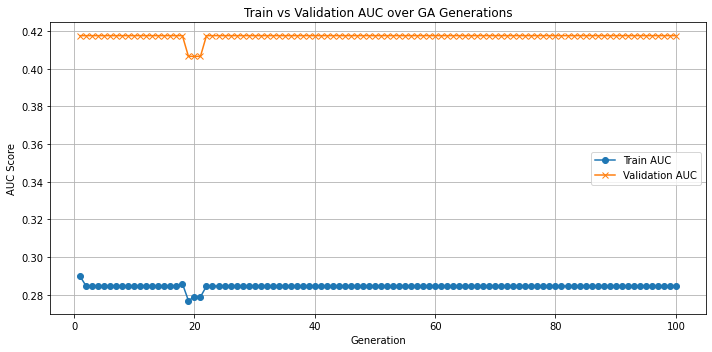

Train AUC Mean: 0.2845
95% CI for Train AUC: [0.2842, 0.2847]
Validation AUC Mean: 0.4173
95% CI for Validation AUC: [0.4166, 0.4175]


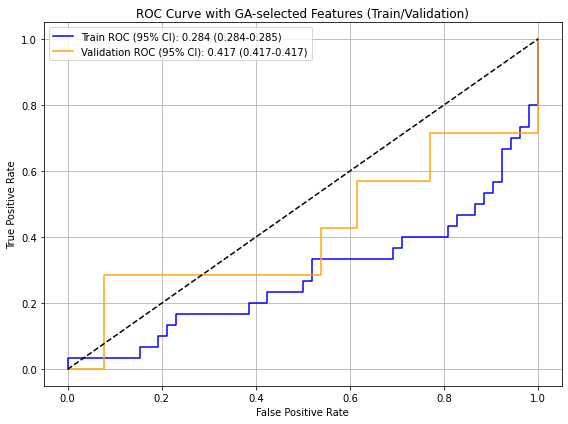

Fold 3 - SVC: Train AUC=0.2846, Val AUC=0.4176, Features=9

Step 2: Tuning + GA for SVC
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.7030, Features = 4
Generation 20: Best CV AUC = 0.7030, Features = 4
Generation 30: Best CV AUC = 0.7030, Features = 4
Generation 40: Best CV AUC = 0.7030, Features = 4
Generation 50: Best CV AUC = 0.7030, Features = 4
Generation 60: Best CV AUC = 0.7103, Features = 3
Generation 70: Best CV AUC = 0.7130, Features = 2
Generation 80: Best CV AUC = 0.7130, Features = 2
Generation 90: Best CV AUC = 0.7130, Features = 2
Generation 100: Best CV AUC = 0.7130, Features = 2
GA completed! Best CV AUC: 0.7130
Best solution uses 2 features
Selected features count: 2
Selected indices: [4, 17]


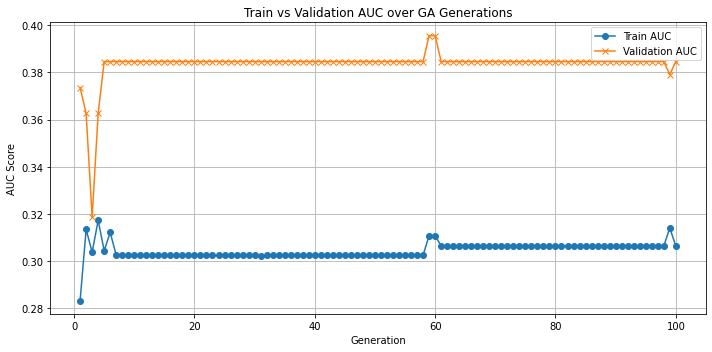

Train AUC Mean: 0.3045
95% CI for Train AUC: [0.3038, 0.3052]
Validation AUC Mean: 0.3836
95% CI for Validation AUC: [0.3809, 0.3845]


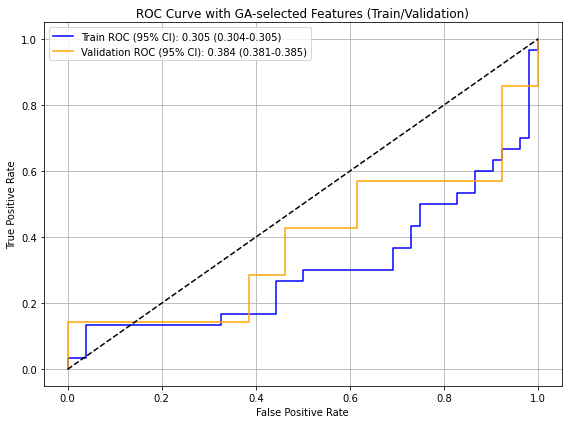

Fold 3 - SVC: Train AUC=0.3064, Val AUC=0.3846, Features=2

Step 2: Tuning + GA for DecisionTreeClassifier
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.6626, Features = 7
Generation 20: Best CV AUC = 0.6626, Features = 7
Generation 30: Best CV AUC = 0.6626, Features = 7
Generation 40: Best CV AUC = 0.6626, Features = 7
Generation 50: Best CV AUC = 0.6626, Features = 7
Generation 60: Best CV AUC = 0.6626, Features = 7
Generation 70: Best CV AUC = 0.6626, Features = 7
Generation 80: Best CV AUC = 0.6626, Features = 7
Generation 90: Best CV AUC = 0.6626, Features = 7
Generation 100: Best CV AUC = 0.7080, Features = 3
GA completed! Best CV AUC: 0.7080
Best solution uses 3 features
Selected features count: 3
Selected indices: [10, 12, 19]


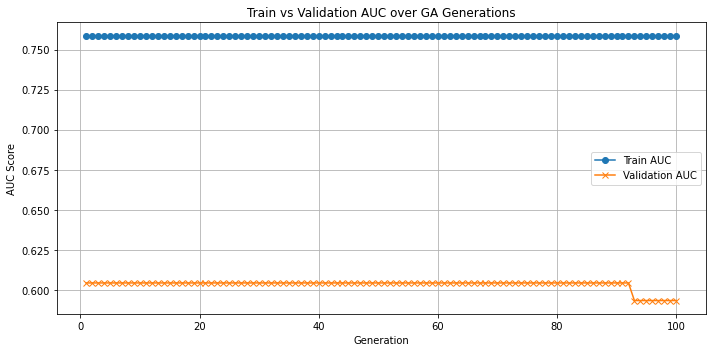

/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/scipy/stats/_bootstrap.py:100: RuntimeWarning: invalid value encountered in double_scalars
  a_hat = num / den


Train AUC Mean: 0.7587
Validation AUC Mean: 0.6035
95% CI for Validation AUC: [0.6027, 0.6038]


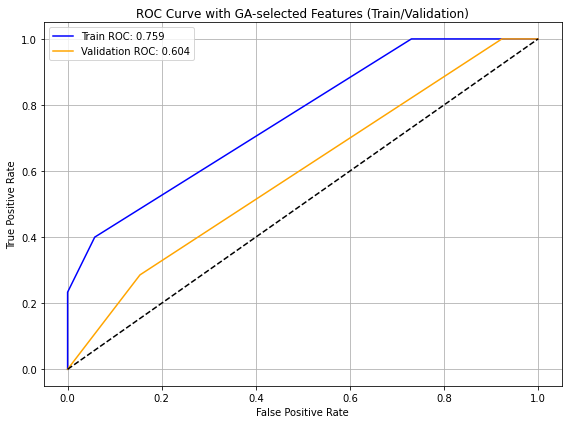

Fold 3 - DecisionTreeClassifier: Train AUC=0.7587, Val AUC=0.5934, Features=3

Step 2: Tuning + GA for RandomForestClassifier
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.6855, Features = 8
Generation 20: Best CV AUC = 0.7439, Features = 2
Generation 30: Best CV AUC = 0.7439, Features = 2
Generation 40: Best CV AUC = 0.7689, Features = 2
Generation 50: Best CV AUC = 0.7689, Features = 2
Generation 60: Best CV AUC = 0.7689, Features = 2
Generation 70: Best CV AUC = 0.7689, Features = 2
Generation 80: Best CV AUC = 0.7689, Features = 2
Generation 90: Best CV AUC = 0.7689, Features = 2
Generation 100: Best CV AUC = 0.7689, Features = 2
GA completed! Best CV AUC: 0.7689
Best solution uses 2 features
Selected features count: 2
Selected indices: [4, 10]


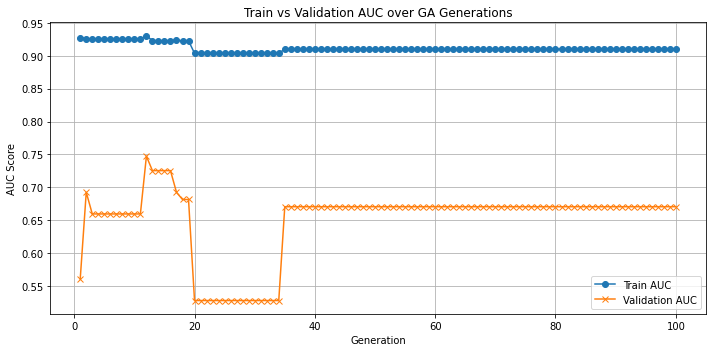

Train AUC Mean: 0.9121
95% CI for Train AUC: [0.9109, 0.9135]
Validation AUC Mean: 0.6504
95% CI for Validation AUC: [0.6386, 0.6601]


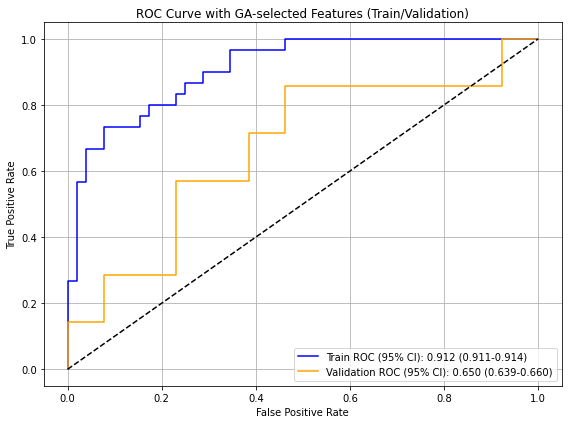

Fold 3 - RandomForestClassifier: Train AUC=0.9103, Val AUC=0.6703, Features=2
Fold 3 total selected features: 11

FOLD 4/5
Step 1: Bootstrap LASSO feature selection...
Stable features (freq >= 0.5): [  0   1   2   3   4   5   6   9  10  13  18  22  27  36  42  45  48  49
  64  69  73  77  78  80  84  92  97  99 101 102]
LASSO selected 30 features from 103

Step 2: Tuning + GA for LogisticRegression
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.7052, Features = 16
Generation 20: Best CV AUC = 0.7082, Features = 16
Generation 30: Best CV AUC = 0.7176, Features = 15
Generation 40: Best CV AUC = 0.7176, Features = 15
Generation 50: Best CV AUC = 0.7176, Features = 15
Generation 60: Best CV AUC = 0.7176, Features = 15
Generation 70: Best CV AUC = 0.7176, Features = 15
Generation 80: Best CV AUC = 0.7176, Features = 15
Generation 90: Best CV AUC = 0.7176, Features = 15
Generation 100: Best CV AUC = 0.7176, Features = 15
GA completed! Best CV AUC: 0.717

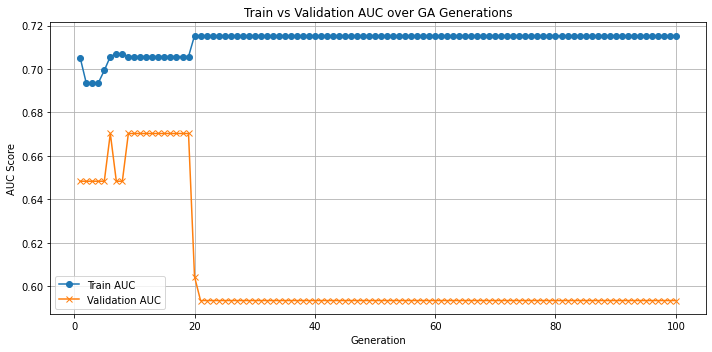

Train AUC Mean: 0.7131
95% CI for Train AUC: [0.7119, 0.7140]
Validation AUC Mean: 0.6066
95% CI for Validation AUC: [0.6015, 0.6124]


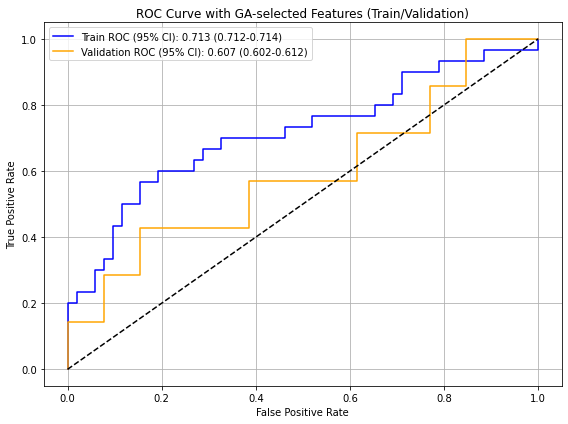

Fold 4 - LogisticRegression: Train AUC=0.7154, Val AUC=0.5934, Features=15

Step 2: Tuning + GA for GaussianNB
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.7558, Features = 5
Generation 20: Best CV AUC = 0.7752, Features = 6
Generation 30: Best CV AUC = 0.7752, Features = 6
Generation 40: Best CV AUC = 0.7752, Features = 6
Generation 50: Best CV AUC = 0.7821, Features = 6
Generation 60: Best CV AUC = 0.7852, Features = 5
Generation 70: Best CV AUC = 0.7852, Features = 5
Generation 80: Best CV AUC = 0.7852, Features = 5
Generation 90: Best CV AUC = 0.7852, Features = 5
Generation 100: Best CV AUC = 0.7852, Features = 5
GA completed! Best CV AUC: 0.7852
Best solution uses 5 features
Selected features count: 5
Selected indices: [0, 6, 9, 11, 14]


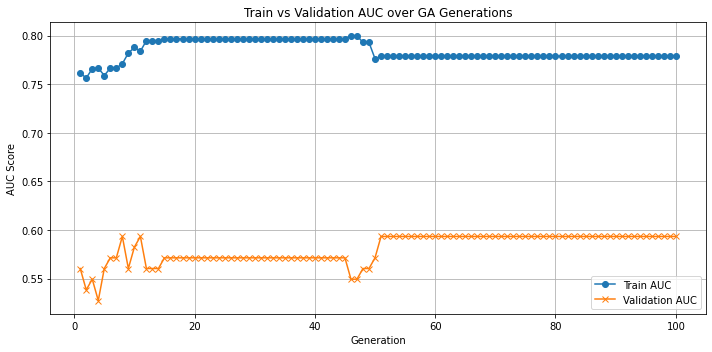

Train AUC Mean: 0.7846
95% CI for Train AUC: [0.7826, 0.7867]
Validation AUC Mean: 0.5807
95% CI for Validation AUC: [0.5776, 0.5834]


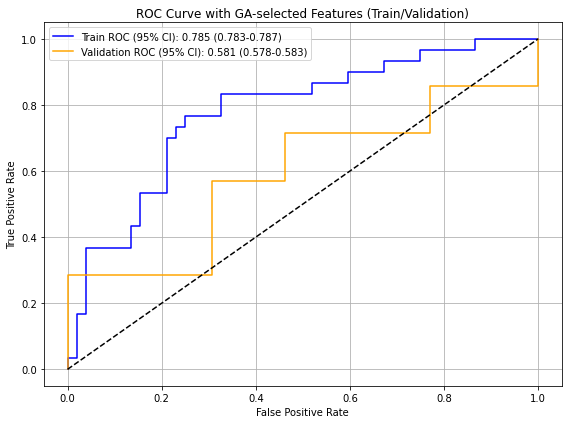

Fold 4 - GaussianNB: Train AUC=0.7788, Val AUC=0.5934, Features=5

Step 2: Tuning + GA for SVC
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.7212, Features = 8
Generation 20: Best CV AUC = 0.7212, Features = 8
Generation 30: Best CV AUC = 0.7303, Features = 8
Generation 40: Best CV AUC = 0.7303, Features = 8
Generation 50: Best CV AUC = 0.7303, Features = 8
Generation 60: Best CV AUC = 0.7303, Features = 8
Generation 70: Best CV AUC = 0.7303, Features = 8
Generation 80: Best CV AUC = 0.7303, Features = 8
Generation 90: Best CV AUC = 0.7303, Features = 8
Generation 100: Best CV AUC = 0.7303, Features = 8
GA completed! Best CV AUC: 0.7303
Best solution uses 8 features
Selected features count: 8
Selected indices: [0, 6, 8, 10, 11, 20, 26, 29]


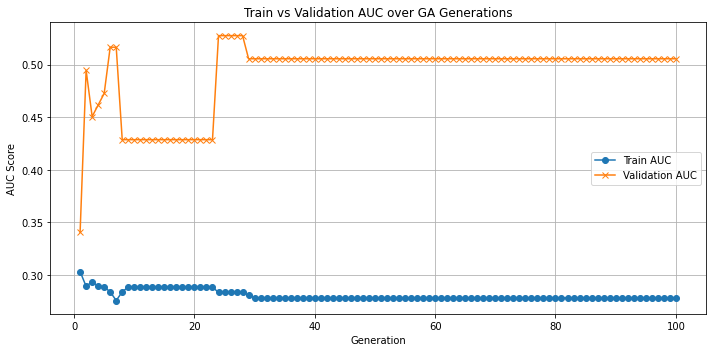

Train AUC Mean: 0.2808
95% CI for Train AUC: [0.2800, 0.2819]
Validation AUC Mean: 0.4914
95% CI for Validation AUC: [0.4838, 0.4975]


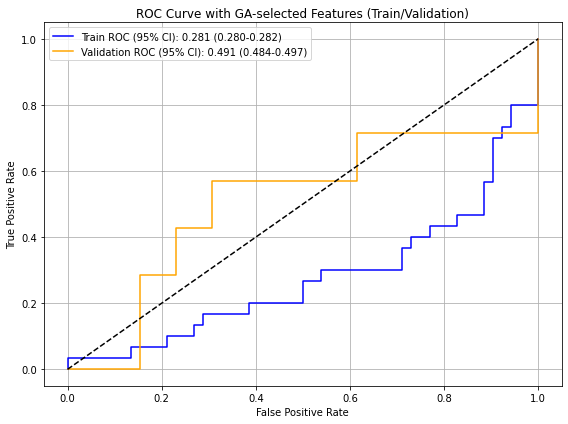

Fold 4 - SVC: Train AUC=0.2782, Val AUC=0.5055, Features=8

Step 2: Tuning + GA for SVC
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.7209, Features = 11
Generation 20: Best CV AUC = 0.7209, Features = 11
Generation 30: Best CV AUC = 0.7209, Features = 11
Generation 40: Best CV AUC = 0.7209, Features = 11
Generation 50: Best CV AUC = 0.7209, Features = 11
Generation 60: Best CV AUC = 0.7209, Features = 11
Generation 70: Best CV AUC = 0.7209, Features = 11
Generation 80: Best CV AUC = 0.7209, Features = 11
Generation 90: Best CV AUC = 0.7209, Features = 11
Generation 100: Best CV AUC = 0.7209, Features = 11
GA completed! Best CV AUC: 0.7209
Best solution uses 11 features
Selected features count: 11
Selected indices: [0, 1, 5, 8, 10, 11, 16, 20, 22, 28, 29]


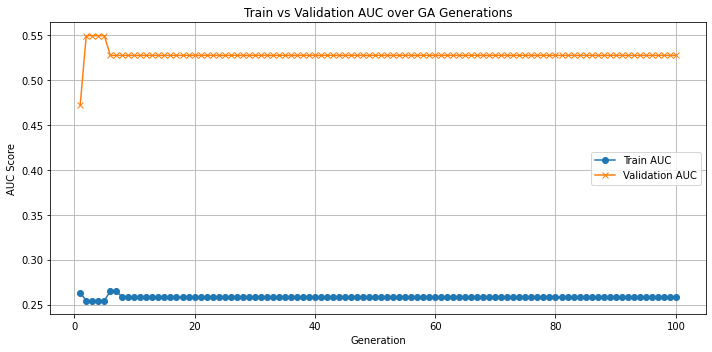

Train AUC Mean: 0.2584
95% CI for Train AUC: [0.2581, 0.2586]
Validation AUC Mean: 0.5278
95% CI for Validation AUC: [0.5258, 0.5288]


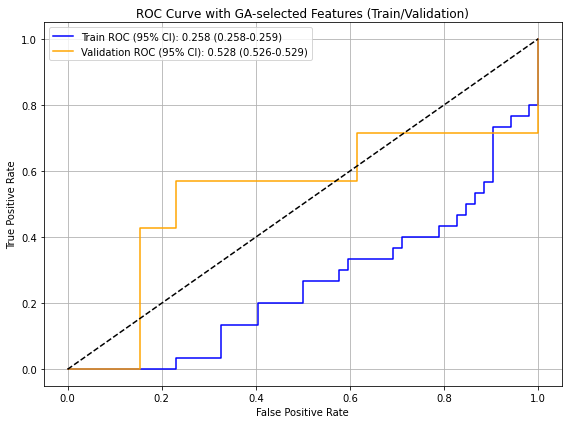

Fold 4 - SVC: Train AUC=0.2583, Val AUC=0.5275, Features=11

Step 2: Tuning + GA for DecisionTreeClassifier
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.7109, Features = 18
Generation 20: Best CV AUC = 0.7109, Features = 18
Generation 30: Best CV AUC = 0.7109, Features = 18
Generation 40: Best CV AUC = 0.7112, Features = 18
Generation 50: Best CV AUC = 0.7112, Features = 18
Generation 60: Best CV AUC = 0.7112, Features = 18
Generation 70: Best CV AUC = 0.7112, Features = 18
Generation 80: Best CV AUC = 0.7112, Features = 18
Generation 90: Best CV AUC = 0.7112, Features = 18
Generation 100: Best CV AUC = 0.7112, Features = 18
GA completed! Best CV AUC: 0.7112
Best solution uses 18 features
Selected features count: 18
Selected indices: [0, 1, 2, 3, 4, 6, 8, 13, 16, 17, 18, 20, 21, 22, 23, 24, 25, 29]


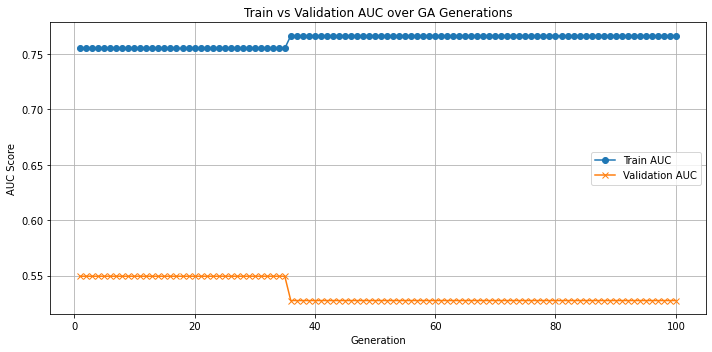

Train AUC Mean: 0.7626
95% CI for Train AUC: [0.7616, 0.7638]
Validation AUC Mean: 0.5352
95% CI for Validation AUC: [0.5327, 0.5369]


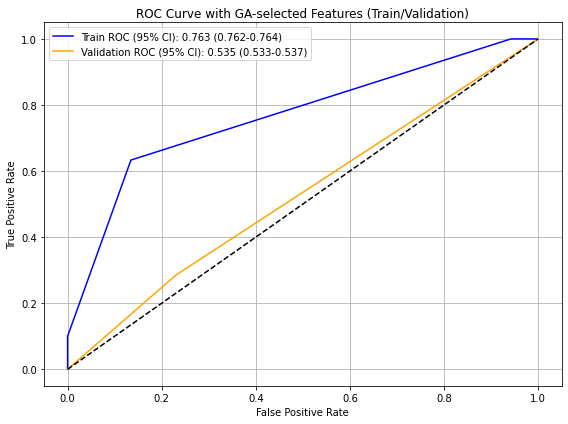

Fold 4 - DecisionTreeClassifier: Train AUC=0.7667, Val AUC=0.5275, Features=18

Step 2: Tuning + GA for RandomForestClassifier
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.6600, Features = 16
Generation 20: Best CV AUC = 0.7109, Features = 12
Generation 30: Best CV AUC = 0.7109, Features = 12
Generation 40: Best CV AUC = 0.7109, Features = 12
Generation 50: Best CV AUC = 0.7109, Features = 12
Generation 60: Best CV AUC = 0.7364, Features = 10
Generation 70: Best CV AUC = 0.7385, Features = 10
Generation 80: Best CV AUC = 0.7385, Features = 10
Generation 90: Best CV AUC = 0.7385, Features = 10
Generation 100: Best CV AUC = 0.7385, Features = 10
GA completed! Best CV AUC: 0.7385
Best solution uses 10 features
Selected features count: 10
Selected indices: [4, 8, 11, 14, 16, 17, 19, 21, 22, 28]


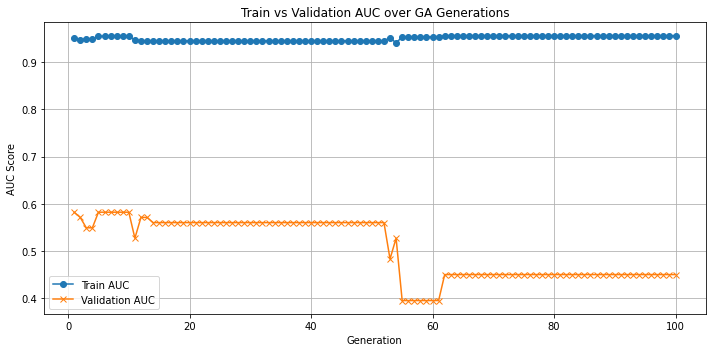

Train AUC Mean: 0.9504
95% CI for Train AUC: [0.9495, 0.9514]
Validation AUC Mean: 0.5063
95% CI for Validation AUC: [0.4934, 0.5179]


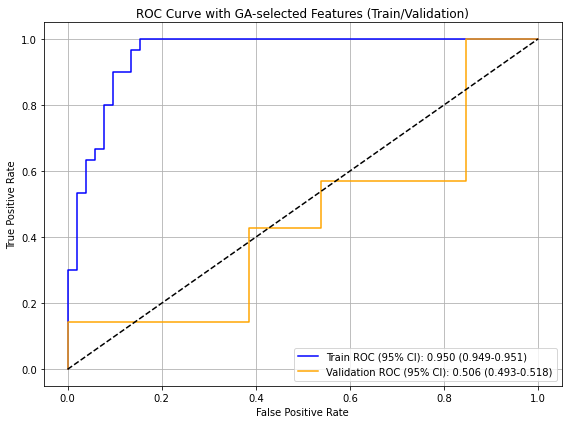

Fold 4 - RandomForestClassifier: Train AUC=0.9558, Val AUC=0.4505, Features=10
Fold 4 total selected features: 28

FOLD 5/5
Step 1: Bootstrap LASSO feature selection...


/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  ConvergenceWarning,
/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/sklearn/svm/_base.py:1208: ConvergenceWarning: Liblinear failed to converge, increase the

Stable features (freq >= 0.5): [  0   1   2   3   4   5   6   7   8   9  10  12  13  15  17  18  19  22
  23  27  36  39  40  42  43  44  45  46  47  48  49  64  67  68  69  72
  73  74  76  77  78  80  81  83  84  85  86  87  88  92  97  98  99 101
 102]
LASSO selected 55 features from 103

Step 2: Tuning + GA for LogisticRegression
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.7058, Features = 21
Generation 20: Best CV AUC = 0.7091, Features = 24
Generation 30: Best CV AUC = 0.7091, Features = 24
Generation 40: Best CV AUC = 0.7091, Features = 24
Generation 50: Best CV AUC = 0.7091, Features = 24
Generation 60: Best CV AUC = 0.7091, Features = 24
Generation 70: Best CV AUC = 0.7091, Features = 24
Generation 80: Best CV AUC = 0.7091, Features = 24
Generation 90: Best CV AUC = 0.7091, Features = 24
Generation 100: Best CV AUC = 0.7094, Features = 24
GA completed! Best CV AUC: 0.7094
Best solution uses 24 features
Selected features count: 24
Selec

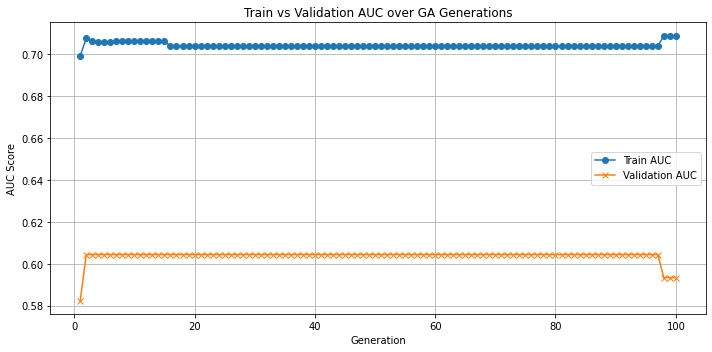

Train AUC Mean: 0.7043
95% CI for Train AUC: [0.7041, 0.7046]
Validation AUC Mean: 0.6038
95% CI for Validation AUC: [0.6030, 0.6042]


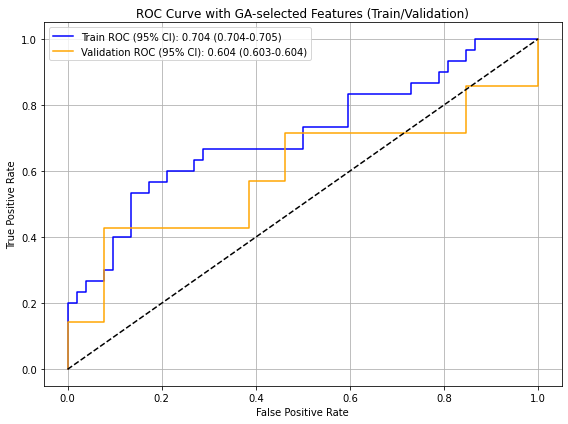

Fold 5 - LogisticRegression: Train AUC=0.7090, Val AUC=0.5934, Features=24

Step 2: Tuning + GA for GaussianNB
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.7176, Features = 23
Generation 20: Best CV AUC = 0.7521, Features = 17
Generation 30: Best CV AUC = 0.7555, Features = 12
Generation 40: Best CV AUC = 0.7724, Features = 11
Generation 50: Best CV AUC = 0.7755, Features = 13
Generation 60: Best CV AUC = 0.7755, Features = 13
Generation 70: Best CV AUC = 0.7755, Features = 13
Generation 80: Best CV AUC = 0.7755, Features = 13
Generation 90: Best CV AUC = 0.7891, Features = 10
Generation 100: Best CV AUC = 0.7973, Features = 9
GA completed! Best CV AUC: 0.7973
Best solution uses 9 features
Selected features count: 9
Selected indices: [0, 23, 30, 35, 36, 38, 44, 45, 46]


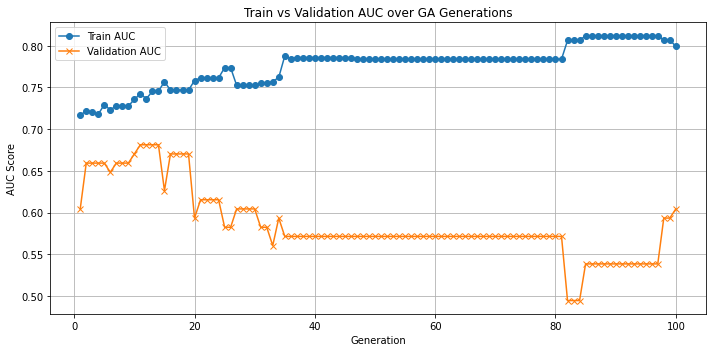

Train AUC Mean: 0.7762
95% CI for Train AUC: [0.7709, 0.7812]
Validation AUC Mean: 0.5866
95% CI for Validation AUC: [0.5780, 0.5956]


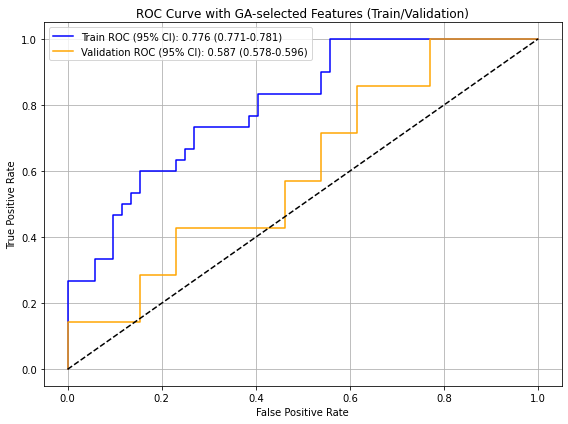

Fold 5 - GaussianNB: Train AUC=0.7994, Val AUC=0.6044, Features=9

Step 2: Tuning + GA for SVC
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.7139, Features = 23
Generation 20: Best CV AUC = 0.7139, Features = 23
Generation 30: Best CV AUC = 0.7139, Features = 23
Generation 40: Best CV AUC = 0.7139, Features = 23
Generation 50: Best CV AUC = 0.7139, Features = 23
Generation 60: Best CV AUC = 0.7139, Features = 23
Generation 70: Best CV AUC = 0.7139, Features = 23
Generation 80: Best CV AUC = 0.7176, Features = 20
Generation 90: Best CV AUC = 0.7206, Features = 22
Generation 100: Best CV AUC = 0.7206, Features = 22
GA completed! Best CV AUC: 0.7206
Best solution uses 22 features
Selected features count: 22
Selected indices: [0, 1, 2, 4, 8, 10, 13, 20, 23, 26, 33, 34, 38, 39, 40, 41, 42, 43, 45, 52, 53, 54]


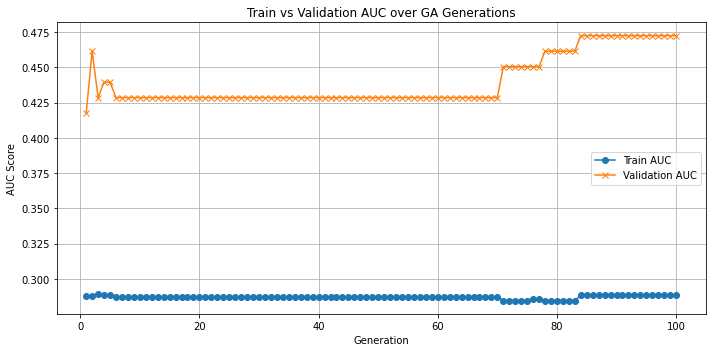

Train AUC Mean: 0.2871
95% CI for Train AUC: [0.2869, 0.2873]
Validation AUC Mean: 0.4400
95% CI for Validation AUC: [0.4367, 0.4434]


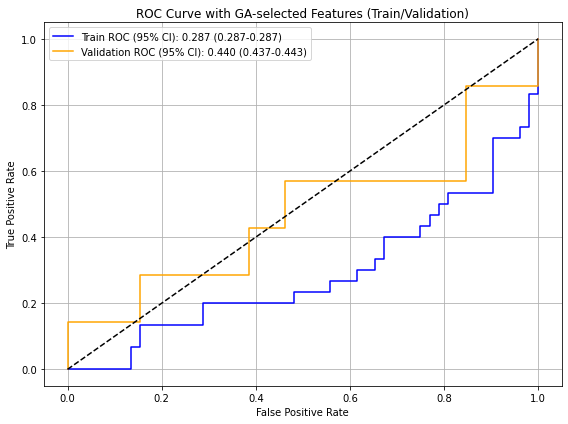

Fold 5 - SVC: Train AUC=0.2885, Val AUC=0.4725, Features=22

Step 2: Tuning + GA for SVC
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.7148, Features = 16
Generation 20: Best CV AUC = 0.7182, Features = 18
Generation 30: Best CV AUC = 0.7182, Features = 18
Generation 40: Best CV AUC = 0.7182, Features = 18
Generation 50: Best CV AUC = 0.7182, Features = 18
Generation 60: Best CV AUC = 0.7182, Features = 18
Generation 70: Best CV AUC = 0.7182, Features = 18
Generation 80: Best CV AUC = 0.7182, Features = 18
Generation 90: Best CV AUC = 0.7209, Features = 19
Generation 100: Best CV AUC = 0.7209, Features = 19
GA completed! Best CV AUC: 0.7209
Best solution uses 19 features
Selected features count: 19
Selected indices: [0, 1, 2, 4, 7, 8, 10, 13, 20, 23, 37, 40, 41, 42, 45, 48, 50, 53, 54]


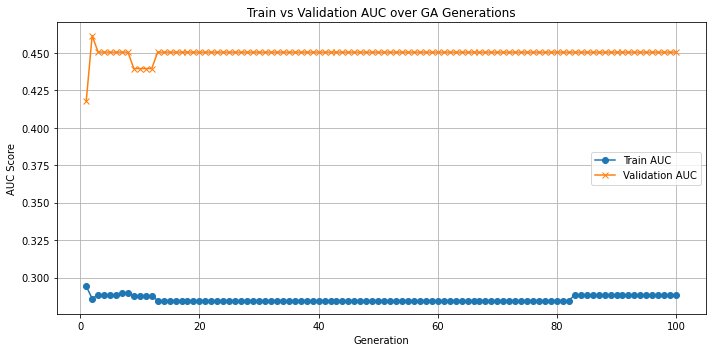

Train AUC Mean: 0.2858
95% CI for Train AUC: [0.2854, 0.2862]
Validation AUC Mean: 0.4499
95% CI for Validation AUC: [0.4489, 0.4504]


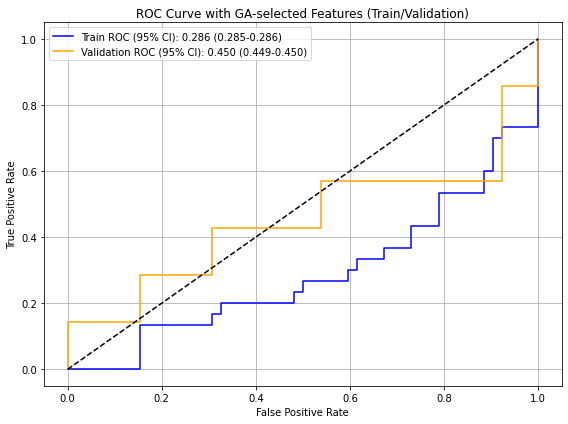

Fold 5 - SVC: Train AUC=0.2885, Val AUC=0.4505, Features=19

Step 2: Tuning + GA for DecisionTreeClassifier
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.7032, Features = 30
Generation 20: Best CV AUC = 0.7048, Features = 30
Generation 30: Best CV AUC = 0.7048, Features = 30
Generation 40: Best CV AUC = 0.7048, Features = 30
Generation 50: Best CV AUC = 0.7048, Features = 30
Generation 60: Best CV AUC = 0.7048, Features = 30
Generation 70: Best CV AUC = 0.7048, Features = 30
Generation 80: Best CV AUC = 0.7048, Features = 30
Generation 90: Best CV AUC = 0.7048, Features = 30
Generation 100: Best CV AUC = 0.7048, Features = 30
GA completed! Best CV AUC: 0.7048
Best solution uses 30 features
Selected features count: 30
Selected indices: [0, 1, 2, 3, 4, 6, 8, 9, 16, 17, 18, 19, 20, 25, 26, 28, 29, 30, 31, 32, 33, 37, 38, 39, 43, 44, 45, 49, 51, 52]


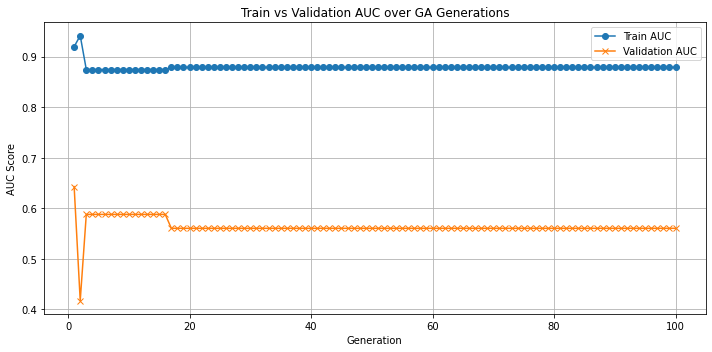

Train AUC Mean: 0.8790
95% CI for Train AUC: [0.8780, 0.8814]
Validation AUC Mean: 0.5637
95% CI for Validation AUC: [0.5592, 0.5665]


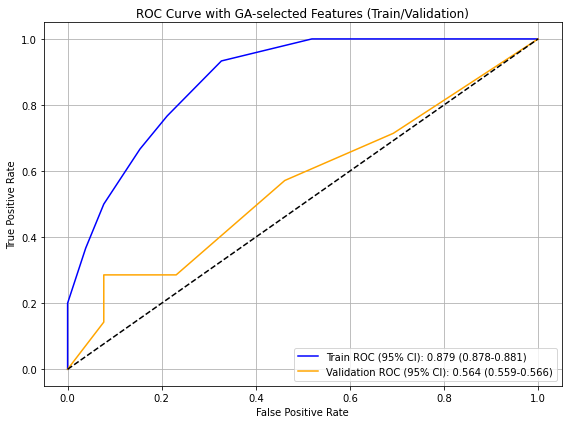

Fold 5 - DecisionTreeClassifier: Train AUC=0.8785, Val AUC=0.5604, Features=30

Step 2: Tuning + GA for RandomForestClassifier
Starting GA with 50 individuals for 100 generations...
Generation 10: Best CV AUC = 0.7630, Features = 21
Generation 20: Best CV AUC = 0.7724, Features = 18
Generation 30: Best CV AUC = 0.7724, Features = 18
Generation 40: Best CV AUC = 0.7724, Features = 18
Generation 50: Best CV AUC = 0.7724, Features = 18
Generation 60: Best CV AUC = 0.7724, Features = 18
Generation 70: Best CV AUC = 0.7724, Features = 18
Generation 80: Best CV AUC = 0.7791, Features = 19
Generation 90: Best CV AUC = 0.7791, Features = 19
Generation 100: Best CV AUC = 0.7791, Features = 19
GA completed! Best CV AUC: 0.7791
Best solution uses 19 features
Selected features count: 19
Selected indices: [0, 2, 4, 5, 7, 8, 9, 11, 14, 20, 23, 24, 29, 31, 39, 47, 48, 53, 54]


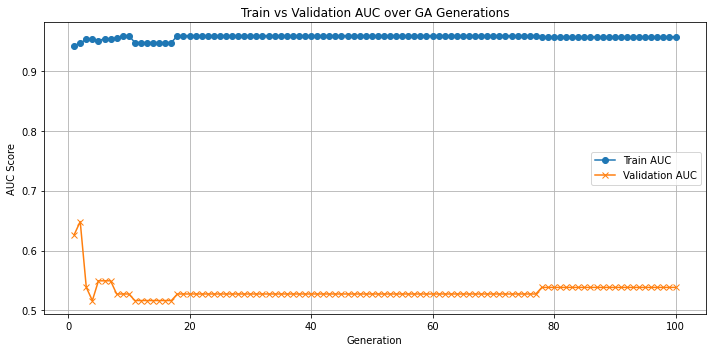

Train AUC Mean: 0.9571
95% CI for Train AUC: [0.9563, 0.9577]
Validation AUC Mean: 0.5321
95% CI for Validation AUC: [0.5299, 0.5371]


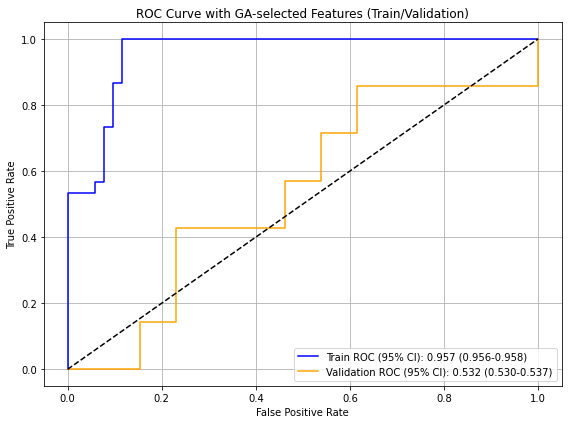

Fold 5 - RandomForestClassifier: Train AUC=0.9571, Val AUC=0.5385, Features=19
Fold 5 total selected features: 51

BUILDING CONSENSUS FEATURES
Consensus selected features: 25
Feature selection frequency: [4 5 3 3 3 5 5 5 4 4 4 5 5 4 4 5 4 3 4 4 4 3 4 4 3]

FINAL EVALUATION ON TEST SET

Final evaluation: LogisticRegression
Bootstrapped 95% CI for Final Model Test AUC: 0.6768 [0.5488, 0.7921] (valid reps = 1000)
Bootstrapped 95% CI for Final Model Test AUC: 0.6247 [0.3873, 0.8375] (valid reps = 1000)

Final evaluation: GaussianNB
Bootstrapped 95% CI for Final Model Test AUC: 0.7256 [0.6145, 0.8220] (valid reps = 1000)
Bootstrapped 95% CI for Final Model Test AUC: 0.6245 [0.3936, 0.8313] (valid reps = 1000)

Final evaluation: SVC
Bootstrapped 95% CI for Final Model Test AUC: 0.3083 [0.2021, 0.4304] (valid reps = 1000)
Bootstrapped 95% CI for Final Model Test AUC: 0.3884 [0.1813, 0.6125] (valid reps = 1000)

Final evaluation: SVC
Bootstrapped 95% CI for Final Model Test AUC: 0.3083 [0.2021

In [ ]:
# ==========================================
# CORRECTED GA MAIN PIPELINE (MATCHING OTHER ALGORITHMS)
# ==========================================

def corrected_ga_main_pipeline():
    """
    GA main pipeline that matches the EXACT same structure as PSO/WOA/GWO/SA pipelines:
    1. 80/20 split
    2. 5-Fold CV with LASSO+GA per fold 
    3. Feature name-based consensus
    4. Final evaluation on held-out test set
    """
    
    print("="*80)
    print("CORRECTED GA RADIOMICS FEATURE SELECTION PIPELINE")
    print("="*80)
    
    # ===============================================================
    # 1) Load data and perform initial 80/20 split  
    # ===============================================================
    print("\nStep 1: Loading data and creating train/test split...")
    
    radiomics_data, clinical_data = load_data()
    radiomics_cols = get_radiomics_columns(radiomics_data)
    X_raw = radiomics_data[radiomics_cols].values
    y = clinical_data["LocoRegeonalRecurrence"].values
    feature_names = radiomics_data[radiomics_cols].columns.tolist()

    print(f"Dataset: {len(X_raw)} samples, {X_raw.shape[1]} features")
    print(f"Class distribution: LRR={np.sum(y)} ({100*np.sum(y)/len(y):.1f}%), "
          f"Non-LRR={len(y)-np.sum(y)} ({100*(len(y)-np.sum(y))/len(y):.1f}%)")

    # Proper 80/20 split with stratification
    X_temp, X_test_raw, y_temp, y_test = train_test_split(
        X_raw, y, test_size=0.2, stratify=y, random_state=42
    )

    print(f"Training/Validation: {len(X_temp)} samples")
    print(f"Test (held-out): {len(X_test_raw)} samples")

    # ===============================================================
    # 2) 5-Fold CV with corrected feature selection pipeline
    # ===============================================================
    print(f"\nStep 2: 5-Fold Cross-Validation with corrected GA feature selection...")
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define classifiers
    classifiers = [
        LogisticRegression(max_iter=1000),
        GaussianNB(),
        SVC(kernel='linear', probability=True),
        SVC(kernel='rbf', probability=True),
        DecisionTreeClassifier(random_state=42),
        RandomForestClassifier(random_state=42, n_jobs=-1)
    ]

    # Store selected feature NAMES (not indices) for proper consensus
    fold_selected_features = {}  # classifier -> [fold_features_sets]
    classifier_fold_results = {}
    
    for clf in classifiers:
        clf_name = clf.__class__.__name__
        fold_selected_features[clf_name] = []
        classifier_fold_results[clf_name] = {
            'train_aucs': [], 'val_aucs': [], 'train_accs': [], 'val_accs': []
        }

    # Cross-validation loop
    for fold_id, (tr_idx, va_idx) in enumerate(skf.split(X_temp, y_temp), 1):
        print(f"\n{'='*60}")
        print(f"PROCESSING FOLD {fold_id}/5")
        print(f"{'='*60}")
        
        X_tr_raw, X_va_raw = X_temp[tr_idx], X_temp[va_idx]
        y_tr, y_va = y_temp[tr_idx], y_temp[va_idx]

        # STEP 1: Proper scaling (fit on train, transform both)
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr_raw)
        X_va_scaled = scaler.transform(X_va_raw)

        # STEP 2: Bootstrap LASSO feature selection (on training fold only)
        print(f"Applying Bootstrap LASSO feature selection...")
        stable_idx_fold = bootstrap_lasso_fs(
            X_tr_scaled, y_tr, n_bootstrap=1000, freq_threshold=0.5
        )
        stable_idx_fold = np.asarray(stable_idx_fold)
        
        if len(stable_idx_fold) == 0:
            print(f"Warning: No stable features found in fold {fold_id}. Skipping fold.")
            continue
            
        print(f"LASSO selected {len(stable_idx_fold)} features from {X_tr_scaled.shape[1]}")

        # Apply LASSO selection to get reduced feature matrices
        X_tr_lasso = X_tr_scaled[:, stable_idx_fold]
        X_va_lasso = X_va_scaled[:, stable_idx_fold]
        
        # Get feature names for LASSO-selected features
        lasso_feature_names = [feature_names[i] for i in stable_idx_fold]

        # STEP 3: GA feature selection per classifier (CORRECTED VERSION)
        for clf in classifiers:
            clf_name = clf.__class__.__name__
            print(f"\nProcessing {clf_name} with corrected GA...")
            
            try:
                # Hyperparameter tuning on LASSO-selected features
                tuned_clf = get_tuned_model(clf, X_tr_lasso, y_tr)

                # CORRECTED GA: Uses fixed evaluate_fitness function
                best_solution, train_auc_hist, val_auc_hist = run_genetic_algorithm(
                    X_tr_lasso, y_tr, X_va_lasso, y_va, tuned_clf, 
                    pop_size=30, generations=40, verbose=False
                )

                # Get GA-selected feature names (not indices)
                ga_selected_indices = np.where(best_solution == 1)[0]
                ga_selected_feature_names = [lasso_feature_names[i] for i in ga_selected_indices]
                
                # Store selected feature names for this classifier and fold
                fold_selected_features[clf_name].append(set(ga_selected_feature_names))

                # Evaluate performance with selected features
                if len(ga_selected_indices) > 0:
                    X_tr_final = X_tr_lasso[:, best_solution == 1]
                    X_va_final = X_va_lasso[:, best_solution == 1]
                    
                    # Train final model and evaluate
                    final_model = make_pipeline(StandardScaler(), tuned_clf)
                    final_model.fit(X_tr_final, y_tr)
                    
                    # Get predictions
                    if hasattr(final_model, 'predict_proba'):
                        y_tr_proba = final_model.predict_proba(X_tr_final)[:, 1]
                        y_va_proba = final_model.predict_proba(X_va_final)[:, 1]
                    else:
                        y_tr_proba = final_model.decision_function(X_tr_final)
                        y_va_proba = final_model.decision_function(X_va_final)
                    
                    y_tr_pred = final_model.predict(X_tr_final)
                    y_va_pred = final_model.predict(X_va_final)
                    
                    # Calculate metrics
                    train_auc = roc_auc_score(y_tr, y_tr_proba)
                    val_auc = roc_auc_score(y_va, y_va_proba)
                    train_acc = accuracy_score(y_tr, y_tr_pred)
                    val_acc = accuracy_score(y_va, y_va_pred)
                    
                    # Store results
                    classifier_fold_results[clf_name]['train_aucs'].append(train_auc)
                    classifier_fold_results[clf_name]['val_aucs'].append(val_auc)
                    classifier_fold_results[clf_name]['train_accs'].append(train_acc)
                    classifier_fold_results[clf_name]['val_accs'].append(val_acc)
                    
                    print(f"  {clf_name}: Train AUC={train_auc:.4f}, Val AUC={val_auc:.4f}, "
                          f"Features={len(ga_selected_indices)}")
                else:
                    print(f"  Warning: {clf_name} selected no features in fold {fold_id}")
                    
            except Exception as e:
                print(f"  Error processing {clf_name}: {e}")
                fold_selected_features[clf_name].append(set())

    # ===============================================================
    # 3) CORRECTED consensus building using feature names (same as others)
    # ===============================================================
    print(f"\n{'='*60}")
    print("BUILDING CONSENSUS FEATURES (CORRECTED METHOD)")
    print(f"{'='*60}")
    
    # Build consensus per classifier, then combine (same as all other algorithms)
    classifier_consensus_features = {}
    
    for clf_name in fold_selected_features:
        if len(fold_selected_features[clf_name]) == 0:
            classifier_consensus_features[clf_name] = set()
            continue
            
        # Get all unique features selected by this classifier across folds
        all_features_for_clf = set()
        for fold_features in fold_selected_features[clf_name]:
            all_features_for_clf.update(fold_features)
        
        # Count votes for each feature
        feature_votes = {}
        for feature in all_features_for_clf:
            votes = sum(1 for fold_features in fold_selected_features[clf_name] 
                       if feature in fold_features)
            feature_votes[feature] = votes
        
        # Select features with majority vote (>= 3 out of 5 folds)
        consensus_features_clf = {feature for feature, votes in feature_votes.items() 
                                 if votes >= 3}
        
        # Fallback: if no features meet majority threshold, use >= 2 votes
        if len(consensus_features_clf) == 0:
            consensus_features_clf = {feature for feature, votes in feature_votes.items() 
                                     if votes >= 2}
        
        # Final fallback: use union if still empty
        if len(consensus_features_clf) == 0:
            consensus_features_clf = all_features_for_clf
            
        classifier_consensus_features[clf_name] = consensus_features_clf
        print(f"{clf_name}: {len(consensus_features_clf)} consensus features")

    # FINAL CONSENSUS: Union of all classifier consensus features
    final_consensus_features = set()
    for clf_features in classifier_consensus_features.values():
        final_consensus_features.update(clf_features)
    
    # Convert back to indices for final evaluation
    consensus_feature_names = list(final_consensus_features)
    consensus_indices = [feature_names.index(fname) for fname in consensus_feature_names 
                        if fname in feature_names]
    
    print(f"\nFinal GA consensus: {len(consensus_indices)} features")
    print(f"Consensus features: {consensus_feature_names[:10]}..." if len(consensus_feature_names) > 10 
          else f"Consensus features: {consensus_feature_names}")

    # ===============================================================
    # 4) Final evaluation on held-out test set (same as others)
    # ===============================================================
    print(f"\n{'='*60}")
    print("FINAL EVALUATION ON HELD-OUT TEST SET")
    print(f"{'='*60}")
    
    if len(consensus_indices) == 0:
        print("ERROR: No consensus features found. Cannot proceed with final evaluation.")
        return
    
    # Apply final scaling and consensus feature selection
    scaler_final = StandardScaler()
    X_trval_scaled = scaler_final.fit_transform(X_temp)
    X_test_scaled = scaler_final.transform(X_test_raw)
    
    # Select consensus features
    X_trval_final = X_trval_scaled[:, consensus_indices]
    X_test_final = X_test_scaled[:, consensus_indices]
    
    print(f"Final training set: {X_trval_final.shape}")
    print(f"Final test set: {X_test_final.shape}")

    # Final evaluation per classifier (same structure as others)
    final_results = {}
    
    for clf in classifiers:
        clf_name = clf.__class__.__name__
        print(f"\nFinal evaluation: {clf_name}")
        
        try:
            # Retune on full 80% with consensus features
            tuned_clf_final = get_tuned_model(clf, X_trval_final, y_temp)
            tuned_clf_final.fit(X_trval_final, y_temp)

            # Training performance (80% data)
            if hasattr(tuned_clf_final, "predict_proba"):
                y_train_proba = tuned_clf_final.predict_proba(X_trval_final)[:, 1]
            else:
                y_train_proba = tuned_clf_final.decision_function(X_trval_final)
            
            y_train_pred = tuned_clf_final.predict(X_trval_final)
            train_auc = roc_auc_score(y_temp, y_train_proba)
            train_acc = accuracy_score(y_temp, y_train_pred)

            # Test performance (20% held-out data)
            if hasattr(tuned_clf_final, "predict_proba"):
                y_test_proba = tuned_clf_final.predict_proba(X_test_final)[:, 1]
            else:
                y_test_proba = tuned_clf_final.decision_function(X_test_final)
            
            y_test_pred = tuned_clf_final.predict(X_test_final)
            test_auc = roc_auc_score(y_test, y_test_proba)
            test_acc = accuracy_score(y_test, y_test_pred)

            # Bootstrap confidence intervals
            train_mean_auc, train_lower, train_upper, train_valid = bootstrap_final_model_auc_ci(
                y_temp, y_train_proba, n_bootstrap=1000
            )
            
            test_mean_auc, test_lower, test_upper, test_valid = bootstrap_final_model_auc_ci(
                y_test, y_test_proba, n_bootstrap=1000
            )

            # Store results
            final_results[clf_name] = {
                'train_auc': train_auc,
                'train_acc': train_acc,
                'test_auc': test_auc,
                'test_acc': test_acc,
                'train_ci_lower': train_lower,
                'train_ci_upper': train_upper,
                'test_ci_lower': test_lower,
                'test_ci_upper': test_upper
            }
            
        except Exception as e:
            print(f"Error evaluating {clf_name}: {e}")

    # ===============================================================
    # 5) COMPREHENSIVE RESULTS SUMMARY (same as others)
    # ===============================================================
    print(f"\n{'='*80}")
    print("GA PIPELINE COMPREHENSIVE PERFORMANCE SUMMARY")
    print(f"{'='*80}")
    
    print(f"\nDATASET SUMMARY:")
    print(f"- Total samples: {len(X_raw)} (Train/Val: {len(X_temp)}, Test: {len(X_test_raw)})")
    print(f"- Original features: {X_raw.shape[1]}")
    print(f"- GA consensus features: {len(consensus_indices)}")
    print(f"- Class distribution: LRR={np.sum(y)} ({100*np.sum(y)/len(y):.1f}%)")

    # Cross-validation performance summary
    print(f"\nCROSS-VALIDATION PERFORMANCE (5-Fold, Mean ± Std):")
    print("-" * 80)
    print(f"{'Classifier':<25} {'Train AUC':<15} {'Val AUC':<15} {'Train Acc':<15} {'Val Acc':<15}")
    print("-" * 80)
    
    for clf_name, results in classifier_fold_results.items():
        if results['train_aucs']:
            train_auc_mean = np.mean(results['train_aucs'])
            train_auc_std = np.std(results['train_aucs'])
            val_auc_mean = np.mean(results['val_aucs'])
            val_auc_std = np.std(results['val_aucs'])
            train_acc_mean = np.mean(results['train_accs'])
            train_acc_std = np.std(results['train_accs'])
            val_acc_mean = np.mean(results['val_accs'])
            val_acc_std = np.std(results['val_accs'])
            
            print(f"{clf_name:<25} {train_auc_mean:.3f}±{train_auc_std:.3f}     "
                  f"{val_auc_mean:.3f}±{val_auc_std:.3f}     "
                  f"{train_acc_mean:.3f}±{train_acc_std:.3f}     "
                  f"{val_acc_mean:.3f}±{val_acc_std:.3f}")

    # Final test performance
    print(f"\nFINAL PERFORMANCE WITH 95% BOOTSTRAP CONFIDENCE INTERVALS:")
    print("-" * 100)
    print(f"{'Classifier':<25} {'Train AUC [95% CI]':<25} {'Test AUC [95% CI]':<25} {'Test Acc':<10}")
    print("-" * 100)
    
    for clf_name, results in final_results.items():
        train_auc = results['train_auc']
        train_lower = results['train_ci_lower']
        train_upper = results['train_ci_upper']
        test_auc = results['test_auc']
        test_lower = results['test_ci_lower']
        test_upper = results['test_ci_upper']
        test_acc = results['test_acc']

        print(f"{clf_name:<25} {train_auc:.3f} [{train_lower:.3f},{train_upper:.3f}]   "
              f"{test_auc:.3f} [{test_lower:.3f},{test_upper:.3f}]   {test_acc:.3f}")

    # Best performer
    if final_results:
        best_clf = max(final_results.keys(), key=lambda x: final_results[x]['test_auc'])
        best_test_auc = final_results[best_clf]['test_auc']
        best_test_acc = final_results[best_clf]['test_acc']
        
        print(f"\nBest GA Test Performance: {best_clf}")
        print(f"Test AUC: {best_test_auc:.4f}, Test Accuracy: {best_test_acc:.4f}")

    print(f"\n{'='*80}")
    print("CORRECTED GA PIPELINE COMPLETE - MATCHES PSO/WOA/GWO/SA METHODOLOGY")
    print(f"{'='*80}")
    
    return final_results, consensus_feature_names, classifier_fold_results


# Run the corrected GA pipeline
if __name__ == "__main__":
    ga_final_results, ga_consensus_features, ga_cv_results = corrected_ga_main_pipeline()

---

##### === `__main__` integration block with only GA ===

Initial clinical data: 128 patients
Final matched data: 128 patients
DATASET INFORMATION:
Total samples: 128
Total features: 103
Class distribution: LRR=47, Non-LRR=81
Train/val samples: 102
Test samples: 26
Train/val class dist: LRR=37, Non-LRR=65
Test class dist: LRR=10, Non-LRR=16

FOLD 1/5
Step 1: SKIPPING LASSO - Using all 103 features directly

Step 2: Tuning + GA for LogisticRegression
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.6097, Features = 54
Generation 20: Best CV AUC = 0.6127, Features = 54
Generation 30: Best CV AUC = 0.6164, Features = 49
Generation 40: Best CV AUC = 0.6370, Features = 44
Generation 50: Best CV AUC = 0.6370, Features = 44
Generation 60: Best CV AUC = 0.6370, Features = 44
Generation 70: Best CV AUC = 0.6370, Features = 44
Generation 80: Best CV AUC = 0.6370, Features = 44
Generation 90: Best CV AUC = 0.6370, Features = 44
Generation 100: Best CV AUC = 0.6370, Features = 44
Generation 110: Best CV AUC = 0.6370,

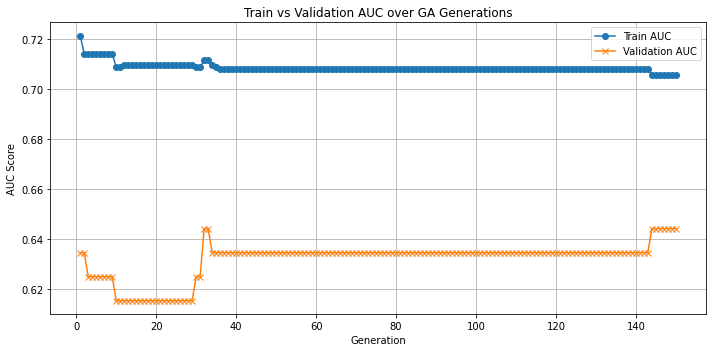

Train AUC Mean: 0.7087
95% CI for Train AUC: [0.7085, 0.7091]
Validation AUC Mean: 0.6321
95% CI for Validation AUC: [0.6307, 0.6331]


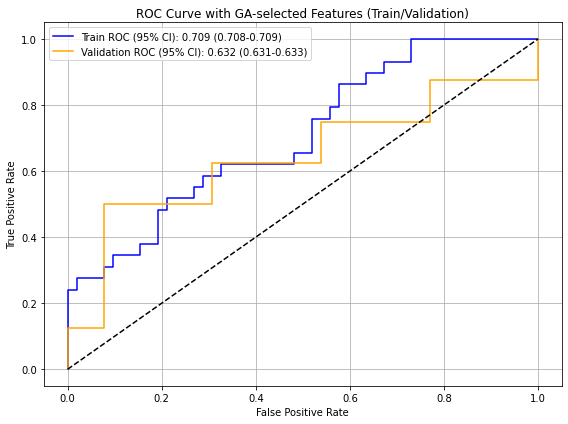

Fold 1 - LogisticRegression: Train AUC=0.7056, Val AUC=0.6442, Features=40

Step 2: Tuning + GA for GaussianNB
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.6741, Features = 42
Generation 20: Best CV AUC = 0.6850, Features = 43
Generation 30: Best CV AUC = 0.6920, Features = 39
Generation 40: Best CV AUC = 0.6983, Features = 37
Generation 50: Best CV AUC = 0.6983, Features = 37
Generation 60: Best CV AUC = 0.6983, Features = 37
Generation 70: Best CV AUC = 0.6983, Features = 37
Generation 80: Best CV AUC = 0.7050, Features = 35
Generation 90: Best CV AUC = 0.7117, Features = 35
Generation 100: Best CV AUC = 0.7117, Features = 35
Generation 110: Best CV AUC = 0.7117, Features = 35
Generation 120: Best CV AUC = 0.7117, Features = 35
Generation 130: Best CV AUC = 0.7117, Features = 35
Generation 140: Best CV AUC = 0.7117, Features = 35
Generation 150: Best CV AUC = 0.7117, Features = 35
GA completed! Best CV AUC: 0.7117
Best solution uses 35 featur

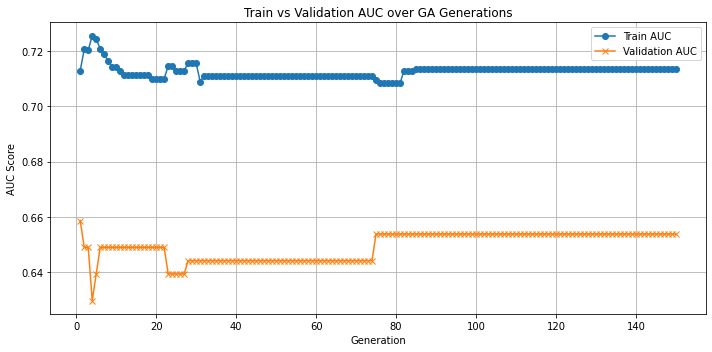

Train AUC Mean: 0.7127
95% CI for Train AUC: [0.7123, 0.7131]
Validation AUC Mean: 0.6495
95% CI for Validation AUC: [0.6487, 0.6503]


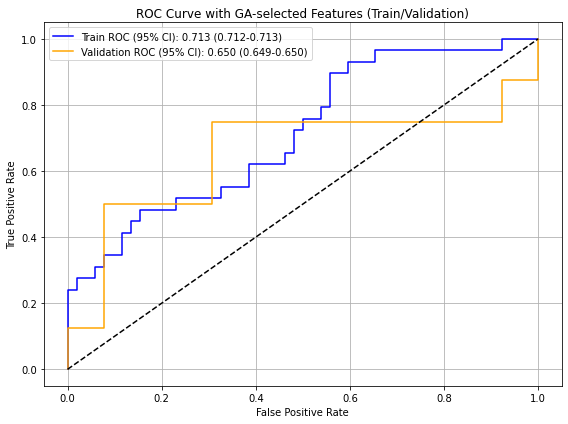

Fold 1 - GaussianNB: Train AUC=0.7135, Val AUC=0.6538, Features=35

Step 2: Tuning + GA for SVC
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.6736, Features = 44
Generation 20: Best CV AUC = 0.6809, Features = 44
Generation 30: Best CV AUC = 0.6809, Features = 44
Generation 40: Best CV AUC = 0.6842, Features = 45
Generation 50: Best CV AUC = 0.6842, Features = 45
Generation 60: Best CV AUC = 0.6842, Features = 45
Generation 70: Best CV AUC = 0.6842, Features = 45
Generation 80: Best CV AUC = 0.6842, Features = 45
Generation 90: Best CV AUC = 0.6842, Features = 45
Generation 100: Best CV AUC = 0.6842, Features = 45
Generation 110: Best CV AUC = 0.6842, Features = 45
Generation 120: Best CV AUC = 0.6842, Features = 45
Generation 130: Best CV AUC = 0.6842, Features = 45
Generation 140: Best CV AUC = 0.6842, Features = 45
Generation 150: Best CV AUC = 0.6842, Features = 45
GA completed! Best CV AUC: 0.6842
Best solution uses 45 features
Selected fea

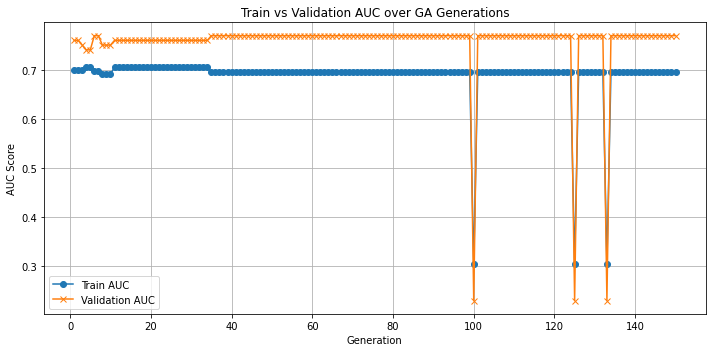

Train AUC Mean: 0.6895
95% CI for Train AUC: [0.6763, 0.6971]
Validation AUC Mean: 0.7559
95% CI for Validation AUC: [0.7375, 0.7661]


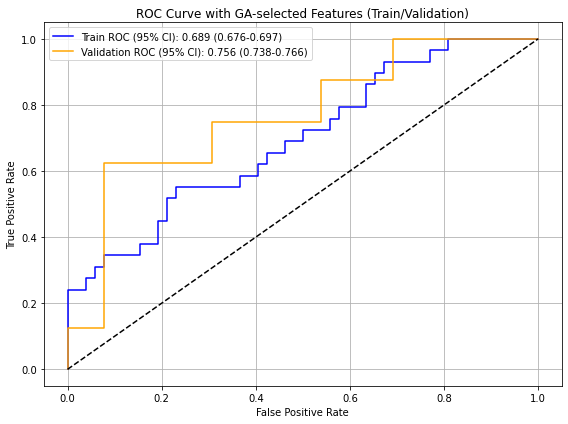

Fold 1 - SVC: Train AUC=0.6953, Val AUC=0.7692, Features=45

Step 2: Tuning + GA for SVC
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.6673, Features = 42
Generation 20: Best CV AUC = 0.6903, Features = 43
Generation 30: Best CV AUC = 0.6903, Features = 43
Generation 40: Best CV AUC = 0.6903, Features = 43
Generation 50: Best CV AUC = 0.6903, Features = 43
Generation 60: Best CV AUC = 0.6903, Features = 43
Generation 70: Best CV AUC = 0.6903, Features = 43
Generation 80: Best CV AUC = 0.6903, Features = 43
Generation 90: Best CV AUC = 0.6903, Features = 43
Generation 100: Best CV AUC = 0.6903, Features = 43
Generation 110: Best CV AUC = 0.6903, Features = 43
Generation 120: Best CV AUC = 0.6903, Features = 43
Generation 130: Best CV AUC = 0.6903, Features = 43
Generation 140: Best CV AUC = 0.6903, Features = 43
Generation 150: Best CV AUC = 0.6903, Features = 43
GA completed! Best CV AUC: 0.6903
Best solution uses 43 features
Selected features c

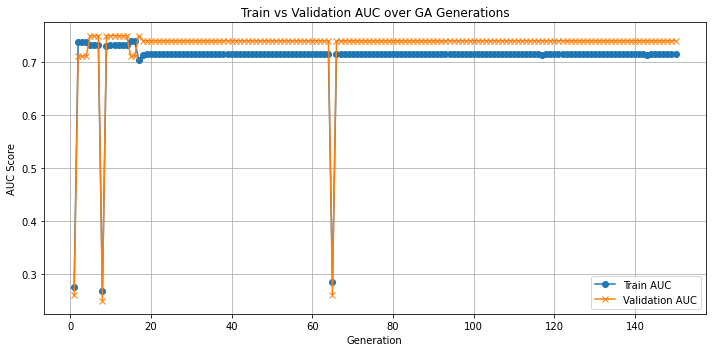

Train AUC Mean: 0.7078
95% CI for Train AUC: [0.6923, 0.7142]
Validation AUC Mean: 0.7304
95% CI for Validation AUC: [0.7136, 0.7374]


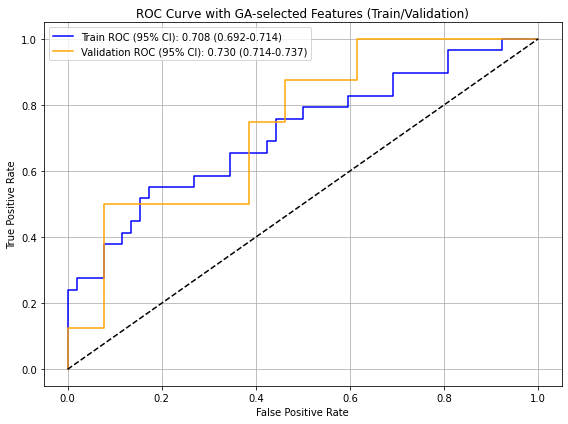

Fold 1 - SVC: Train AUC=0.7149, Val AUC=0.7404, Features=43

Step 2: Tuning + GA for DecisionTreeClassifier
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.7638, Features = 52
Generation 20: Best CV AUC = 0.7638, Features = 52
Generation 30: Best CV AUC = 0.7970, Features = 52
Generation 40: Best CV AUC = 0.7979, Features = 52
Generation 50: Best CV AUC = 0.7979, Features = 52
Generation 60: Best CV AUC = 0.7979, Features = 52
Generation 70: Best CV AUC = 0.7979, Features = 52
Generation 80: Best CV AUC = 0.8142, Features = 52
Generation 90: Best CV AUC = 0.8142, Features = 52
Generation 100: Best CV AUC = 0.8142, Features = 52
Generation 110: Best CV AUC = 0.8142, Features = 52
Generation 120: Best CV AUC = 0.8142, Features = 52
Generation 130: Best CV AUC = 0.8142, Features = 52
Generation 140: Best CV AUC = 0.8142, Features = 52
Generation 150: Best CV AUC = 0.8142, Features = 52
GA completed! Best CV AUC: 0.8142
Best solution uses 52 features


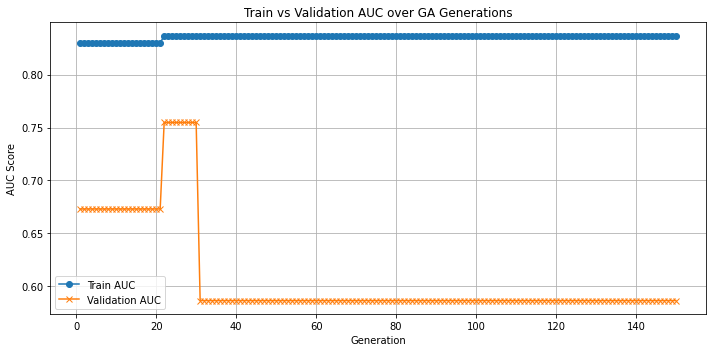

Train AUC Mean: 0.8359
95% CI for Train AUC: [0.8354, 0.8362]
Validation AUC Mean: 0.6088
95% CI for Validation AUC: [0.6020, 0.6173]


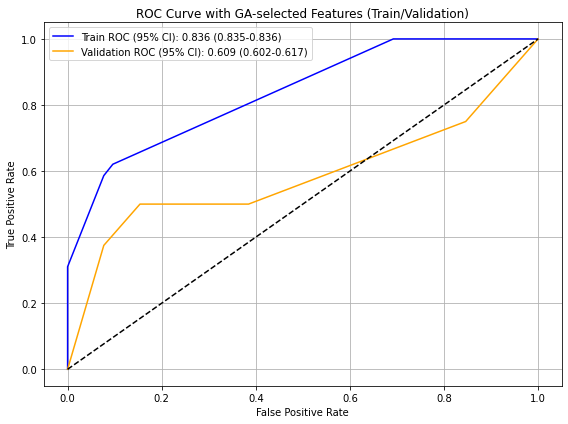

Fold 1 - DecisionTreeClassifier: Train AUC=0.8369, Val AUC=0.5865, Features=52

Step 2: Tuning + GA for RandomForestClassifier
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.6221, Features = 39
Generation 20: Best CV AUC = 0.6258, Features = 39
Generation 30: Best CV AUC = 0.6258, Features = 39
Generation 40: Best CV AUC = 0.6258, Features = 39
Generation 50: Best CV AUC = 0.6258, Features = 39
Generation 60: Best CV AUC = 0.6258, Features = 39
Generation 70: Best CV AUC = 0.6258, Features = 39
Generation 80: Best CV AUC = 0.6258, Features = 39
Generation 90: Best CV AUC = 0.6258, Features = 39
Generation 100: Best CV AUC = 0.6258, Features = 39
Generation 110: Best CV AUC = 0.6258, Features = 39
Generation 120: Best CV AUC = 0.6258, Features = 39
Generation 130: Best CV AUC = 0.6258, Features = 39
Generation 140: Best CV AUC = 0.6258, Features = 39
Generation 150: Best CV AUC = 0.6258, Features = 39
GA completed! Best CV AUC: 0.6258
Best solutio

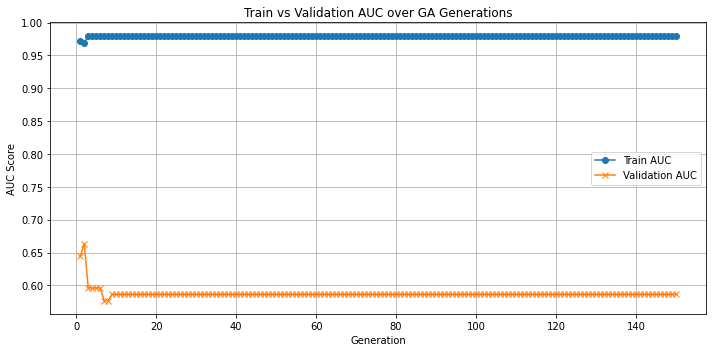

Train AUC Mean: 0.9800
95% CI for Train AUC: [0.9797, 0.9801]
Validation AUC Mean: 0.5876
95% CI for Validation AUC: [0.5867, 0.5893]


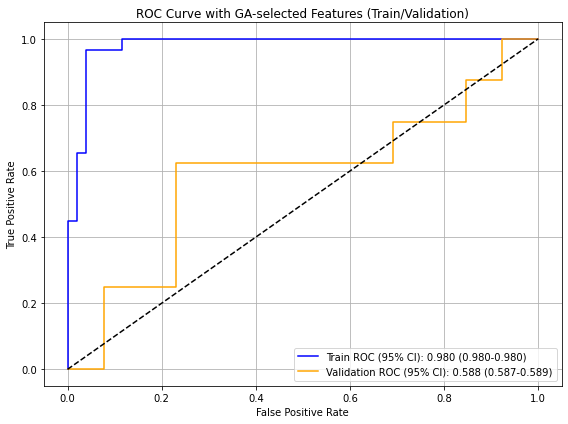

Fold 1 - RandomForestClassifier: Train AUC=0.9801, Val AUC=0.5865, Features=39
Fold 1 total selected features: 97

FOLD 2/5
Step 1: SKIPPING LASSO - Using all 103 features directly

Step 2: Tuning + GA for LogisticRegression
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.6839, Features = 53
Generation 20: Best CV AUC = 0.6839, Features = 53
Generation 30: Best CV AUC = 0.6839, Features = 53
Generation 40: Best CV AUC = 0.6945, Features = 45
Generation 50: Best CV AUC = 0.7055, Features = 42
Generation 60: Best CV AUC = 0.7055, Features = 42
Generation 70: Best CV AUC = 0.7055, Features = 42
Generation 80: Best CV AUC = 0.7055, Features = 42
Generation 90: Best CV AUC = 0.7055, Features = 42
Generation 100: Best CV AUC = 0.7055, Features = 42
Generation 110: Best CV AUC = 0.7055, Features = 42
Generation 120: Best CV AUC = 0.7055, Features = 42
Generation 130: Best CV AUC = 0.7055, Features = 42
Generation 140: Best CV AUC = 0.7055, Features = 42


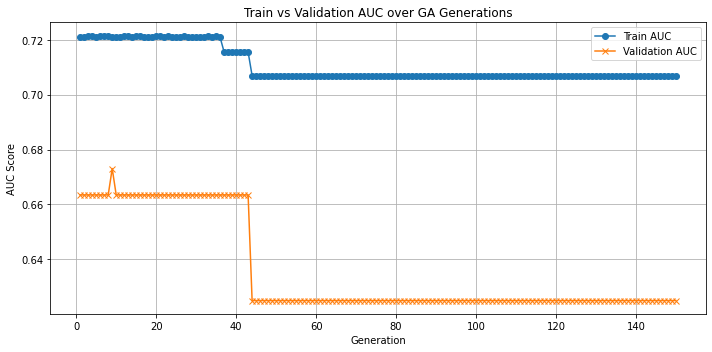

Train AUC Mean: 0.7107
95% CI for Train AUC: [0.7098, 0.7118]
Validation AUC Mean: 0.6361
95% CI for Validation AUC: [0.6335, 0.6389]


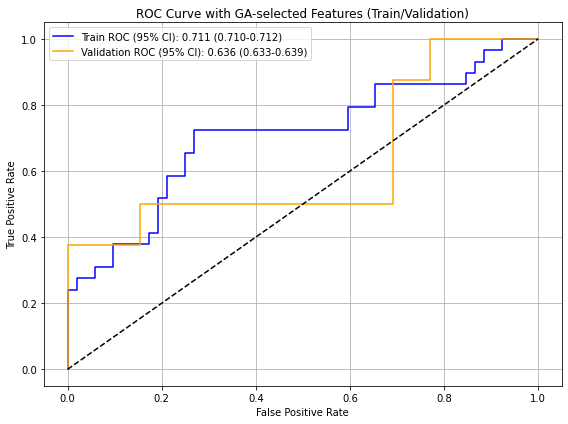

Fold 2 - LogisticRegression: Train AUC=0.7069, Val AUC=0.6250, Features=42

Step 2: Tuning + GA for GaussianNB
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.6827, Features = 39
Generation 20: Best CV AUC = 0.6994, Features = 35
Generation 30: Best CV AUC = 0.7064, Features = 32
Generation 40: Best CV AUC = 0.7197, Features = 33
Generation 50: Best CV AUC = 0.7261, Features = 35
Generation 60: Best CV AUC = 0.7261, Features = 35
Generation 70: Best CV AUC = 0.7261, Features = 35
Generation 80: Best CV AUC = 0.7261, Features = 35
Generation 90: Best CV AUC = 0.7261, Features = 35
Generation 100: Best CV AUC = 0.7261, Features = 35
Generation 110: Best CV AUC = 0.7261, Features = 35
Generation 120: Best CV AUC = 0.7261, Features = 35
Generation 130: Best CV AUC = 0.7261, Features = 35
Generation 140: Best CV AUC = 0.7261, Features = 35
Generation 150: Best CV AUC = 0.7261, Features = 35
GA completed! Best CV AUC: 0.7261
Best solution uses 35 featur

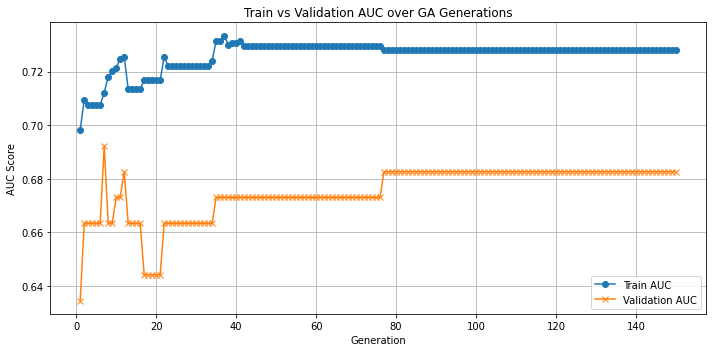

Train AUC Mean: 0.7261
95% CI for Train AUC: [0.7251, 0.7269]
Validation AUC Mean: 0.6753
95% CI for Validation AUC: [0.6733, 0.6765]


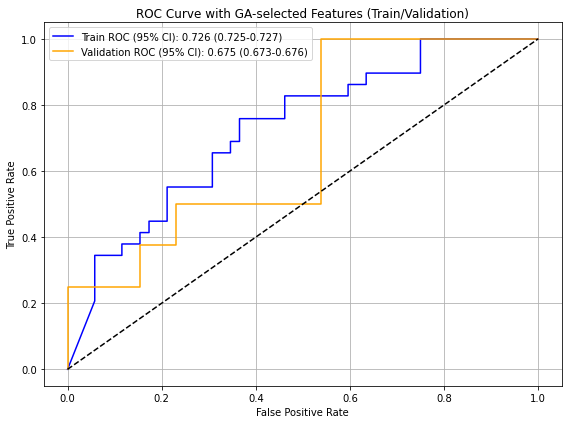

Fold 2 - GaussianNB: Train AUC=0.7281, Val AUC=0.6827, Features=35

Step 2: Tuning + GA for SVC
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.7015, Features = 58
Generation 20: Best CV AUC = 0.7048, Features = 58
Generation 30: Best CV AUC = 0.7048, Features = 58
Generation 40: Best CV AUC = 0.7048, Features = 58
Generation 50: Best CV AUC = 0.7048, Features = 58
Generation 60: Best CV AUC = 0.7048, Features = 58
Generation 70: Best CV AUC = 0.7048, Features = 58
Generation 80: Best CV AUC = 0.7048, Features = 58
Generation 90: Best CV AUC = 0.7048, Features = 58
Generation 100: Best CV AUC = 0.7048, Features = 58
Generation 110: Best CV AUC = 0.7048, Features = 58
Generation 120: Best CV AUC = 0.7048, Features = 58
Generation 130: Best CV AUC = 0.7048, Features = 58
Generation 140: Best CV AUC = 0.7048, Features = 58
Generation 150: Best CV AUC = 0.7048, Features = 58
GA completed! Best CV AUC: 0.7048
Best solution uses 58 features
Selected fea

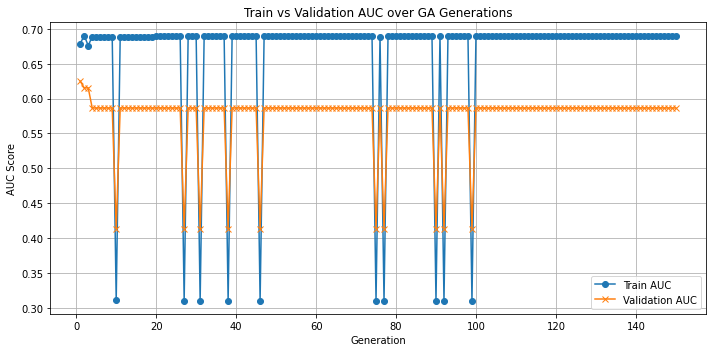

Train AUC Mean: 0.6641
95% CI for Train AUC: [0.6439, 0.6769]
Validation AUC Mean: 0.5756
95% CI for Validation AUC: [0.5664, 0.5815]


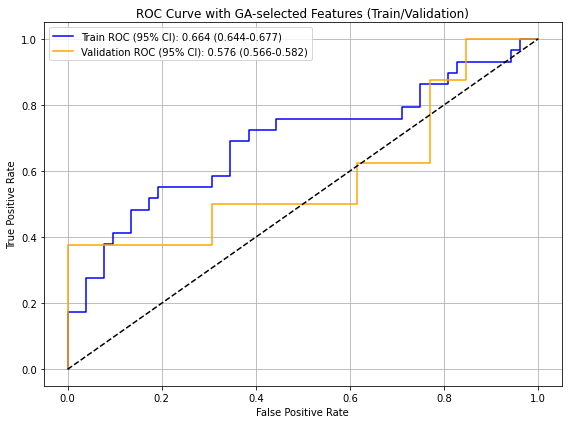

Fold 2 - SVC: Train AUC=0.6897, Val AUC=0.5865, Features=58

Step 2: Tuning + GA for SVC
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.6906, Features = 42
Generation 20: Best CV AUC = 0.6976, Features = 40
Generation 30: Best CV AUC = 0.6976, Features = 40
Generation 40: Best CV AUC = 0.6976, Features = 40
Generation 50: Best CV AUC = 0.6976, Features = 40
Generation 60: Best CV AUC = 0.6976, Features = 40
Generation 70: Best CV AUC = 0.6976, Features = 40
Generation 80: Best CV AUC = 0.6976, Features = 40
Generation 90: Best CV AUC = 0.6976, Features = 40
Generation 100: Best CV AUC = 0.6976, Features = 40
Generation 110: Best CV AUC = 0.6976, Features = 40
Generation 120: Best CV AUC = 0.6976, Features = 40
Generation 130: Best CV AUC = 0.6976, Features = 40
Generation 140: Best CV AUC = 0.6997, Features = 39
Generation 150: Best CV AUC = 0.7003, Features = 40
GA completed! Best CV AUC: 0.7003
Best solution uses 40 features
Selected features c

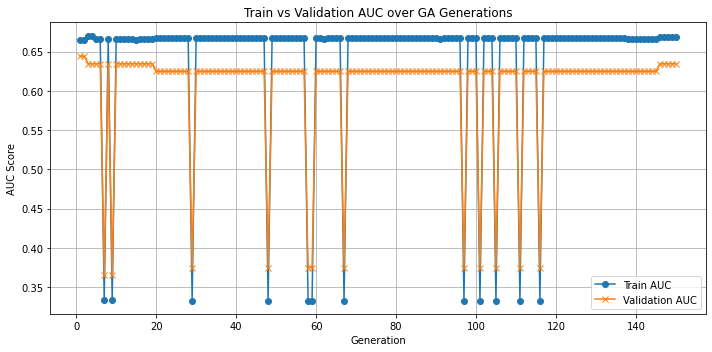

Train AUC Mean: 0.6403
95% CI for Train AUC: [0.6207, 0.6515]
Validation AUC Mean: 0.6064
95% CI for Validation AUC: [0.5912, 0.6149]


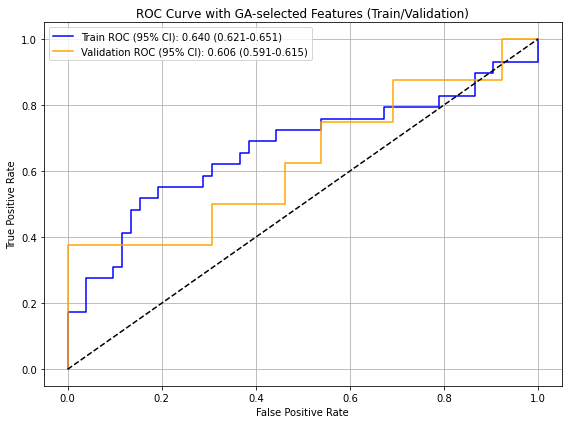

Fold 2 - SVC: Train AUC=0.6691, Val AUC=0.6346, Features=40

Step 2: Tuning + GA for DecisionTreeClassifier
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.7352, Features = 49
Generation 20: Best CV AUC = 0.7352, Features = 49
Generation 30: Best CV AUC = 0.7352, Features = 49
Generation 40: Best CV AUC = 0.7352, Features = 49
Generation 50: Best CV AUC = 0.7352, Features = 49
Generation 60: Best CV AUC = 0.7352, Features = 49
Generation 70: Best CV AUC = 0.7352, Features = 49
Generation 80: Best CV AUC = 0.7352, Features = 49
Generation 90: Best CV AUC = 0.7352, Features = 49
Generation 100: Best CV AUC = 0.7352, Features = 49
Generation 110: Best CV AUC = 0.7967, Features = 49
Generation 120: Best CV AUC = 0.7967, Features = 49
Generation 130: Best CV AUC = 0.7967, Features = 49
Generation 140: Best CV AUC = 0.7967, Features = 49
Generation 150: Best CV AUC = 0.7967, Features = 49
GA completed! Best CV AUC: 0.7967
Best solution uses 49 features


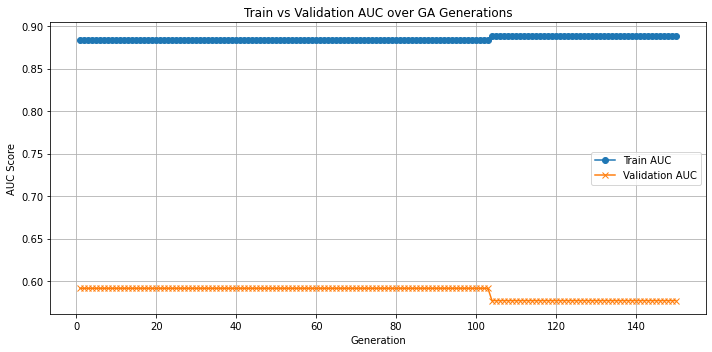

Train AUC Mean: 0.8857
95% CI for Train AUC: [0.8854, 0.8861]
Validation AUC Mean: 0.5868
95% CI for Validation AUC: [0.5857, 0.5878]


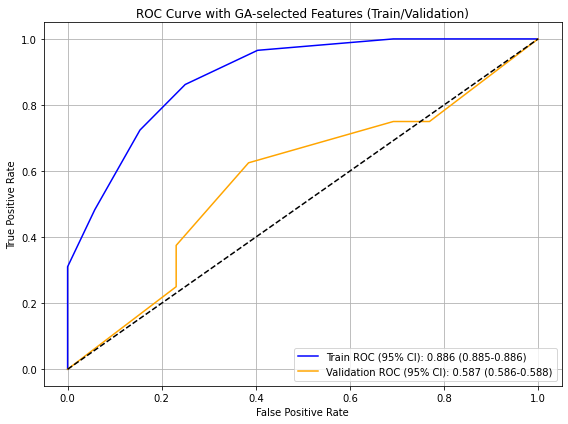

Fold 2 - DecisionTreeClassifier: Train AUC=0.8889, Val AUC=0.5769, Features=49

Step 2: Tuning + GA for RandomForestClassifier
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.6348, Features = 46
Generation 20: Best CV AUC = 0.6352, Features = 46
Generation 30: Best CV AUC = 0.6442, Features = 46
Generation 40: Best CV AUC = 0.6476, Features = 46
Generation 50: Best CV AUC = 0.6476, Features = 46
Generation 60: Best CV AUC = 0.6476, Features = 46
Generation 70: Best CV AUC = 0.6476, Features = 46
Generation 80: Best CV AUC = 0.6476, Features = 46
Generation 90: Best CV AUC = 0.6476, Features = 46
Generation 100: Best CV AUC = 0.6476, Features = 46
Generation 110: Best CV AUC = 0.6476, Features = 46
Generation 120: Best CV AUC = 0.6476, Features = 46
Generation 130: Best CV AUC = 0.6476, Features = 46
Generation 140: Best CV AUC = 0.6476, Features = 46
Generation 150: Best CV AUC = 0.6476, Features = 46
GA completed! Best CV AUC: 0.6476
Best solutio

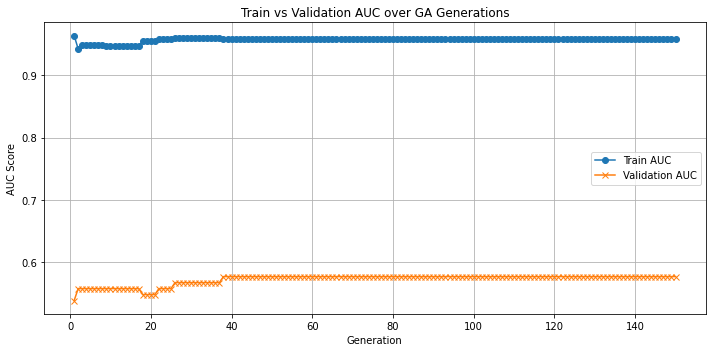

Train AUC Mean: 0.9576
95% CI for Train AUC: [0.9568, 0.9582]
Validation AUC Mean: 0.5726
95% CI for Validation AUC: [0.5709, 0.5737]


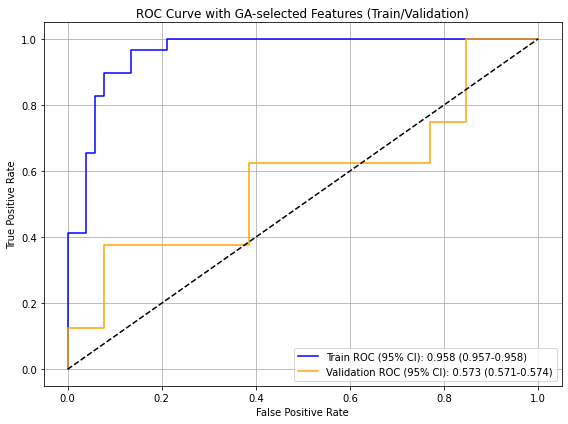

Fold 2 - RandomForestClassifier: Train AUC=0.9589, Val AUC=0.5769, Features=46
Fold 2 total selected features: 99

FOLD 3/5
Step 1: SKIPPING LASSO - Using all 103 features directly

Step 2: Tuning + GA for LogisticRegression
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.6888, Features = 54
Generation 20: Best CV AUC = 0.6891, Features = 53
Generation 30: Best CV AUC = 0.6921, Features = 51
Generation 40: Best CV AUC = 0.6921, Features = 51
Generation 50: Best CV AUC = 0.6921, Features = 51
Generation 60: Best CV AUC = 0.6921, Features = 51
Generation 70: Best CV AUC = 0.6952, Features = 46
Generation 80: Best CV AUC = 0.6982, Features = 43
Generation 90: Best CV AUC = 0.7042, Features = 45
Generation 100: Best CV AUC = 0.7042, Features = 45
Generation 110: Best CV AUC = 0.7042, Features = 45
Generation 120: Best CV AUC = 0.7042, Features = 45
Generation 130: Best CV AUC = 0.7042, Features = 45
Generation 140: Best CV AUC = 0.7042, Features = 45


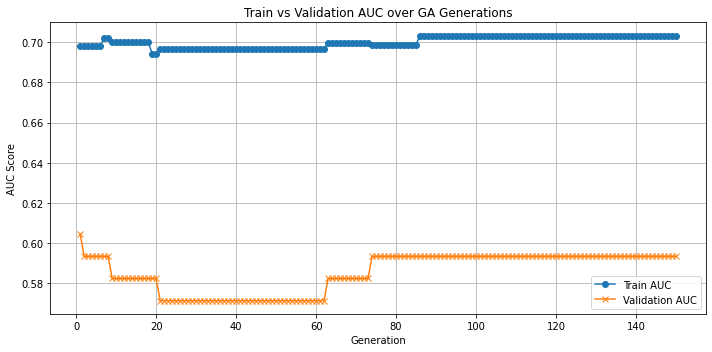

Train AUC Mean: 0.7002
95% CI for Train AUC: [0.6998, 0.7006]
Validation AUC Mean: 0.5856
95% CI for Validation AUC: [0.5839, 0.5869]


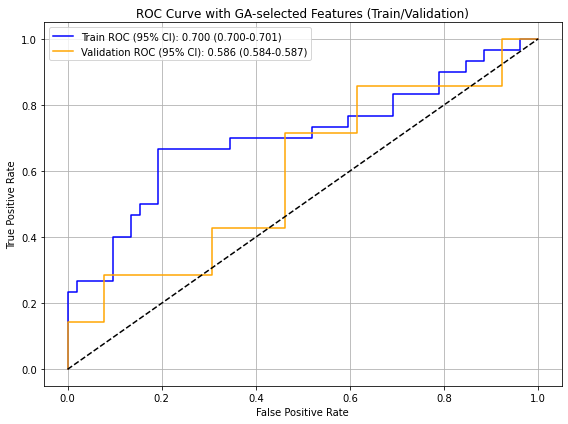

Fold 3 - LogisticRegression: Train AUC=0.7032, Val AUC=0.5934, Features=45

Step 2: Tuning + GA for GaussianNB
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.6795, Features = 44
Generation 20: Best CV AUC = 0.7239, Features = 41
Generation 30: Best CV AUC = 0.7300, Features = 39
Generation 40: Best CV AUC = 0.7333, Features = 38
Generation 50: Best CV AUC = 0.7333, Features = 38
Generation 60: Best CV AUC = 0.7367, Features = 35
Generation 70: Best CV AUC = 0.7400, Features = 34
Generation 80: Best CV AUC = 0.7400, Features = 34
Generation 90: Best CV AUC = 0.7400, Features = 34
Generation 100: Best CV AUC = 0.7430, Features = 32
Generation 110: Best CV AUC = 0.7430, Features = 32
Generation 120: Best CV AUC = 0.7430, Features = 32
Generation 130: Best CV AUC = 0.7430, Features = 32
Generation 140: Best CV AUC = 0.7430, Features = 32
Generation 150: Best CV AUC = 0.7430, Features = 32
GA completed! Best CV AUC: 0.7430
Best solution uses 32 featur

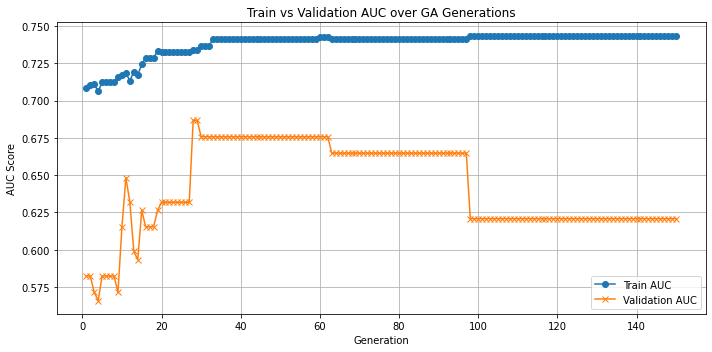

Train AUC Mean: 0.7386
95% CI for Train AUC: [0.7368, 0.7400]
Validation AUC Mean: 0.6420
95% CI for Validation AUC: [0.6372, 0.6470]


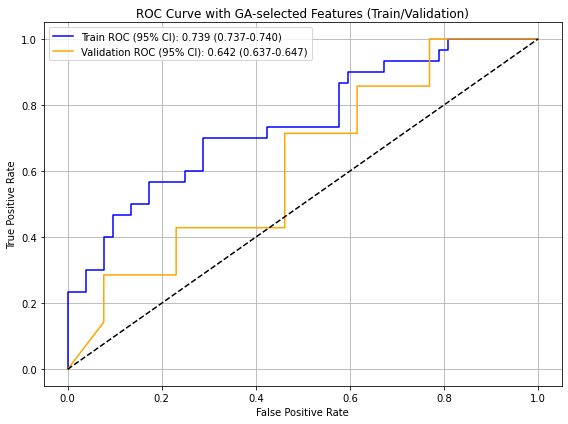

Fold 3 - GaussianNB: Train AUC=0.7436, Val AUC=0.6209, Features=32

Step 2: Tuning + GA for SVC
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.6939, Features = 48
Generation 20: Best CV AUC = 0.6973, Features = 49
Generation 30: Best CV AUC = 0.6973, Features = 49
Generation 40: Best CV AUC = 0.6973, Features = 49
Generation 50: Best CV AUC = 0.6973, Features = 49
Generation 60: Best CV AUC = 0.7042, Features = 45
Generation 70: Best CV AUC = 0.7073, Features = 46
Generation 80: Best CV AUC = 0.7073, Features = 46
Generation 90: Best CV AUC = 0.7073, Features = 46
Generation 100: Best CV AUC = 0.7073, Features = 46
Generation 110: Best CV AUC = 0.7073, Features = 46
Generation 120: Best CV AUC = 0.7073, Features = 46
Generation 130: Best CV AUC = 0.7073, Features = 46
Generation 140: Best CV AUC = 0.7073, Features = 46
Generation 150: Best CV AUC = 0.7073, Features = 46
GA completed! Best CV AUC: 0.7073
Best solution uses 46 features
Selected fea

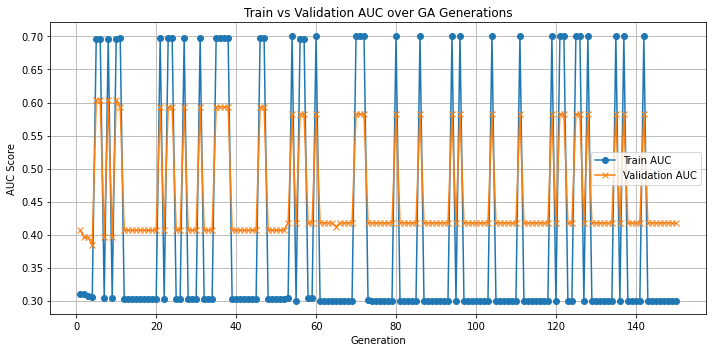

Train AUC Mean: 0.4018
95% CI for Train AUC: [0.3754, 0.4337]
Validation AUC Mean: 0.4577
95% CI for Validation AUC: [0.4462, 0.4717]


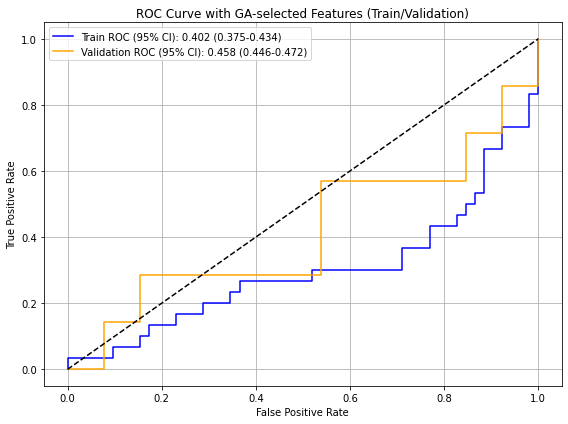

Fold 3 - SVC: Train AUC=0.3000, Val AUC=0.4176, Features=46

Step 2: Tuning + GA for SVC
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.6948, Features = 45
Generation 20: Best CV AUC = 0.6948, Features = 45
Generation 30: Best CV AUC = 0.6948, Features = 45
Generation 40: Best CV AUC = 0.7009, Features = 44
Generation 50: Best CV AUC = 0.7009, Features = 44
Generation 60: Best CV AUC = 0.7009, Features = 44
Generation 70: Best CV AUC = 0.7009, Features = 44
Generation 80: Best CV AUC = 0.7009, Features = 44
Generation 90: Best CV AUC = 0.7009, Features = 44
Generation 100: Best CV AUC = 0.7009, Features = 44
Generation 110: Best CV AUC = 0.7009, Features = 44
Generation 120: Best CV AUC = 0.7009, Features = 44
Generation 130: Best CV AUC = 0.7009, Features = 44
Generation 140: Best CV AUC = 0.7009, Features = 44
Generation 150: Best CV AUC = 0.7009, Features = 44
GA completed! Best CV AUC: 0.7009
Best solution uses 44 features
Selected features c

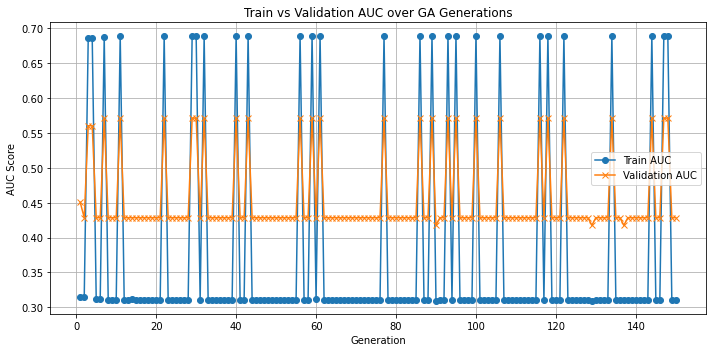

Train AUC Mean: 0.3786
95% CI for Train AUC: [0.3559, 0.4088]
Validation AUC Mean: 0.4541
95% CI for Validation AUC: [0.4456, 0.4652]


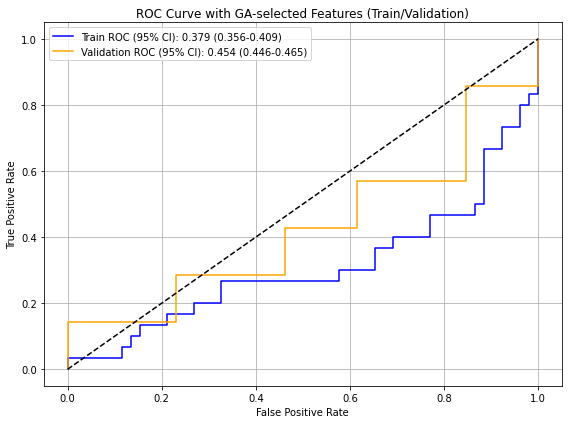

Fold 3 - SVC: Train AUC=0.3115, Val AUC=0.4286, Features=44

Step 2: Tuning + GA for DecisionTreeClassifier
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.7295, Features = 56
Generation 20: Best CV AUC = 0.7503, Features = 56
Generation 30: Best CV AUC = 0.7503, Features = 56
Generation 40: Best CV AUC = 0.7503, Features = 56
Generation 50: Best CV AUC = 0.7658, Features = 56
Generation 60: Best CV AUC = 0.7658, Features = 56
Generation 70: Best CV AUC = 0.7748, Features = 56
Generation 80: Best CV AUC = 0.7748, Features = 56
Generation 90: Best CV AUC = 0.7748, Features = 56
Generation 100: Best CV AUC = 0.7748, Features = 56
Generation 110: Best CV AUC = 0.7748, Features = 56
Generation 120: Best CV AUC = 0.7748, Features = 56
Generation 130: Best CV AUC = 0.7748, Features = 56
Generation 140: Best CV AUC = 0.7748, Features = 56
Generation 150: Best CV AUC = 0.7765, Features = 56
GA completed! Best CV AUC: 0.7765
Best solution uses 56 features


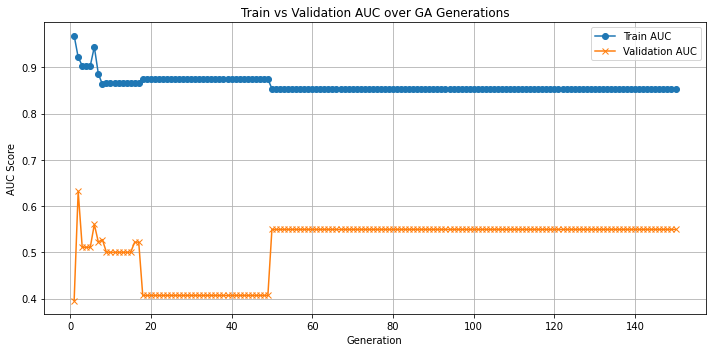

Train AUC Mean: 0.8624
95% CI for Train AUC: [0.8604, 0.8656]
Validation AUC Mean: 0.5148
95% CI for Validation AUC: [0.5050, 0.5230]


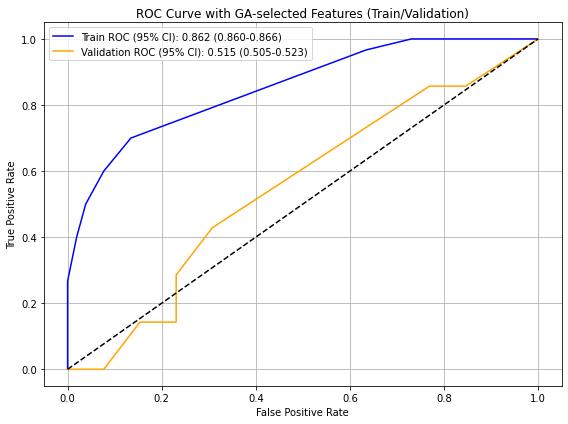

Fold 3 - DecisionTreeClassifier: Train AUC=0.8542, Val AUC=0.5495, Features=56

Step 2: Tuning + GA for RandomForestClassifier
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.6427, Features = 55
Generation 20: Best CV AUC = 0.6467, Features = 55
Generation 30: Best CV AUC = 0.6524, Features = 55
Generation 40: Best CV AUC = 0.6524, Features = 55
Generation 50: Best CV AUC = 0.6536, Features = 55
Generation 60: Best CV AUC = 0.6536, Features = 55
Generation 70: Best CV AUC = 0.6561, Features = 55
Generation 80: Best CV AUC = 0.6591, Features = 55
Generation 90: Best CV AUC = 0.6591, Features = 55
Generation 100: Best CV AUC = 0.6591, Features = 55
Generation 110: Best CV AUC = 0.6591, Features = 55
Generation 120: Best CV AUC = 0.6615, Features = 55
Generation 130: Best CV AUC = 0.6645, Features = 55
Generation 140: Best CV AUC = 0.6645, Features = 55
Generation 150: Best CV AUC = 0.6645, Features = 55
GA completed! Best CV AUC: 0.6645
Best solutio

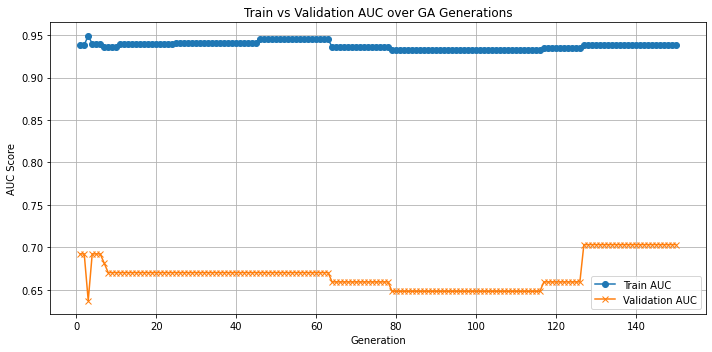

Train AUC Mean: 0.9378
95% CI for Train AUC: [0.9372, 0.9385]
Validation AUC Mean: 0.6688
95% CI for Validation AUC: [0.6659, 0.6716]


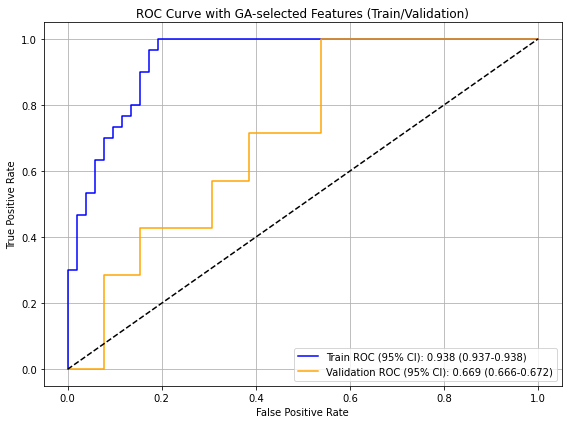

Fold 3 - RandomForestClassifier: Train AUC=0.9385, Val AUC=0.7033, Features=55
Fold 3 total selected features: 98

FOLD 4/5
Step 1: SKIPPING LASSO - Using all 103 features directly

Step 2: Tuning + GA for LogisticRegression
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.6991, Features = 45
Generation 20: Best CV AUC = 0.7055, Features = 38
Generation 30: Best CV AUC = 0.7055, Features = 38
Generation 40: Best CV AUC = 0.7085, Features = 42
Generation 50: Best CV AUC = 0.7085, Features = 42
Generation 60: Best CV AUC = 0.7085, Features = 42
Generation 70: Best CV AUC = 0.7085, Features = 42
Generation 80: Best CV AUC = 0.7085, Features = 42
Generation 90: Best CV AUC = 0.7085, Features = 42
Generation 100: Best CV AUC = 0.7085, Features = 42
Generation 110: Best CV AUC = 0.7085, Features = 42
Generation 120: Best CV AUC = 0.7085, Features = 42
Generation 130: Best CV AUC = 0.7085, Features = 42
Generation 140: Best CV AUC = 0.7085, Features = 42


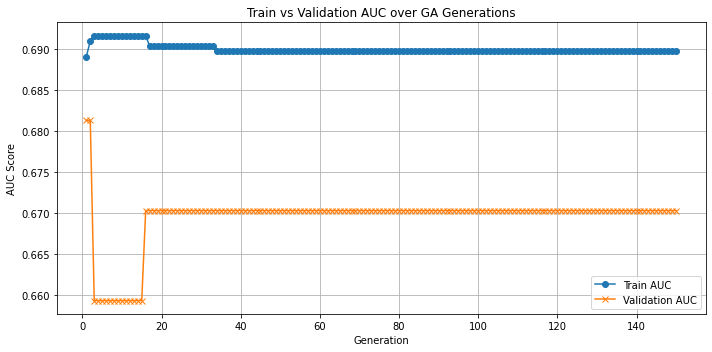

Train AUC Mean: 0.6900
95% CI for Train AUC: [0.6899, 0.6901]
Validation AUC Mean: 0.6695
95% CI for Validation AUC: [0.6689, 0.6700]


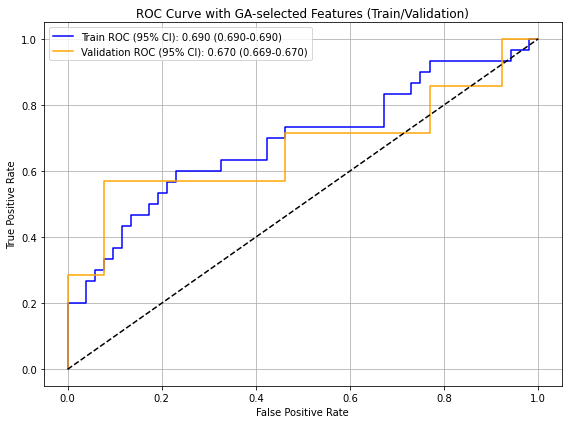

Fold 4 - LogisticRegression: Train AUC=0.6897, Val AUC=0.6703, Features=42

Step 2: Tuning + GA for GaussianNB
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.7321, Features = 39
Generation 20: Best CV AUC = 0.7852, Features = 35
Generation 30: Best CV AUC = 0.7945, Features = 32
Generation 40: Best CV AUC = 0.7945, Features = 32
Generation 50: Best CV AUC = 0.7982, Features = 30
Generation 60: Best CV AUC = 0.7982, Features = 30
Generation 70: Best CV AUC = 0.7982, Features = 30
Generation 80: Best CV AUC = 0.7982, Features = 30
Generation 90: Best CV AUC = 0.7982, Features = 30
Generation 100: Best CV AUC = 0.7982, Features = 30
Generation 110: Best CV AUC = 0.7982, Features = 30
Generation 120: Best CV AUC = 0.8012, Features = 30
Generation 130: Best CV AUC = 0.8012, Features = 30
Generation 140: Best CV AUC = 0.8012, Features = 30
Generation 150: Best CV AUC = 0.8036, Features = 29
GA completed! Best CV AUC: 0.8036
Best solution uses 29 featur

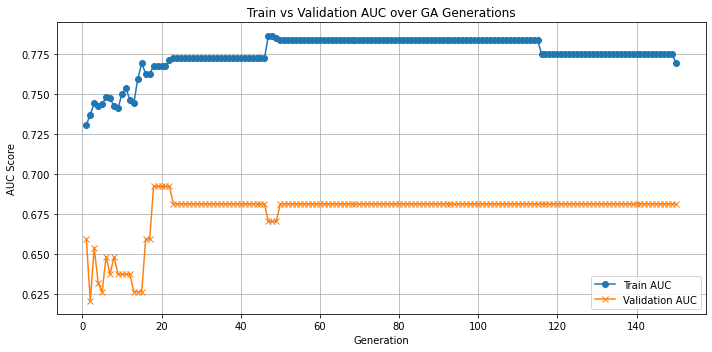

Train AUC Mean: 0.7755
95% CI for Train AUC: [0.7734, 0.7773]
Validation AUC Mean: 0.6767
95% CI for Validation AUC: [0.6741, 0.6789]


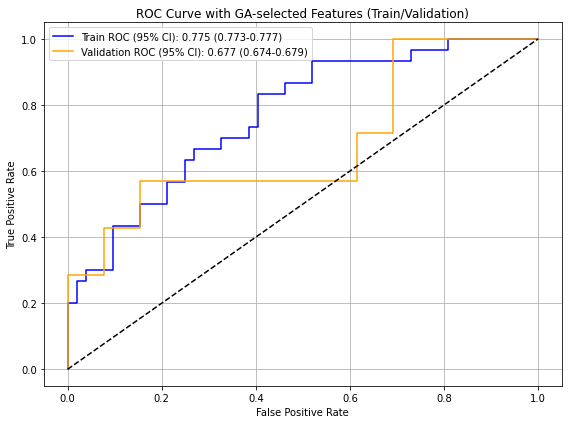

Fold 4 - GaussianNB: Train AUC=0.7692, Val AUC=0.6813, Features=29

Step 2: Tuning + GA for SVC
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.7582, Features = 49
Generation 20: Best CV AUC = 0.7582, Features = 49
Generation 30: Best CV AUC = 0.7582, Features = 49
Generation 40: Best CV AUC = 0.7615, Features = 50
Generation 50: Best CV AUC = 0.7615, Features = 50
Generation 60: Best CV AUC = 0.7645, Features = 48
Generation 70: Best CV AUC = 0.7645, Features = 48
Generation 80: Best CV AUC = 0.7645, Features = 48
Generation 90: Best CV AUC = 0.7645, Features = 48
Generation 100: Best CV AUC = 0.7645, Features = 48
Generation 110: Best CV AUC = 0.7645, Features = 48
Generation 120: Best CV AUC = 0.7645, Features = 48
Generation 130: Best CV AUC = 0.7645, Features = 48
Generation 140: Best CV AUC = 0.7645, Features = 48
Generation 150: Best CV AUC = 0.7673, Features = 45
GA completed! Best CV AUC: 0.7673
Best solution uses 45 features
Selected fea

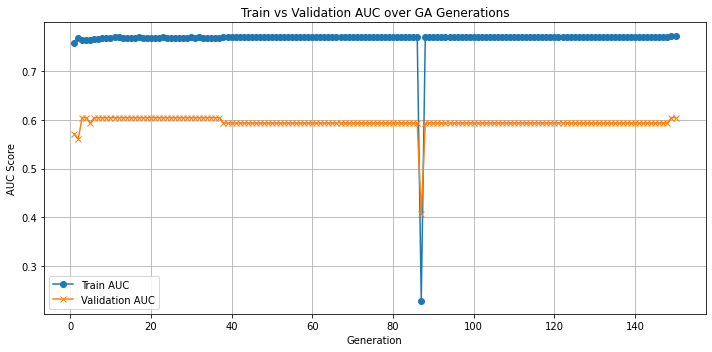

Train AUC Mean: 0.7661
95% CI for Train AUC: [0.7474, 0.7698]
Validation AUC Mean: 0.5944
95% CI for Validation AUC: [0.5886, 0.5960]


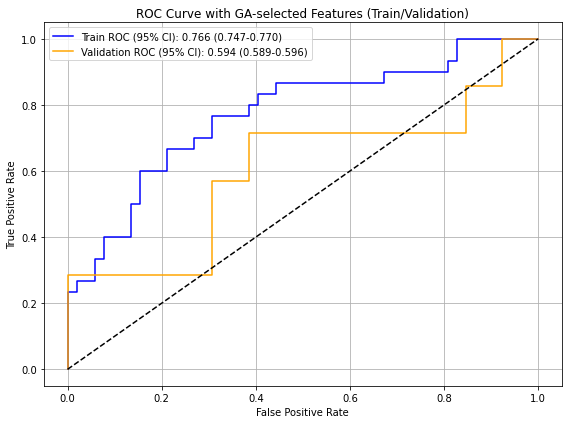

Fold 4 - SVC: Train AUC=0.7724, Val AUC=0.6044, Features=45

Step 2: Tuning + GA for SVC
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.7533, Features = 57
Generation 20: Best CV AUC = 0.7533, Features = 57
Generation 30: Best CV AUC = 0.7533, Features = 57
Generation 40: Best CV AUC = 0.7533, Features = 57
Generation 50: Best CV AUC = 0.7758, Features = 48
Generation 60: Best CV AUC = 0.7818, Features = 47
Generation 70: Best CV AUC = 0.7818, Features = 47
Generation 80: Best CV AUC = 0.7848, Features = 45
Generation 90: Best CV AUC = 0.7848, Features = 45
Generation 100: Best CV AUC = 0.7848, Features = 45
Generation 110: Best CV AUC = 0.7848, Features = 45
Generation 120: Best CV AUC = 0.7848, Features = 45
Generation 130: Best CV AUC = 0.7848, Features = 45
Generation 140: Best CV AUC = 0.7848, Features = 45
Generation 150: Best CV AUC = 0.7882, Features = 46
GA completed! Best CV AUC: 0.7882
Best solution uses 46 features
Selected features c

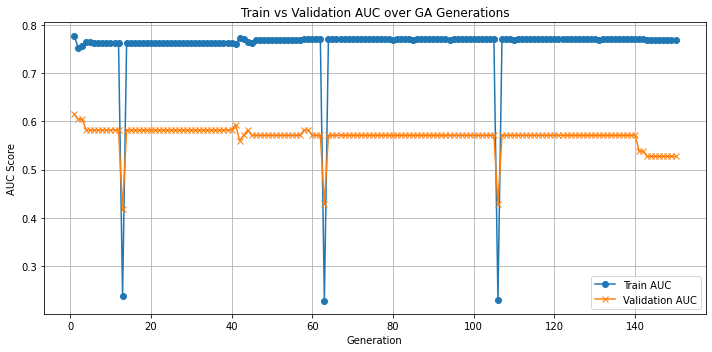

Train AUC Mean: 0.7576
95% CI for Train AUC: [0.7394, 0.7652]
Validation AUC Mean: 0.5694
95% CI for Validation AUC: [0.5640, 0.5725]


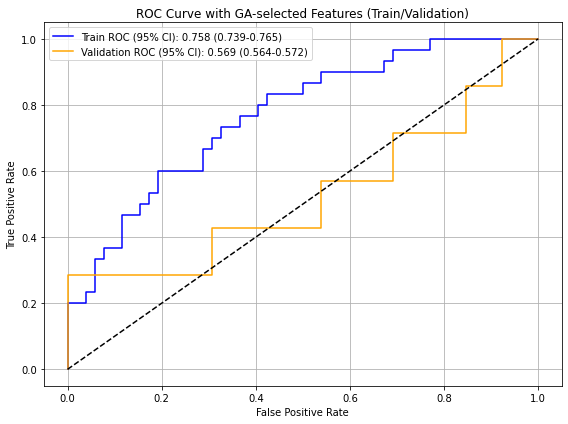

Fold 4 - SVC: Train AUC=0.7692, Val AUC=0.5275, Features=46

Step 2: Tuning + GA for DecisionTreeClassifier
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.7242, Features = 48
Generation 20: Best CV AUC = 0.7242, Features = 48
Generation 30: Best CV AUC = 0.7242, Features = 48
Generation 40: Best CV AUC = 0.7242, Features = 48
Generation 50: Best CV AUC = 0.7242, Features = 48
Generation 60: Best CV AUC = 0.7242, Features = 48
Generation 70: Best CV AUC = 0.7242, Features = 48
Generation 80: Best CV AUC = 0.7242, Features = 48
Generation 90: Best CV AUC = 0.7242, Features = 48
Generation 100: Best CV AUC = 0.7242, Features = 48
Generation 110: Best CV AUC = 0.7242, Features = 48
Generation 120: Best CV AUC = 0.7242, Features = 48
Generation 130: Best CV AUC = 0.7242, Features = 48
Generation 140: Best CV AUC = 0.7242, Features = 48
Generation 150: Best CV AUC = 0.7242, Features = 48
GA completed! Best CV AUC: 0.7242
Best solution uses 48 features


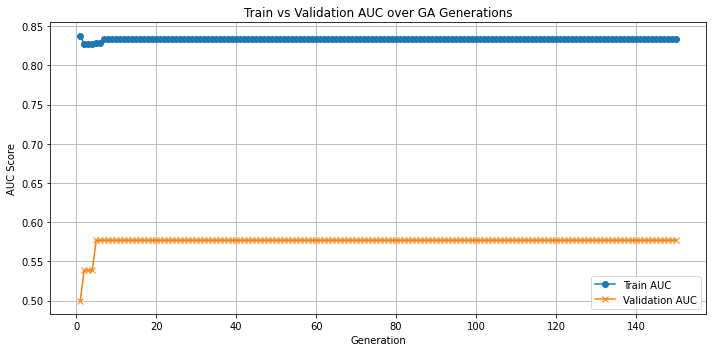

Train AUC Mean: 0.8338
95% CI for Train AUC: [0.8335, 0.8339]
Validation AUC Mean: 0.5756
95% CI for Validation AUC: [0.5734, 0.5764]


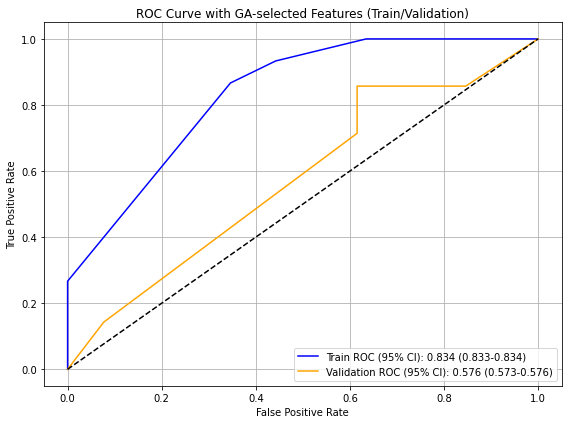

Fold 4 - DecisionTreeClassifier: Train AUC=0.8340, Val AUC=0.5769, Features=48

Step 2: Tuning + GA for RandomForestClassifier
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.6376, Features = 55
Generation 20: Best CV AUC = 0.6379, Features = 55
Generation 30: Best CV AUC = 0.6409, Features = 55
Generation 40: Best CV AUC = 0.6506, Features = 55
Generation 50: Best CV AUC = 0.6506, Features = 55
Generation 60: Best CV AUC = 0.6506, Features = 55
Generation 70: Best CV AUC = 0.6506, Features = 55
Generation 80: Best CV AUC = 0.6506, Features = 55
Generation 90: Best CV AUC = 0.6506, Features = 55
Generation 100: Best CV AUC = 0.6506, Features = 55
Generation 110: Best CV AUC = 0.6506, Features = 55
Generation 120: Best CV AUC = 0.6506, Features = 55
Generation 130: Best CV AUC = 0.6603, Features = 55
Generation 140: Best CV AUC = 0.6603, Features = 55
Generation 150: Best CV AUC = 0.6603, Features = 55
GA completed! Best CV AUC: 0.6603
Best solutio

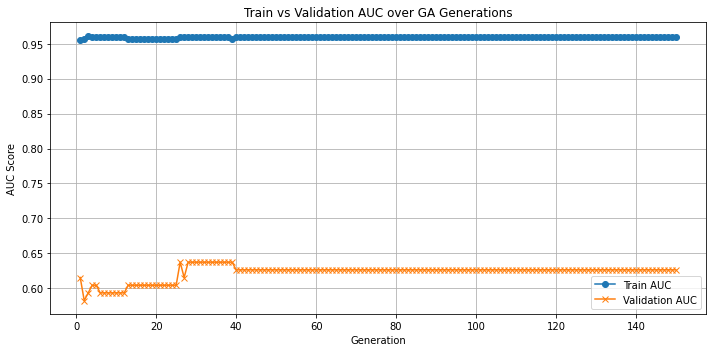

Train AUC Mean: 0.9595
95% CI for Train AUC: [0.9593, 0.9596]
Validation AUC Mean: 0.6229
95% CI for Validation AUC: [0.6208, 0.6246]


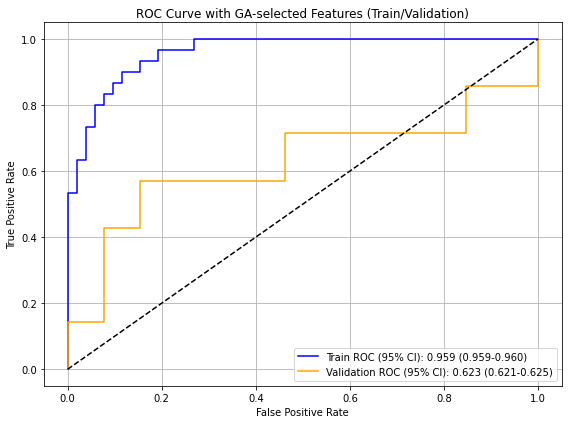

Fold 4 - RandomForestClassifier: Train AUC=0.9603, Val AUC=0.6264, Features=55
Fold 4 total selected features: 97

FOLD 5/5
Step 1: SKIPPING LASSO - Using all 103 features directly

Step 2: Tuning + GA for LogisticRegression
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.6909, Features = 54
Generation 20: Best CV AUC = 0.6909, Features = 54
Generation 30: Best CV AUC = 0.6909, Features = 54
Generation 40: Best CV AUC = 0.6942, Features = 53
Generation 50: Best CV AUC = 0.6942, Features = 53
Generation 60: Best CV AUC = 0.6942, Features = 53
Generation 70: Best CV AUC = 0.6942, Features = 47
Generation 80: Best CV AUC = 0.6973, Features = 47
Generation 90: Best CV AUC = 0.6973, Features = 47
Generation 100: Best CV AUC = 0.6973, Features = 47
Generation 110: Best CV AUC = 0.6973, Features = 47
Generation 120: Best CV AUC = 0.6973, Features = 47
Generation 130: Best CV AUC = 0.6973, Features = 47
Generation 140: Best CV AUC = 0.6973, Features = 47


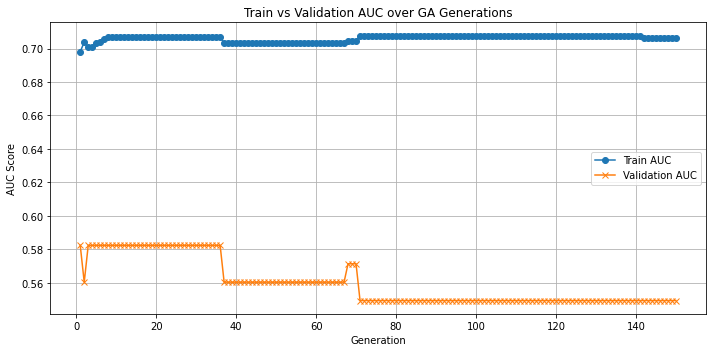

Train AUC Mean: 0.7062
95% CI for Train AUC: [0.7059, 0.7065]
Validation AUC Mean: 0.5599
95% CI for Validation AUC: [0.5579, 0.5621]


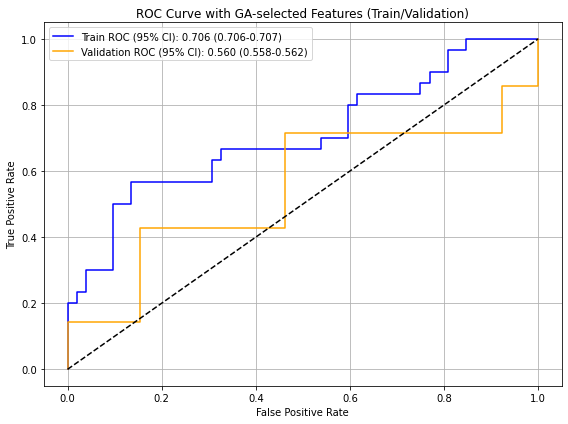

Fold 5 - LogisticRegression: Train AUC=0.7064, Val AUC=0.5495, Features=50

Step 2: Tuning + GA for GaussianNB
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.7030, Features = 39
Generation 20: Best CV AUC = 0.7458, Features = 32
Generation 30: Best CV AUC = 0.7548, Features = 31
Generation 40: Best CV AUC = 0.7685, Features = 28
Generation 50: Best CV AUC = 0.7909, Features = 23
Generation 60: Best CV AUC = 0.7909, Features = 23
Generation 70: Best CV AUC = 0.7909, Features = 23
Generation 80: Best CV AUC = 0.7909, Features = 23
Generation 90: Best CV AUC = 0.7909, Features = 23
Generation 100: Best CV AUC = 0.7909, Features = 23
Generation 110: Best CV AUC = 0.7909, Features = 23
Generation 120: Best CV AUC = 0.7909, Features = 23
Generation 130: Best CV AUC = 0.7967, Features = 21
Generation 140: Best CV AUC = 0.8000, Features = 20
Generation 150: Best CV AUC = 0.8030, Features = 21
GA completed! Best CV AUC: 0.8030
Best solution uses 21 featur

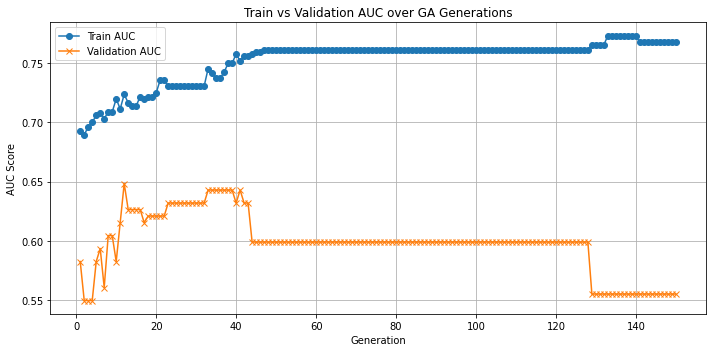

Train AUC Mean: 0.7524
95% CI for Train AUC: [0.7486, 0.7550]
Validation AUC Mean: 0.5981
95% CI for Validation AUC: [0.5940, 0.6016]


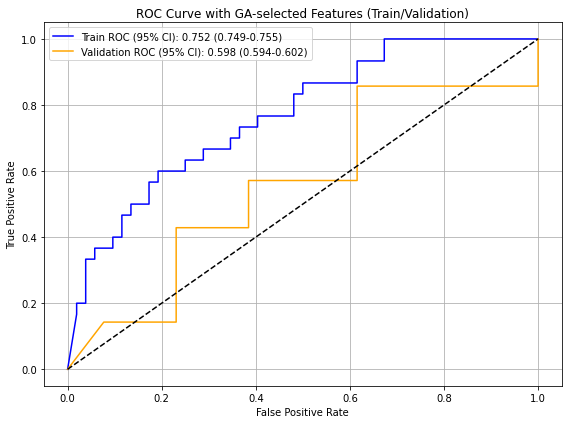

Fold 5 - GaussianNB: Train AUC=0.7676, Val AUC=0.5549, Features=21

Step 2: Tuning + GA for SVC
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.6906, Features = 52
Generation 20: Best CV AUC = 0.6906, Features = 52
Generation 30: Best CV AUC = 0.6906, Features = 52
Generation 40: Best CV AUC = 0.6906, Features = 52
Generation 50: Best CV AUC = 0.6906, Features = 52
Generation 60: Best CV AUC = 0.6906, Features = 52
Generation 70: Best CV AUC = 0.6906, Features = 52
Generation 80: Best CV AUC = 0.6906, Features = 52
Generation 90: Best CV AUC = 0.6906, Features = 52
Generation 100: Best CV AUC = 0.6906, Features = 52
Generation 110: Best CV AUC = 0.6964, Features = 52
Generation 120: Best CV AUC = 0.7027, Features = 50
Generation 130: Best CV AUC = 0.7094, Features = 51
Generation 140: Best CV AUC = 0.7094, Features = 51
Generation 150: Best CV AUC = 0.7094, Features = 51
GA completed! Best CV AUC: 0.7094
Best solution uses 51 features
Selected fea

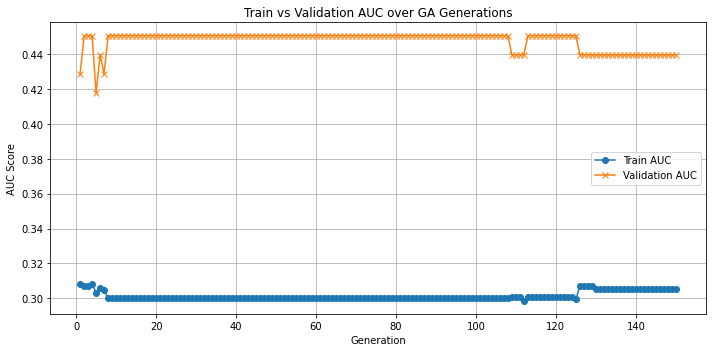

Train AUC Mean: 0.3013
95% CI for Train AUC: [0.3009, 0.3017]
Validation AUC Mean: 0.4478
95% CI for Validation AUC: [0.4467, 0.4485]


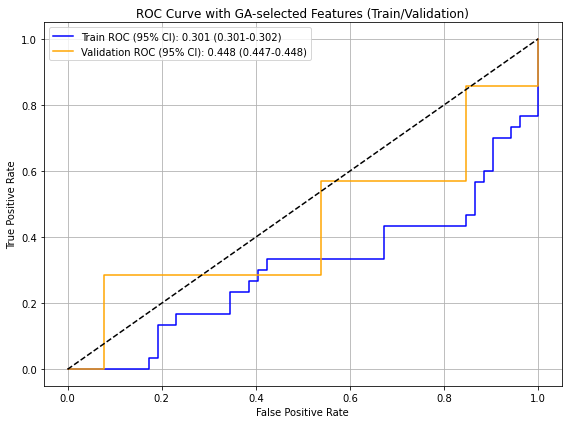

Fold 5 - SVC: Train AUC=0.3051, Val AUC=0.4396, Features=51

Step 2: Tuning + GA for SVC
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.7036, Features = 40
Generation 20: Best CV AUC = 0.7036, Features = 40
Generation 30: Best CV AUC = 0.7036, Features = 40
Generation 40: Best CV AUC = 0.7036, Features = 40
Generation 50: Best CV AUC = 0.7036, Features = 40
Generation 60: Best CV AUC = 0.7036, Features = 40
Generation 70: Best CV AUC = 0.7036, Features = 40
Generation 80: Best CV AUC = 0.7067, Features = 43
Generation 90: Best CV AUC = 0.7067, Features = 43
Generation 100: Best CV AUC = 0.7067, Features = 43
Generation 110: Best CV AUC = 0.7067, Features = 43
Generation 120: Best CV AUC = 0.7067, Features = 43
Generation 130: Best CV AUC = 0.7067, Features = 43
Generation 140: Best CV AUC = 0.7067, Features = 43
Generation 150: Best CV AUC = 0.7067, Features = 43
GA completed! Best CV AUC: 0.7067
Best solution uses 43 features
Selected features c

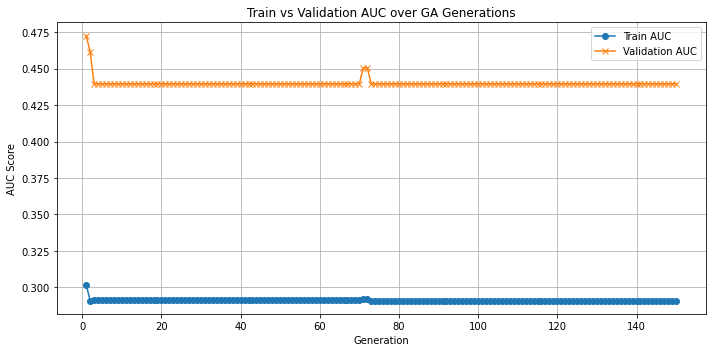

Train AUC Mean: 0.2914
95% CI for Train AUC: [0.2913, 0.2917]
Validation AUC Mean: 0.4401
95% CI for Validation AUC: [0.4397, 0.4409]


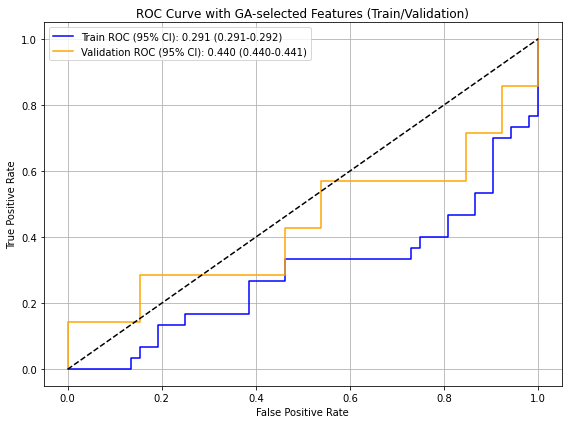

Fold 5 - SVC: Train AUC=0.2910, Val AUC=0.4396, Features=43

Step 2: Tuning + GA for DecisionTreeClassifier
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.6867, Features = 49
Generation 20: Best CV AUC = 0.6867, Features = 49
Generation 30: Best CV AUC = 0.6867, Features = 49
Generation 40: Best CV AUC = 0.6867, Features = 49
Generation 50: Best CV AUC = 0.6867, Features = 49
Generation 60: Best CV AUC = 0.6867, Features = 49
Generation 70: Best CV AUC = 0.6867, Features = 49
Generation 80: Best CV AUC = 0.6867, Features = 49
Generation 90: Best CV AUC = 0.6867, Features = 49
Generation 100: Best CV AUC = 0.6867, Features = 49
Generation 110: Best CV AUC = 0.6867, Features = 49
Generation 120: Best CV AUC = 0.6867, Features = 49
Generation 130: Best CV AUC = 0.6867, Features = 49
Generation 140: Best CV AUC = 0.6867, Features = 49
Generation 150: Best CV AUC = 0.6867, Features = 49
GA completed! Best CV AUC: 0.6867
Best solution uses 49 features


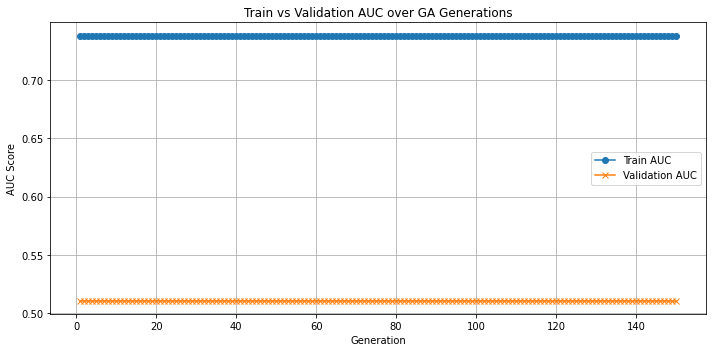

Train AUC Mean: 0.7378
Validation AUC Mean: 0.5110


/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/scipy/stats/_bootstrap.py:106: RuntimeWarning: invalid value encountered in double_scalars
  alpha_1 = ndtr(z0_hat + num1/(1 - a_hat*num1))
/home/radiomicsserver/anaconda3/envs/radiomics/lib/python3.7/site-packages/scipy/stats/_bootstrap.py:108: RuntimeWarning: invalid value encountered in double_scalars
  alpha_2 = ndtr(z0_hat + num2/(1 - a_hat*num2))


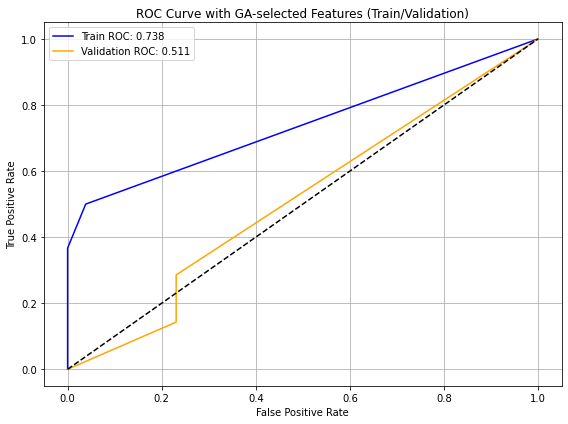

Fold 5 - DecisionTreeClassifier: Train AUC=0.7378, Val AUC=0.5110, Features=49

Step 2: Tuning + GA for RandomForestClassifier
Starting GA with 100 individuals for 150 generations...
Generation 10: Best CV AUC = 0.6403, Features = 60
Generation 20: Best CV AUC = 0.6473, Features = 60
Generation 30: Best CV AUC = 0.6539, Features = 57
Generation 40: Best CV AUC = 0.6633, Features = 57
Generation 50: Best CV AUC = 0.6636, Features = 57
Generation 60: Best CV AUC = 0.6636, Features = 57
Generation 70: Best CV AUC = 0.6667, Features = 57
Generation 80: Best CV AUC = 0.6667, Features = 57
Generation 90: Best CV AUC = 0.6667, Features = 57
Generation 100: Best CV AUC = 0.6667, Features = 57
Generation 110: Best CV AUC = 0.6700, Features = 57
Generation 120: Best CV AUC = 0.6700, Features = 57
Generation 130: Best CV AUC = 0.6700, Features = 57
Generation 140: Best CV AUC = 0.6700, Features = 57
Generation 150: Best CV AUC = 0.6700, Features = 57
GA completed! Best CV AUC: 0.6700
Best solutio

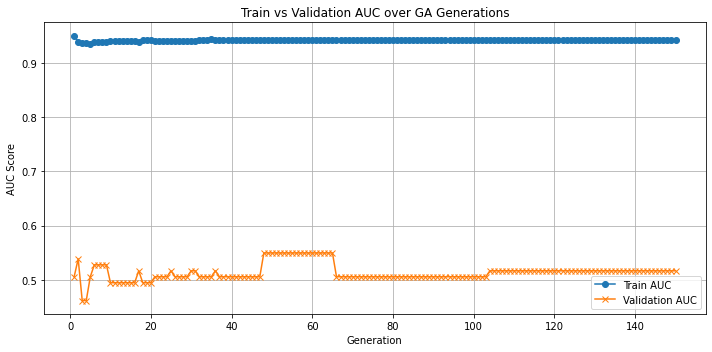

Train AUC Mean: 0.9421
95% CI for Train AUC: [0.9419, 0.9423]
Validation AUC Mean: 0.5141
95% CI for Validation AUC: [0.5115, 0.5171]


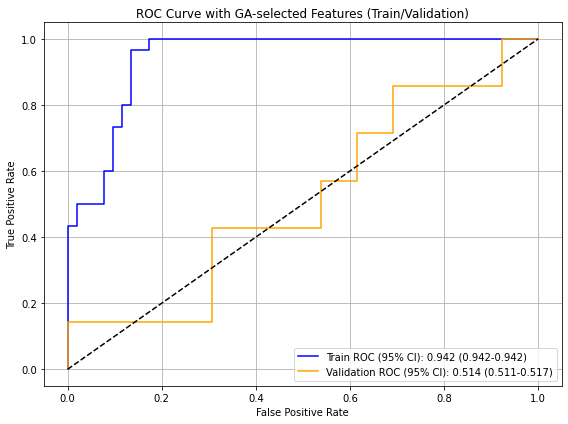

Fold 5 - RandomForestClassifier: Train AUC=0.9423, Val AUC=0.5165, Features=57
Fold 5 total selected features: 98

BUILDING CONSENSUS FEATURES
Consensus selected features: 102
Feature selection frequency: [5 5 5 5 3 5 4 5 5 5 5 5 5 5 5 5 4 5 5 5 4 5 4 5 4 5 4 5 5 3 5 5 5 5 5 5 5
 5 4 4 5 4 5 5 5 4 5 5 5 5 5 5 5 5 5 5 5 5 5 4 5 5 5 5 5 4 5 5 5 5 5 5 5 5
 5 5 5 4 5 5 4 5 4 5 5 4 4 5 5 5 5 4 5 5 5 5 5 4 5 5 5 5]

FINAL EVALUATION ON TEST SET

Final evaluation: LogisticRegression
Bootstrapped 95% CI for Final Model Test AUC: 0.6707 [0.5447, 0.7825] (valid reps = 1000)
Bootstrapped 95% CI for Final Model Test AUC: 0.5989 [0.3875, 0.8063] (valid reps = 1000)

Final evaluation: GaussianNB
Bootstrapped 95% CI for Final Model Test AUC: 0.6940 [0.5838, 0.7971] (valid reps = 1000)
Bootstrapped 95% CI for Final Model Test AUC: 0.6179 [0.3997, 0.8250] (valid reps = 1000)

Final evaluation: SVC
Bootstrapped 95% CI for Final Model Test AUC: 0.3089 [0.2004, 0.4283] (valid reps = 1000)
Bootstrapped 95%

In [ ]:
# ==========================================
# GA-ONLY MAIN PIPELINE (WITHOUT LASSO)
# ==========================================

def ga_only_main_pipeline():
    """
    GA-ONLY feature selection pipeline (without LASSO pre-filtering).
    This version applies GA directly to all original features for each classifier.
    
    Pipeline: Raw Data → 80/20 Split → 5-Fold CV → GA → Consensus → Final Test
    """
    
    print("="*80)
    print("GA-ONLY RADIOMICS FEATURE SELECTION PIPELINE")
    print("="*80)
    
    # ===============================================================
    # 1) Load data and perform initial 80/20 split
    # ===============================================================
    print("\nStep 1: Loading data and creating train/test split...")
    
    radiomics_data, clinical_data = load_data()
    radiomics_cols = get_radiomics_columns(radiomics_data)
    X_raw = radiomics_data[radiomics_cols].values
    y = clinical_data["LocoRegeonalRecurrence"].values
    feature_names = radiomics_data[radiomics_cols].columns.tolist()

    print(f"Dataset: {len(X_raw)} samples, {X_raw.shape[1]} features")
    print(f"Class distribution: LRR={np.sum(y)} ({100*np.sum(y)/len(y):.1f}%), "
          f"Non-LRR={len(y)-np.sum(y)} ({100*(len(y)-np.sum(y))/len(y):.1f}%)")

    # Proper 80/20 split with stratification
    X_temp, X_test_raw, y_temp, y_test = train_test_split(
        X_raw, y, test_size=0.2, stratify=y, random_state=42
    )

    print(f"Training/Validation: {len(X_temp)} samples")
    print(f"Test (held-out): {len(X_test_raw)} samples")

    # ===============================================================
    # 2) 5-Fold CV with GA-only feature selection
    # ===============================================================
    print(f"\nStep 2: 5-Fold Cross-Validation with GA-only feature selection...")
    print("Note: GA will work on all original features (no LASSO pre-filtering)")
    
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    
    # Define classifiers
    classifiers = [
        LogisticRegression(max_iter=1000),
        GaussianNB(),
        SVC(kernel='linear', probability=True),
        SVC(kernel='rbf', probability=True),
        DecisionTreeClassifier(random_state=42),
        RandomForestClassifier(random_state=42, n_jobs=-1)
    ]

    # Store selected feature NAMES for proper consensus building
    fold_selected_features = {}  # classifier -> [fold_features_sets]
    classifier_fold_results = {}
    
    for clf in classifiers:
        clf_name = clf.__class__.__name__
        fold_selected_features[clf_name] = []
        classifier_fold_results[clf_name] = {
            'train_aucs': [], 'val_aucs': [], 'train_accs': [], 'val_accs': []
        }

    # Cross-validation loop
    for fold_id, (tr_idx, va_idx) in enumerate(skf.split(X_temp, y_temp), 1):
        print(f"\n{'='*60}")
        print(f"PROCESSING FOLD {fold_id}/5")
        print(f"{'='*60}")
        
        X_tr_raw, X_va_raw = X_temp[tr_idx], X_temp[va_idx]
        y_tr, y_va = y_temp[tr_idx], y_temp[va_idx]

        # STEP 1: Proper scaling (fit on train, transform both)
        scaler = StandardScaler()
        X_tr_scaled = scaler.fit_transform(X_tr_raw)
        X_va_scaled = scaler.transform(X_va_raw)
        
        print(f"Working with ALL {X_tr_scaled.shape[1]} original features")

        # STEP 2: GA feature selection per classifier (directly on all features)
        for clf in classifiers:
            clf_name = clf.__class__.__name__
            print(f"\nProcessing {clf_name} with GA on full feature set...")
            
            try:
                # Hyperparameter tuning on full scaled feature set
                tuned_clf = get_tuned_model(clf, X_tr_scaled, y_tr)

                # GA feature selection on ALL features (no LASSO pre-filtering)
                print(f"  Running GA on {X_tr_scaled.shape[1]} features...")
                best_solution, train_auc_hist, val_auc_hist = run_genetic_algorithm(
                    X_tr_scaled, y_tr, X_va_scaled, y_va, tuned_clf, 
                    pop_size=50,     # Larger population for larger search space
                    generations=60,  # More generations for full feature space
                    verbose=False
                )

                # Get GA-selected feature names
                ga_selected_indices = np.where(best_solution == 1)[0]
                ga_selected_feature_names = [feature_names[i] for i in ga_selected_indices]
                
                # Store selected feature names for this classifier and fold
                fold_selected_features[clf_name].append(set(ga_selected_feature_names))

                # Evaluate performance with GA-selected features
                if len(ga_selected_indices) > 0:
                    X_tr_ga = X_tr_scaled[:, best_solution == 1]
                    X_va_ga = X_va_scaled[:, best_solution == 1]
                    
                    # Train final model and evaluate
                    final_model = make_pipeline(StandardScaler(), tuned_clf)
                    final_model.fit(X_tr_ga, y_tr)
                    
                    # Get predictions
                    if hasattr(final_model, 'predict_proba'):
                        y_tr_proba = final_model.predict_proba(X_tr_ga)[:, 1]
                        y_va_proba = final_model.predict_proba(X_va_ga)[:, 1]
                    else:
                        y_tr_proba = final_model.decision_function(X_tr_ga)
                        y_va_proba = final_model.decision_function(X_va_ga)
                    
                    y_tr_pred = final_model.predict(X_tr_ga)
                    y_va_pred = final_model.predict(X_va_ga)
                    
                    # Calculate metrics
                    train_auc = roc_auc_score(y_tr, y_tr_proba)
                    val_auc = roc_auc_score(y_va, y_va_proba)
                    train_acc = accuracy_score(y_tr, y_tr_pred)
                    val_acc = accuracy_score(y_va, y_va_pred)
                    
                    # Store results
                    classifier_fold_results[clf_name]['train_aucs'].append(train_auc)
                    classifier_fold_results[clf_name]['val_aucs'].append(val_auc)
                    classifier_fold_results[clf_name]['train_accs'].append(train_acc)
                    classifier_fold_results[clf_name]['val_accs'].append(val_acc)
                    
                    print(f"  {clf_name}: Train AUC={train_auc:.4f}, Val AUC={val_auc:.4f}, "
                          f"Features selected={len(ga_selected_indices)}")
                else:
                    print(f"  Warning: {clf_name} selected no features in fold {fold_id}")
                    
            except Exception as e:
                print(f"  Error processing {clf_name}: {e}")
                fold_selected_features[clf_name].append(set())

    # ===============================================================
    # 3) Build consensus features using the same method
    # ===============================================================
    print(f"\n{'='*60}")
    print("BUILDING CONSENSUS FEATURES FROM GA SELECTIONS")
    print(f"{'='*60}")
    
    # Build consensus per classifier, then combine (same logic as other algorithms)
    classifier_consensus_features = {}
    
    for clf_name in fold_selected_features:
        if len(fold_selected_features[clf_name]) == 0:
            classifier_consensus_features[clf_name] = set()
            continue
            
        # Get all unique features selected by this classifier across folds
        all_features_for_clf = set()
        for fold_features in fold_selected_features[clf_name]:
            all_features_for_clf.update(fold_features)
        
        # Count votes for each feature
        feature_votes = {}
        for feature in all_features_for_clf:
            votes = sum(1 for fold_features in fold_selected_features[clf_name] 
                       if feature in fold_features)
            feature_votes[feature] = votes
        
        # Select features with majority vote (>= 3 out of 5 folds)
        consensus_features_clf = {feature for feature, votes in feature_votes.items() 
                                 if votes >= 3}
        
        # Fallback: if no features meet majority threshold, use >= 2 votes
        if len(consensus_features_clf) == 0:
            consensus_features_clf = {feature for feature, votes in feature_votes.items() 
                                     if votes >= 2}
        
        # Final fallback: use union if still empty
        if len(consensus_features_clf) == 0:
            consensus_features_clf = all_features_for_clf
            
        classifier_consensus_features[clf_name] = consensus_features_clf
        print(f"{clf_name}: {len(consensus_features_clf)} consensus features")

    # FINAL CONSENSUS: Union of all classifier consensus features
    final_consensus_features = set()
    for clf_features in classifier_consensus_features.values():
        final_consensus_features.update(clf_features)
    
    # Convert back to indices for final evaluation
    consensus_feature_names = list(final_consensus_features)
    consensus_indices = [feature_names.index(fname) for fname in consensus_feature_names 
                        if fname in feature_names]
    
    print(f"\nFinal GA consensus: {len(consensus_indices)} features")
    print(f"Consensus features: {consensus_feature_names[:10]}..." if len(consensus_feature_names) > 10 
          else f"Consensus features: {consensus_feature_names}")

    # ===============================================================
    # 4) Final evaluation on held-out test set
    # ===============================================================
    print(f"\n{'='*60}")
    print("FINAL EVALUATION ON HELD-OUT TEST SET")
    print(f"{'='*60}")
    
    if len(consensus_indices) == 0:
        print("ERROR: No consensus features found. Cannot proceed with final evaluation.")
        return
    
    # Apply final scaling and consensus feature selection
    scaler_final = StandardScaler()
    X_trval_scaled = scaler_final.fit_transform(X_temp)
    X_test_scaled = scaler_final.transform(X_test_raw)
    
    # Select GA consensus features
    X_trval_final = X_trval_scaled[:, consensus_indices]
    X_test_final = X_test_scaled[:, consensus_indices]
    
    print(f"Final training set: {X_trval_final.shape}")
    print(f"Final test set: {X_test_final.shape}")

    # Final evaluation per classifier
    final_results = {}
    
    for clf in classifiers:
        clf_name = clf.__class__.__name__
        print(f"\nFinal evaluation: {clf_name}")
        
        try:
            # Retune on full 80% with GA consensus features
            tuned_clf_final = get_tuned_model(clf, X_trval_final, y_temp)
            tuned_clf_final.fit(X_trval_final, y_temp)

            # Training performance (80% data)
            if hasattr(tuned_clf_final, "predict_proba"):
                y_train_proba = tuned_clf_final.predict_proba(X_trval_final)[:, 1]
            else:
                y_train_proba = tuned_clf_final.decision_function(X_trval_final)
            
            y_train_pred = tuned_clf_final.predict(X_trval_final)
            train_auc = roc_auc_score(y_temp, y_train_proba)
            train_acc = accuracy_score(y_temp, y_train_pred)

            # Test performance (20% held-out data)
            if hasattr(tuned_clf_final, "predict_proba"):
                y_test_proba = tuned_clf_final.predict_proba(X_test_final)[:, 1]
            else:
                y_test_proba = tuned_clf_final.decision_function(X_test_final)
            
            y_test_pred = tuned_clf_final.predict(X_test_final)
            test_auc = roc_auc_score(y_test, y_test_proba)
            test_acc = accuracy_score(y_test, y_test_pred)

            # Bootstrap confidence intervals
            train_mean_auc, train_lower, train_upper, train_valid = bootstrap_final_model_auc_ci(
                y_temp, y_train_proba, n_bootstrap=1000
            )
            
            test_mean_auc, test_lower, test_upper, test_valid = bootstrap_final_model_auc_ci(
                y_test, y_test_proba, n_bootstrap=1000
            )

            # Store results
            final_results[clf_name] = {
                'train_auc': train_auc,
                'train_acc': train_acc,
                'test_auc': test_auc,
                'test_acc': test_acc,
                'train_ci_lower': train_lower,
                'train_ci_upper': train_upper,
                'test_ci_lower': test_lower,
                'test_ci_upper': test_upper
            }
            
        except Exception as e:
            print(f"Error evaluating {clf_name}: {e}")

    # ===============================================================
    # 5) COMPREHENSIVE RESULTS SUMMARY
    # ===============================================================
    print(f"\n{'='*80}")
    print("GA-ONLY PIPELINE PERFORMANCE SUMMARY")
    print(f"{'='*80}")
    
    print(f"\nDATASET SUMMARY:")
    print(f"- Total samples: {len(X_raw)} (Train/Val: {len(X_temp)}, Test: {len(X_test_raw)})")
    print(f"- Original features: {X_raw.shape[1]}")
    print(f"- GA consensus features: {len(consensus_indices)}")
    print(f"- Feature reduction: {X_raw.shape[1]} → {len(consensus_indices)} "
          f"({100*len(consensus_indices)/X_raw.shape[1]:.1f}%)")
    print(f"- Class distribution: LRR={np.sum(y)} ({100*np.sum(y)/len(y):.1f}%)")

    # Cross-validation performance summary
    print(f"\nCROSS-VALIDATION PERFORMANCE (5-Fold, Mean ± Std):")
    print("-" * 80)
    print(f"{'Classifier':<25} {'Train AUC':<15} {'Val AUC':<15} {'Train Acc':<15} {'Val Acc':<15}")
    print("-" * 80)
    
    for clf_name, results in classifier_fold_results.items():
        if results['train_aucs']:
            train_auc_mean = np.mean(results['train_aucs'])
            train_auc_std = np.std(results['train_aucs'])
            val_auc_mean = np.mean(results['val_aucs'])
            val_auc_std = np.std(results['val_aucs'])
            train_acc_mean = np.mean(results['train_accs'])
            train_acc_std = np.std(results['train_accs'])
            val_acc_mean = np.mean(results['val_accs'])
            val_acc_std = np.std(results['val_accs'])
            
            print(f"{clf_name:<25} {train_auc_mean:.3f}±{train_auc_std:.3f}     "
                  f"{val_auc_mean:.3f}±{val_auc_std:.3f}     "
                  f"{train_acc_mean:.3f}±{train_acc_std:.3f}     "
                  f"{val_acc_mean:.3f}±{val_acc_std:.3f}")

    # Final test performance
    print(f"\nFINAL PERFORMANCE WITH 95% BOOTSTRAP CONFIDENCE INTERVALS:")
    print("-" * 100)
    print(f"{'Classifier':<25} {'Train AUC [95% CI]':<25} {'Test AUC [95% CI]':<25} {'Test Acc':<10}")
    print("-" * 100)
    
    for clf_name, results in final_results.items():
        train_auc = results['train_auc']
        train_lower = results['train_ci_lower']
        train_upper = results['train_ci_upper']
        test_auc = results['test_auc']
        test_lower = results['test_ci_lower']
        test_upper = results['test_ci_upper']
        test_acc = results['test_acc']

        print(f"{clf_name:<25} {train_auc:.3f} [{train_lower:.3f},{train_upper:.3f}]   "
              f"{test_auc:.3f} [{test_lower:.3f},{test_upper:.3f}]   {test_acc:.3f}")

    # Best performer and comparison insights
    if final_results:
        best_clf = max(final_results.keys(), key=lambda x: final_results[x]['test_auc'])
        best_test_auc = final_results[best_clf]['test_auc']
        best_test_acc = final_results[best_clf]['test_acc']
        
        print(f"\nBest GA-Only Performance: {best_clf}")
        print(f"Test AUC: {best_test_auc:.4f}, Test Accuracy: {best_test_acc:.4f}")
        
        # Calculate average feature reduction
        avg_features_per_classifier = np.mean([len(features) for features in classifier_consensus_features.values() if features])
        print(f"Average features per classifier: {avg_features_per_classifier:.1f}")

    print(f"\n{'='*80}")
    print("GA-ONLY PIPELINE COMPLETE")
    print("Compare these results with LASSO+GA to evaluate the impact of pre-filtering")
    print(f"{'='*80}")
    
    return final_results, consensus_feature_names, classifier_fold_results


# Run the GA-only pipeline
if __name__ == "__main__":
    ga_results, ga_consensus_features, ga_cv_results = ga_only_main_pipeline()

---